In [ ]:
#Code compiled for Shin et al. 2024
#Last amended 9/29/24 by Maddie Urbanek
#Components:
    #Terminal
        #Rabies barcode calling
        #Alignment of transcriptomes w/ Pipseeker, STAR
    #Python
    #R

In [ ]:
#Terminal set up
#Activate virtual environment
source /Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/bin/activate​

#Load path of samtools (un-hash and change to your path if you want to use this)
#export PATH=$PATH:path/to/samtools/for/server
​
#Load path of bbduk (change to your path)
export PATH=$PATH:/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/
​
#Load py3 environment which contains newest pip version of umi_tools
export PATH=/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv:$PATH

In [ ]:
#Calling barcode bits in terminal
##Generate fastqs with actual CBCs in read 1
/Users/maddieurbanek/pipseeker/pipseeker barcode --fastq . --chemistry v4 --output . --skip-version-check
cd barcoded_fastqs
gunzip *.gz
cat barcoded_1_R1.fastq barcoded_2_R1.fastq>barcode_temp.fq
cat barcode_temp.fq barcoded_3_R1.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_4_R1.fastq > barcode_temp.fq
cat barcode_temp.fq barcoded_5_R1.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_6_R1.fastq > barcode_temp.fq
cat barcode_temp.fq barcoded_7_R1.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_8_R1.fastq > barcode_R1.fq

cat barcoded_1_R2.fastq barcoded_2_R2.fastq>barcode_temp.fq
cat barcode_temp.fq barcoded_3_R2.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_4_R2.fastq > barcode_temp.fq
cat barcode_temp.fq barcoded_5_R2.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_6_R2.fastq > barcode_temp.fq
cat barcode_temp.fq barcoded_7_R2.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_8_R2.fastq > barcode_R2.fq
rm *.fastq
rm *temp*

##Make dataset-specific CBC reference genome
cd ../../barcodes
cp barcode_whitelist.txt barcodes.txt   
awk '1;1' barcodes.txt >cbc.txt
awk 'NR % 2 == 1 {sub(/^/,">")} {print}' cbc.txt >cbc.fa  
bowtie2-build cbc.fa cbc 
rm barcodes.txt  
rm cbc.txt  

##Generate rabies barcode and helper count matrices
bbduk.sh in=barcodes_R2.fastq out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq
rm bit1.sam
rm bit1sorted.sam

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq
rm bit2.sam
rm bit2sorted.sam

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt
rm temp1.fq
rm bit3.sam
rm bit3sorted.sam

bbduk.sh in=barcodes_R1.fastq out=cbc.fq ftr=15 qin=33
bowtie2 -x ../barcodes/cbc cbc.fq -N 1 -S cbc.sam
samtools sort cbc.sam -n -o cbcsorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$10}' cbcsorted.sam > cbc.txt


bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc.txt > temp && mv temp cbc.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc.txt > part3.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,1.5,2.2 part3.txt cbc_Insert_UMI.txt > full.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$6"_"$5,$2"-"$3"-"$4}' full.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

bbduk.sh in=barcodes_R2.fastq out=temp.fq maq=20 int=f
bbduk.sh in=temp.fq literal=AGCCATCTGTTGTTT k=12 skipr1 restrictright=125 hdist=1 out=helper.fq outm1=helper_R1.fq outm2=helper_R2.fq int=t
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=helper_R2.fq out=helper_R2.sam int=f
samtools sort helper_R2.sam -n -o helper_R2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' helper_R2sorted.sam  > helper.txt

awk '!/@/' helper.txt > temp && mv temp helperhit.txt  
join -1 1 -2 1 -o 1.1,1.2,2.2 cbc.txt helperhit.txt > helperindex.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 helperindex.txt cbc_Insert_UMI.txt > helperindexfull.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$4"_"$2,$3}' helperindexfull.txt > helperindex.txt
awk 'BEGIN {OFS="\t"}; {print $1,"helper"}' helperindex.txt > helperUMI.txt
umi_tools count_tab --per-cell --edit-distance-threshold=1 -I helperUMI.txt -S helperindex.tsv -L counts.log
awk '!/cell/' helperindex.tsv > tmpfile && mv tmpfile helperindex.tsv
tail -n +2 helperindex.tsv > helpercounts.tsv
{ printf 'CBC\thelper\tUMI_Count\n'; cat helpercounts.tsv; } > helperindex.tsv

In [ ]:
#Sample barcode diversity
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam

bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../3
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../4
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../5
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../6
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../7
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../e1
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../e2
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../e3
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../e4
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../e5
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

cd ../e6
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

../e7
bbduk.sh in=barcodes_R2.fastq.gz out=temp.fq maq=20 int=f

bbduk.sh in=temp.fq out=temp1.fq ftl=19 ftr=38
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit3r temp1.fq -N 1 -S bit1.sam
samtools sort bit1.sam -n -o bit1sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit1sorted.sam > bit1_hit.txt
rm temp1.fq                                   
rm bit1.sam                                                                                                 
rm bit1sorted.sam                          

bbduk.sh in=temp.fq out=temp1.fq ftl=39 ftr=58
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit2r temp1.fq -N 1 -S bit2.sam
samtools sort bit2.sam -n -o bit2sorted.sam
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit2sorted.sam > bit2_hit.txt
rm temp1.fq                                              
rm bit2.sam                                      
rm bit2sorted.sam                        

bbduk.sh in=temp.fq out=temp1.fq ftl=59 ftr=78
bowtie2 -x /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/bits/bit1r temp1.fq -N 1 -S bit3.sam
samtools sort bit3.sam -n -o bit3sorted.sam                
awk 'BEGIN {OFS="\t"}; {print $1,$3}' bit3sorted.sam > bit3_hit.txt                                
rm temp1.fq                            
rm bit3.sam                                                           
rm bit3sorted.sam
bbduk.sh in=barcodes_R1.fastq out=temp4.fq ftr=28 qin=33
/Users/maddieurbanek/Desktop/Rabies/localanalysis/bbmap/reformat.sh in=temp4.fq out=temp4.sam int=f
samtools sort temp4.sam -n -o temp5.sam
awk 'BEGIN {OFS="\t"}; {print $1,$11}' temp5.sam  > cbc_Insert_UMI.txt
    
awk '!/@/' bit1_hit.txt > temp && mv temp bit1_hit.txt
awk '!/@/' bit2_hit.txt > temp && mv temp bit2_hit.txt
awk '!/@/' bit3_hit.txt > temp && mv temp bit3_hit.txt
awk '!/@/' cbc_Insert_UMI.txt > temp && mv temp cbc_Insert_UMI.txt
    
join -1 1 -2 1 -o 1.1,1.2,2.2 bit1_hit.txt bit2_hit.txt > part1.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,2.2 part1.txt bit3_hit.txt > part2.txt
join -1 1 -2 1 -o 1.1,1.2,1.3,1.4,2.2 part2.txt cbc_Insert_UMI.txt > part3.txt
awk 'BEGIN {OFS="\t"}; {print $1"_"$5"_AAAAAAAAAAAA",$2"-"$3"-"$4}' part3.txt > full1.txt
awk '!/\*/' full1.txt > full.txt
sort -k2  full.txt > flat.txt

umi_tools count_tab --per-cell --edit-distance-threshold=1 -I flat.txt -S counts.tsv -L counts.log
tail -n +2 counts.tsv > completecounts.tsv
awk '!/cell/' completecounts.tsv > tmpfile && mv tmpfile completecounts.tsv
{ printf 'CBC\tbarcode\tUMI_Count\n'; cat completecounts.tsv; } > counts.tsv
mv counts.tsv completecounts.tsv

In [ ]:
#Transcriptome alignment
gunzip *.gz
/Users/maddieurbanek/pipseeker/pipseeker full --fastq /Users/maddieurbanek/Downloads/cvs_h/. --star-index-path /Users/maddieurbanek/pipseeker/pipseeker-gex-reference-GRCh38-2022.04 --chemistry v4 --output /Users/maddieurbanek/Downloads/cvs_h/ --retain-barcoded-fastqs --skip-version-check --skip-preflight-check
cd barcodes
awk '1;1' barcode_whitelist.txt > cbc.txt
awk 'NR % 2 == 1 {sub(/^/,">")} {print}' cbc.txt >cbc.fa
cd ../barcoded_fastqs
cd barcoded_fastqs
gunzip *.gz
cat barcoded_1_R1.fastq barcoded_2_R1.fastq>barcode_temp.fq
cat barcode_temp.fq barcoded_3_R1.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_4_R1.fastq > barcode_temp.fq
cat barcode_temp.fq barcoded_5_R1.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_6_R1.fastq > barcode_temp.fq
cat barcode_temp.fq barcoded_7_R1.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_8_R1.fastq > barcode_R1.fq

cat barcoded_1_R2.fastq barcoded_2_R2.fastq>barcode_temp.fq
cat barcode_temp.fq barcoded_3_R2.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_4_R2.fastq > barcode_temp.fq
cat barcode_temp.fq barcoded_5_R2.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_6_R2.fastq > barcode_temp.fq
cat barcode_temp.fq barcoded_7_R2.fastq > barcode_temp1.fq
cat barcode_temp1.fq barcoded_8_R2.fastq > barcode_R2.fq
rm *.fastq
rm *temp*

/usr/local/bin/STAR --genomeDir /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/human_star --sjdbGTFfile /Users/maddieurbanek/Desktop/Rabies/localanalysis/refgenomes/human_star/hg38.ncbiRefSeq.gtf --runThreadN 12 --soloType CB_UMI_Simple --soloCBstart 1 --soloCBlen 16 --soloUMIstart 17 --outSAMattributes CB CR CY GX GN UB UR UY NH HI nM AS sF --outSAMtype BAM SortedByCoordinate --soloCBmatchWLtype Exact --soloUMIdedup 1MM_CR --soloFeatures Gene Velocyto --soloMultiMappers EM --soloCellReadStats Standard --soloCellFilter EmptyDrops_CR --soloUMIfiltering MultiGeneUMI_CR --outSAMunmapped Within --soloBarcodeReadLength 0 --soloCBwhitelist /Users/maddieurbanek/Downloads/cvs_l/barcodes/barcode_whitelist.txt --soloUMIlen 12 --readFilesIn /Users/maddieurbanek/Downloads/cvs_l/barcoded_fastqs/barcode_R2.fq /Users/maddieurbanek/Downloads/cvs_l/barcoded_fastqs/barcode_R1.fq --outFileNamePrefix trimmed_


In [ ]:
#Load in modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from itertools import product
from pycirclize import Circos
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA

In [ ]:
FOR TRANSCRIPTOME FIG

In [1525]:
#Connectivity analysis (w/ conservative barcode calling)
metadata=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/metadata.csv',delimiter=',')
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/thresholded_barcodes.csv',delimiter=',')
foundercells=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/thresholded_helpers.csv',delimiter=',')
barcodes.drop(barcodes[barcodes['UMI_Count'] < 3].index, inplace=True)
barcodes = barcodes[barcodes['CBC'].isin(metadata['cellbarcode'])]
foundercells.drop(foundercells[foundercells['UMI_Count'] < 3].index, inplace=True)
print(len(barcodes))
l23=metadata.loc[metadata['celltype'] == 'L2/3', 'cellbarcode']
l4=metadata.loc[metadata['celltype'] == 'L4', 'cellbarcode']
rg=metadata.loc[metadata['celltype'] == 'RG', 'cellbarcode']
inh=metadata.loc[metadata['celltype'] == 'In', 'cellbarcode']
pro=metadata.loc[metadata['celltype'] == 'Progenitors', 'cellbarcode']
ast=metadata.loc[metadata['celltype'] == 'Astrocytes', 'cellbarcode']
l56sp=metadata.loc[metadata['celltype'] == 'L5/6/SP', 'cellbarcode']
opcs=metadata.loc[metadata['celltype'] == 'OPCs', 'cellbarcode']

barcodes['celltype'] = barcodes.loc[:, 'CBC']
barcodes.loc[barcodes['CBC'].isin(l23), 'celltype'] = 'L2/3'
barcodes.loc[barcodes['CBC'].isin(l4), 'celltype'] = 'L4'
barcodes.loc[barcodes['CBC'].isin(rg), 'celltype'] = 'RG'
barcodes.loc[barcodes['CBC'].isin(inh), 'celltype'] = 'In'
barcodes.loc[barcodes['CBC'].isin(pro), 'celltype'] = 'Progenitors'
barcodes.loc[barcodes['CBC'].isin(ast), 'celltype'] = 'Astrocytes'
barcodes.loc[barcodes['CBC'].isin(l56sp), 'celltype'] = 'L5/6/SP'
barcodes.loc[barcodes['CBC'].isin(opcs), 'celltype'] = 'OPCs'
actualbarcodes = barcodes[barcodes.duplicated(subset=['barcode'], keep=False)]
print('Total number of barcodes with at least one pair:')
print(len(actualbarcodes))

actualbarcodes['helper'] = actualbarcodes.loc[:, 'CBC']
foundercells=foundercells['CBC']
print('Number of founders in dataset:')
print(len(foundercells))
print('Total number of cells with barcodes in dataset:')
print(actualbarcodes['CBC'].nunique())
actualbarcodes.loc[actualbarcodes['CBC'].isin(foundercells), 'helper'] = 'founder'
actualbarcodes.loc[~actualbarcodes['CBC'].isin(foundercells), 'helper'] = 'presynaptic'


cellprops=actualbarcodes.groupby(['celltype','helper'])['CBC'].nunique()
#actualbarcodes.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/finalized_barcodes.csv')


182495
Total number of barcodes with at least one pair:
175564
Number of founders in dataset:
2478
Total number of cells with barcodes in dataset:
15786


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/1733186218.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actualbarcodes['helper'] = actualbarcodes.loc[:, 'CBC']


In [1541]:
sad_1=actualbarcodes[actualbarcodes['CBC'].str.contains('s1')] 
sad_2=actualbarcodes[actualbarcodes['CBC'].str.contains('s2')] 
sad_3=actualbarcodes[actualbarcodes['CBC'].str.contains('s3')] 
sad_4=actualbarcodes[actualbarcodes['CBC'].str.contains('s4')] 
sad_5=actualbarcodes[actualbarcodes['CBC'].str.contains('s5')] 
cvs_1=actualbarcodes[actualbarcodes['CBC'].str.contains('c1')] 
cvs_2=actualbarcodes[actualbarcodes['CBC'].str.contains('c2')] 
nuc_1=actualbarcodes[actualbarcodes['CBC'].str.contains('c1')] 
nuc_2=actualbarcodes[actualbarcodes['CBC'].str.contains('c2')] 

sad_1_props=sad_1.groupby(['celltype','helper'])['CBC'].nunique()
sad_2_props=sad_2.groupby(['celltype','helper'])['CBC'].nunique()
sad_3_props=sad_3.groupby(['celltype','helper'])['CBC'].nunique()
sad_4_props=sad_4.groupby(['celltype','helper'])['CBC'].nunique()
sad_5_props=sad_5.groupby(['celltype','helper'])['CBC'].nunique()
cvs_1_props=cvs_1.groupby(['celltype','helper'])['CBC'].nunique()
cvs_2_props=cvs_2.groupby(['celltype','helper'])['CBC'].nunique()
nuc_1_props=nuc_1.groupby(['celltype','helper'])['CBC'].nunique()
nuc_2_props=nuc_2.groupby(['celltype','helper'])['CBC'].nunique()

print(sad_1_props)
print(sad_2_props)
print(sad_3_props)
print(sad_4_props)
print(sad_5_props)
print(cvs_1_props)
print(cvs_2_props)
print(nuc_1_props)
print(nuc_2_props)

celltype     helper     
Astrocytes   founder          2
             presynaptic     10
In           founder          2
             presynaptic     38
L2/3         founder         27
             presynaptic    245
L4           presynaptic     27
L5/6/SP      founder          1
OPCs         presynaptic     14
Progenitors  presynaptic     14
RG           presynaptic     20
Name: CBC, dtype: int64
celltype     helper     
Astrocytes   presynaptic      84
In           presynaptic      77
L2/3         founder           5
             presynaptic    1195
L4           presynaptic     198
L5/6/SP      founder           6
             presynaptic     111
OPCs         presynaptic      11
Progenitors  presynaptic      51
RG           presynaptic     129
Name: CBC, dtype: int64
celltype     helper     
Astrocytes   founder         47
             presynaptic     59
In           founder         10
             presynaptic    164
L2/3         founder        106
             presynaptic    349
L4 

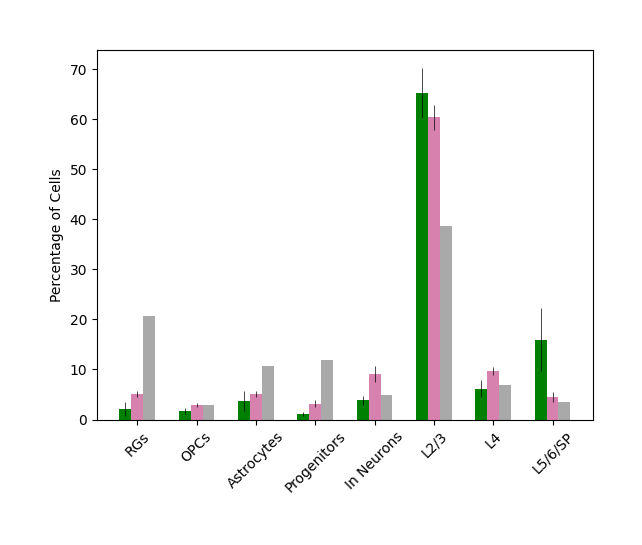

Post hoc
RG
inf
TtestResult(statistic=-23.90950281141488, pvalue=9.975241178032471e-09, df=8)
1.5968e-07

founder
TtestResult(statistic=-12.530364973336752, pvalue=1.5409100767237482e-06, df=8)
2.464e-05

Post hoc
OPCs
inf
TtestResult(statistic=-0.567690639710242, pvalue=0.5858197102086469, df=8)
9.37311536

founder
TtestResult(statistic=-2.133877700563184, pvalue=0.06539692699736359, df=8)
1.046350832

Post hoc
Astrocytes
inf
TtestResult(statistic=-14.918451901714377, pvalue=4.01974986279519e-07, df=8)
6.432e-06

founder
TtestResult(statistic=-3.3374341477081115, pvalue=0.010270249581183267, df=8)
0.164324

Post hoc
Progenitors
inf
TtestResult(statistic=-3.8887421087560217, pvalue=0.004617419493287592, df=8)
0.073878704

founder
TtestResult(statistic=-21.720135537477685, pvalue=2.1282556975592855e-08, df=8)
3.408e-07

Post hoc
GABAergic
inf
TtestResult(statistic=-7.747734014837611, pvalue=5.49553410967291e-05, df=8)
0.00088

founder
TtestResult(statistic=-1.1510395593983966, pvalue=0.

In [74]:
#Barplot of cell type proportions for each dataset
#Error calculated in 'pre_post_proportions_error.csv'
#strain_metadata.groupby('datasetid')['celltype'].value_counts().to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/pre_post_proportions_error.csv')

x = np.arange(8)
width= 0.20

inf_error = [0.616869773,0.383114866,0.650025879,0.677892149,1.573296212,2.512127079,0.851389428,0.999679136]
founder_error = [1.397144377,0.565818183,1.957174726,0.466496559,0.86925483,5.026498599,1.733980631,6.367147859]

infected=[5.084987054,2.880549452,5.091898166,3.161320824,9.037991071,60.45847935,9.713122485,4.571651599]
founder=[2.160026468,1.720657519,3.745658808,1.071288326,3.843583051,65.33941011,6.151091668,15.96828405]
uninfected=[20.72871657,3.001284597,10.67382927,11.81828798,4.904823076,38.59628635,6.855074156,3.421698003]


plt.bar(x-0.2, founder,width,yerr=founder_error, color='green') 
plt.bar(x, infected,width,yerr=inf_error, color='#d781af')
plt.bar(x+0.2, uninfected,width, color='darkgrey')

plt.xticks(x, ['RGs', 'OPCs', 'Astrocytes','Progenitors','In Neurons','L2/3','L4','L5/6/SP'],rotation=45) 
#plt.xlabel("Cell Types")
plt.ylabel("Percentage of Cells") 
#plt.title('Cell Type Proportions')
#plt.legend(["Rabies+",'Helper+/Rabies+','Uninfected'],loc='upper left',fontsize="10") 
plt.draw()
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/4_transcriptome/starter_cell_type_proportions.svg', bbox_inches='tight', format='svg')
plt.show()

print('Post hoc')
print('RG')
print('inf')
inf=[0.054347826,0.06950431,0.077210461,0.03127506,	0.028503563,	0.066037736,	0.032366071,	0.066037736,	0.032366071]
print(stats.ttest_1samp(inf, popmean=0.207287166))
print(9.98E-09*16)
print()
print('founder')
founder=[0,	0,	0.138211382,	0.006493506,	0.011235955,	0.019230769,	0,	0.019230769,	0]
print(stats.ttest_1samp(founder, popmean=0.207287166))
print(1.54E-06*16)
print()

print('Post hoc')
print('OPCs')
print('inf')
inf=[0.038043478	,0.005926724	,0.04109589,	0.044105854,	0.032066508,	0.029753266	,0.019252232,	0.029753266	,0.019252232]
print(stats.ttest_1samp(founder, popmean=0.030012846))
print(0.58581971*16)
print()
print('founder')
founder=[0	,0	,0.028455285	,0.058441558	,0.011235955	,0.019230769	,0.00913242	,0.019230769	,0.00913242]
print(stats.ttest_1samp(founder, popmean=0.030012846))
print(0.065396927*16)
print()

print('Post hoc')
print('Astrocytes')
print('inf')
inf=[0.027173913,	0.045258621,	0.073474471,	0.052927025,	0.042755344,	0.077648766,0.030691964	,0.077648766	,0.030691964]
print(stats.ttest_1samp(founder, popmean=0.106738293))
print(4.02E-07*16)
print()
print('founder')
founder=[0.0625	,0,	0.191056911,	0.051948052,	0.02247191,	0,	0.00456621,	0,	0.00456621]
print(stats.ttest_1samp(founder, popmean=0.106738293))
print(0.01027025*16)
print()


print('Post hoc')
print('Progenitors')
print('inf')
inf=[0.038043478	,0.027478448,	0.085927771,	0.017642342	,0.013064133,	0.028301887	,0.022879464	,0.028301887,	0.022879464]
print(stats.ttest_1samp(founder, popmean=0.11818288))
print(0.004617419*16)
print()
print('founder')
founder=[0	,0	,0.032520325	,0.038961039,	0.011235955,	0	,0.006849315,	0	,0.006849315]
print(stats.ttest_1samp(founder, popmean=0.11818288))
print(2.13E-08*16)
print()


print('Post hoc')
print('GABAergic')
print('inf')
inf=[0.10326087,	0.041487069,	0.204234122,	0.086607859,	0.097387173,	0.043541364,	0.096679688,	0.043541364,	0.096679688]
print(stats.ttest_1samp(founder, popmean=0.049048231))
print(5.50E-05*16)
print()
print('founder')
founder=[0.0625,	0,	0.040650407,	0.038961039,	0,	0.028846154,	0.073059361,	0.028846154,	0.073059361]
print(stats.ttest_1samp(founder, popmean=0.049048231))
print(0.282954751*16)
print()


print('Post hoc')
print('L2/3')
print('inf')
inf=[0.66576087	,0.643857759	,0.434620174	,0.610264635	,0.660332542	,0.547895501,	0.66531808	,0.547895501,	0.66531808]
print(stats.ttest_1samp(founder, popmean=0.385962863))
print(2.69E-10*16)
print()
print('founder')
founder=[0.84375,	0.454545455,	0.430894309,	0.746753247,	0.842696629,	0.548076923,	0.732876712,	0.548076923,	0.732876712]
print(stats.ttest_1samp(founder, popmean=0.385962863))
print(0.00103182*16)
print()


print('Post hoc')
print('L4')
print('inf')
inf=[0.073369565,	0.106681034,	0.067247821,	0.076182839,	0.062945368,	0.129898403,	0.113978795,	0.129898403,	0.113978795]
print(stats.ttest_1samp(founder, popmean=0.068550742))
print(4.24E-06*16)
print()
print('founder')
founder=[0,	0,	0.138211382,	0.032467532,	0.078651685,	0.028846154,	0.123287671,	0.028846154,	0.123287671]
print(stats.ttest_1samp(founder, popmean=0.068550742))
print(0.711857659*16)
print()


print('Post hoc')
print('L5/6/SP')
print('inf')
inf=[0,	0.059806034	,0.01618929	,0.080994387	,0.062945368,	0.076923077,	0.018833705,	0.076923077,	0.018833705]
print(stats.ttest_1samp(founder, popmean=0.03421698))
print(0.176092512*16)
print()
print('founder')
founder=[0.03125,	0.545454545,	0,	0.025974026,	0.02247191,	0.355769231,	0.050228311,	0.355769231,	0.050228311]
print(stats.ttest_1samp(founder, popmean=0.03421698))
print(0.100265239*16)
print()


In [ ]:
FOR CVS VS SADB19 COMPARISON

In [846]:
strain_metadata=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/strains_metadata.csv',delimiter=',')
print(strain_metadata.groupby('virus')['celltype'].value_counts())

virus       celltype   
cvs         L2/3           6615
            L4             1153
            In              884
            RG              383
            Astrocytes      378
            L5/6/SP         324
            Progenitors     249
            OPCs            210
sadb19      L2/3           3568
            In              503
            L4              484
            RG              323
            Astrocytes      317
            L5/6/SP         294
            Progenitors     188
            OPCs            163
uninfected  L2/3           2648
            RG             1687
            Progenitors     958
            Astrocytes      863
            L4              484
            In              313
            L5/6/SP         269
            OPCs            224
Name: count, dtype: int64


In [ ]:
#Transcriptome features ANOVA and Wilcoxon Rank Sum
cvs=strain_metadata.loc[strain_metadata['virus'] == 'cvs', ['nCount_RNA','nFeature_RNA','percent.mt']]
sad=strain_metadata.loc[strain_metadata['virus'] == 'sadb19', ['nCount_RNA','nFeature_RNA','percent.mt']]
uninfected=strain_metadata.loc[strain_metadata['virus'] == 'uninfected', ['nCount_RNA','nFeature_RNA','percent.mt']]

In [66]:
#One sample t-test
#Proportions can be found in strain_proportions_error.csv
print('Overall Paired T-test:CVS')


print()
print('Post hoc')
print('RG')
cvs=[0.064014916,0.03260743]
print(stats.ttest_1samp(cvs, popmean=0.226564598))
print(0.055940407614042606*16)
print()

print('OPCs')
cvs=[0.028589186,0.019098637]
print(stats.ttest_1samp(cvs, popmean=0.030083266))
print(0.4139379611523105*16)
print()

print('Astrocytes')
cvs=[0.072715973,0.030394783]
print(stats.ttest_1samp(cvs, popmean=0.115901155))
print(0.20226489946514745*16)
print()

print('Progenitors')
cvs=[0.027346178,0.023873297]
print(stats.ttest_1samp(cvs, popmean=0.128659683))
print(0.010726330241811608*16)
print()

print('In')
cvs=[0.040397763,0.095376732]
print(stats.ttest_1samp(cvs, popmean=0.042035992))
print(0.5195460588099319*16)
print()

print('L2/3')
cvs=[0.546302051,0.667986491]
print(stats.ttest_1samp(cvs, popmean=0.355627182))
print(0.15109636302320864*16)
print()

print('L4')
cvs=[0.121193288,0.111563992]
print(stats.ttest_1samp(cvs, popmean=0.065001343))
print(0.05948492517796917*16)
print()

print('L5/6/SP')
cvs=[0.099440646,0.019098637]
print(stats.ttest_1samp(cvs, popmean=0.036126779))
print(0.6672598228794371*16)
print()

#One sample t-test
#Proportions can be found in strain_proportions_error.csv
print('Overall Paired T-test:SADB19')

print()
print('Post hoc')
print('RG')
cvs=[0.05,0.069094804,0.095070423,0.028348689,0.025341131]
print(stats.ttest_1samp(cvs, popmean=0.226564598))
print(0.00018746514577334662*16)
print()

print('OPCs')
cvs=[0.035,0.005891805,0.037852113,0.046066619,0.029239766]
print(stats.ttest_1samp(cvs, popmean=0.030083266))
print(0.9199641518326075*16)
print()

print('Astrocytes')
cvs=[0.03,0.044991966,0.094190141,0.052445074,0.038986355]
print(stats.ttest_1samp(cvs, popmean=0.115901155))
print(0.004609400962170117*16)
print()

print('Progenitors')
cvs=[0.035,0.027316551,0.070422535,0.021261517,0.012670565]
print(stats.ttest_1samp(cvs, popmean=0.128659683))
print(0.000667965607907446*16)
print()

print('In')
cvs=[0.1,0.041242635,0.167253521,0.080793763,0.079922027]
print(stats.ttest_1samp(cvs, popmean=0.042035992))
print(0.06644877394436453*16)
print()

print('L2/3')
cvs=[0.68,0.642742367,0.44278169,0.625797307,0.692007797]
print(stats.ttest_1samp(cvs, popmean=0.355627182))
print(0.004429244040512132*16)
print()

print('L4')
cvs=[0.0675,0.106052491,0.080985915,0.070871722,0.065302144]
print(stats.ttest_1samp(cvs, popmean=0.065001343))
print(0.15364983934402618*16)
print()

print('L5/6/SP')
cvs=[0.0025,0.062667381,0.011443662,0.074415308,0.056530214]
print(stats.ttest_1samp(cvs, popmean=0.036126779))
print(0.7285018930227892*16)
print()

Overall Paired T-test:CVS

Post hoc
RG
TtestResult(statistic=-11.351015168804024, pvalue=0.055940407614042606, df=1)
0.8950465218246817

OPCs
TtestResult(statistic=-1.3148563902889074, pvalue=0.4139379611523105, df=1)
6.623007378436968

Astrocytes
TtestResult(statistic=-3.0408302318531217, pvalue=0.20226489946514745, df=1)
3.236238391442359

Progenitors
TtestResult(statistic=-59.3455091032489, pvalue=0.010726330241811608, df=1)
0.17162128386898573

In
TtestResult(statistic=0.9404052484141707, pvalue=0.5195460588099319, df=1)
8.31273694095891

L2/3
TtestResult(statistic=4.133923597791138, pvalue=0.15109636302320864, df=1)
2.4175418083713383

L4
TtestResult(statistic=10.671039087385003, pvalue=0.05948492517796917, df=1)
0.9517588028475067

L5/6/SP
TtestResult(statistic=0.5761086332805047, pvalue=0.6672598228794371, df=1)
10.676157166070993

Overall Paired T-test:SADB19

Post hoc
RG
TtestResult(statistic=-13.250412408956151, pvalue=0.00018746514577334662, df=4)
0.002999442332373546

OPCs


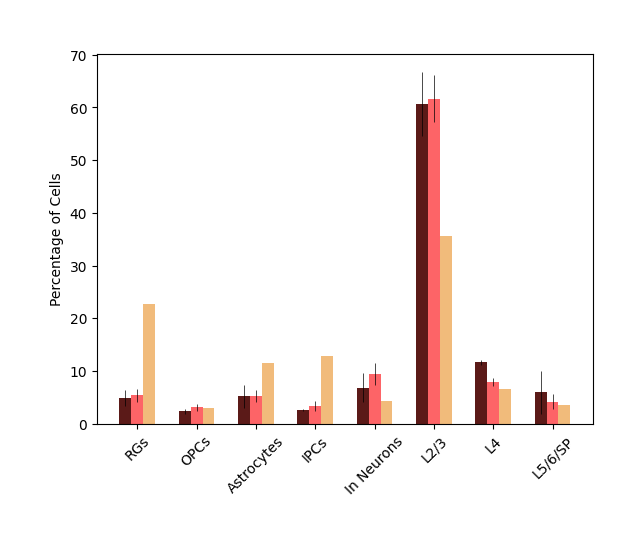

In [677]:
#Barplot of cell type proportions for each dataset
#Error calculated in 'strain_proportions_error.csv'
#strain_metadata.groupby('datasetid')['celltype'].value_counts().to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/strain_proportions_error.csv')

x = np.arange(8)
width= 0.20

sad_error = [1.305571354,0.679446084,1.114136055,0.996811688,2.068560815,4.510359902,0.747681196,1.445988536]
cvs_error = [1.570374313,0.474527418,2.116059492,0.173644045,2.748948484,6.084222012,0.481464784,4.017100444]


cvs=[(0.048311173)*100,(0.023843912)*100,(0.051555378)*100,(0.025609737)*100,(0.067887247)*100,(0.607144271)*100,(0.11637864)*100,(0.059269642)*100]
sad=[(0.053571009)*100,(0.030810061)*100,(0.052122707)*100,(0.033334234)*100,(0.093842389)*100,(0.616665832)*100,(0.078142455)*100,(0.041511313)*100]
uninfected=[(1687/7446)*100,(224/7446)*100,(863/7446)*100,(958/7446)*100,(313/7446)*100,(2648/7446)*100,(484/7446)*100,(269/7446)*100]

plt.bar(x-0.2, cvs,width, yerr=cvs_error,color='#5b1a18')
plt.bar(x, sad,width, yerr=sad_error,color='#fd6467') 
plt.bar(x+0.2, uninfected,width, color='#f1bb7b')

plt.xticks(x, ['RGs', 'OPCs', 'Astrocytes','IPCs','In Neurons','L2/3','L4','L5/6/SP'],rotation=45) 
#plt.xlabel("Cell Types")
plt.ylabel("Percentage of Cells") 
#plt.title('Cell Type Proportions')
#plt.legend(["Rabies+, Cell",'Helper+/Rabies+, Cell',"Rabies+, Nuc",'Helper+/Rabies+, Nuc'],loc='upper left',fontsize="10") 
plt.draw()
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/5_sad_cvs/cell_type_proportions.svg', bbox_inches='tight', format='svg')
plt.show()

odds ratio is : 13.055555555555555
p_value is : 8.781780091886628e-11
Success 95% CI
SADB19
ConfidenceInterval(low=0.0862479340483983, high=0.27867345316237774)
CVS
ConfidenceInterval(low=0.5944688763766685, high=0.8123074251901511)
Failure 95% CI
SADB19
ConfidenceInterval(low=0.7213265468376223, high=0.9137520659516021)
CVS
ConfidenceInterval(low=0.18769257480984877, high=0.40553112362333144)


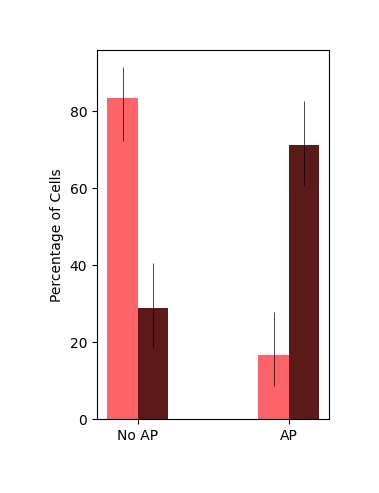

In [830]:
#Ephys bar plots
#Barplot of cell type proportions for each dataset

sad=[55,11]
cvs=[((21/73)*66),((52/73)*66)]
import scipy.stats as stats 
# creating data 
data = [sad, cvs] 
# performing fishers exact test on the data 
odd_ratio, p_value = stats.fisher_exact(data) 
print('odds ratio is : ' + str(odd_ratio)) 
print('p_value is : ' + str(p_value)) 
#post hoc fishers

plt.figure().set_figwidth(3)
x = np.arange(2)
width= 0.2

sad=[83.33333333,16.66666667]
cvs=[28.76712329,71.23287671]


#Clopper pearson error bars
print('Success 95% CI')
print('SADB19')
from scipy.stats import binomtest
result = binomtest(k=11, n=66, p=0.05)
print(result.proportion_ci())
print('CVS')
result = binomtest(k=52, n=73, p=0.05)
print(result.proportion_ci())

print('Failure 95% CI')
print('SADB19')
from scipy.stats import binomtest
result = binomtest(k=55, n=66, p=0.05)
print(result.proportion_ci())
print('CVS')
result = binomtest(k=21, n=73, p=0.05)
print(result.proportion_ci())


sad_lower_error = [(((55/66)*100)-(0.7213265468376223*100)),(((11/66)*100)-(0.0862479340483983*100))]
sad_upper_error = [((0.91375206595160213*100)-((55/66)*100)),((0.27867345316237774*100)-((11/66)*100))]
sad_asymmetric_error = [sad_lower_error, sad_upper_error]


cvs_lower_error = [(((21/73)*100)-(0.18769257480984877*100)),(((51/73)*100)-(0.5944688763766685*100))]
cvs_upper_error = [((0.40553112362333144*100)-((21/73)*100)),((0.8123074251901511*100)-((51/73)*100))]
cvs_asymmetric_error = [cvs_lower_error, cvs_upper_error]


plt.bar(x-0.1, sad,width, yerr=sad_asymmetric_error,color='#fd6467')
plt.bar(x+0.1, cvs,width, yerr=cvs_asymmetric_error,color='#5b1a18')


plt.xticks(x, ['No AP', 'AP']) 
#plt.xlabel("Cell Types")
plt.ylabel("Percentage of Cells") 
#plt.title('Cell Type Proportions')
#plt.legend(["Rabies+, Cell",'Helper+/Rabies+, Cell',"Rabies+, Nuc",'Helper+/Rabies+, Nuc'],loc='upper left',fontsize="10") 
plt.draw()
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/5_sad_cvs/ephys_proportions.svg', bbox_inches='tight', format='svg')
plt.show()

-79.4
-80.5
-18.1
-0.808008981
-43.4563566930137
-42.0546205
-37.757481178409094
-33.187382865000004
Wilcoxon Ranked Sum to compare distributions for RMP:
RanksumsResult(statistic=-2.0983904082986005, pvalue=0.035870671895691326)
Welchs T-test to compare means for RMP:
TtestResult(statistic=-1.8402752648309502, pvalue=0.06881762694409524, df=95.98958886110606)


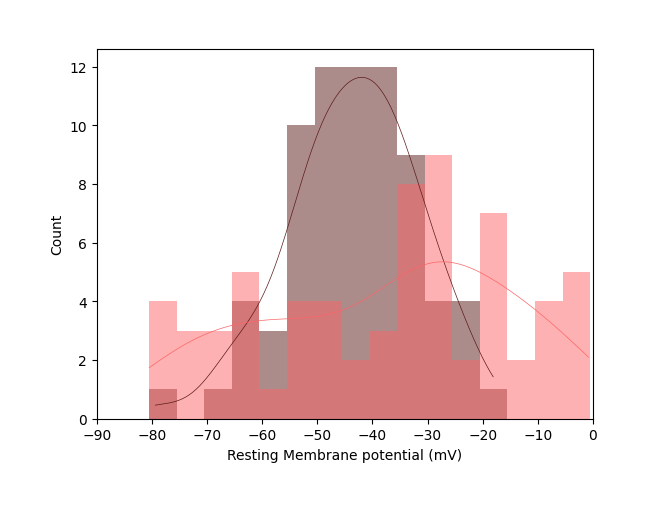

14.17865206
4.294007397
80.76
93.06751097
35.7332293449315
33.76
35.421828770333335
24.901320825
Wilcoxon Ranked Sum to compare distributions for CC:
RanksumsResult(statistic=1.7841590808247396, pvalue=0.0743978192808495)
Welchs T-test to compare means for CC:
TtestResult(statistic=0.09163595671989268, pvalue=0.9271698582340215, df=100.40604409511997)


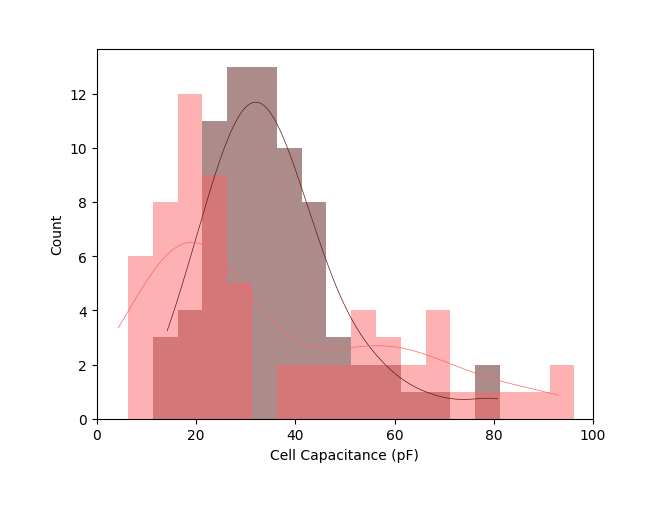

101.8
22.7
3638.193648
4412.458434
1077.1042893589042
930.6222163
1334.4172759833334
987.9733
Wilcoxon Ranked Sum to compare distributions for IR:
RanksumsResult(statistic=-0.3311028081435982, pvalue=0.7405668305707092)
Welchs T-test to compare means for IR:
TtestResult(statistic=-1.5724160536268446, pvalue=0.11887008712451838, df=104.74055277051731)


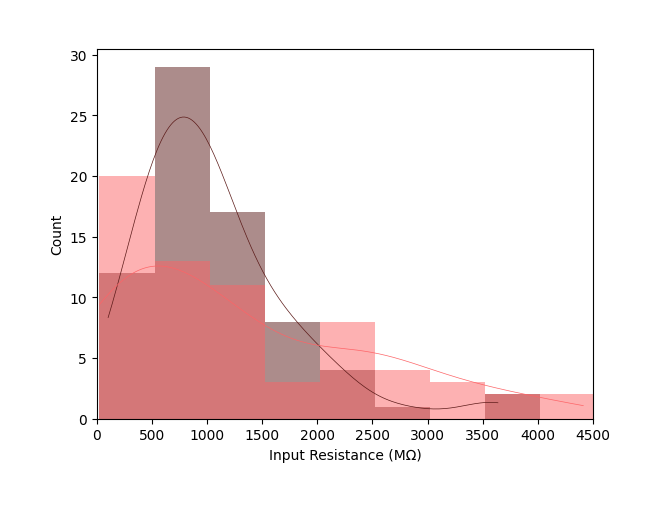

In [840]:
#Ephys variance plots
ephys=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/ephys_properties.csv',delimiter=',')
cvs_ephys=ephys.loc[ephys['strain'] == 'cvs']
sad_ephys=ephys.loc[ephys['strain'] == 'sad']

#RMP
print(cvs_ephys['Resting Membrane potential (mV)'].min())
print(sad_ephys['Resting Membrane potential (mV)'].min())
print(cvs_ephys['Resting Membrane potential (mV)'].max())
print(sad_ephys['Resting Membrane potential (mV)'].max())

print(cvs_ephys['Resting Membrane potential (mV)'].mean())
print(cvs_ephys['Resting Membrane potential (mV)'].median())

print(sad_ephys['Resting Membrane potential (mV)'].mean())
print(sad_ephys['Resting Membrane potential (mV)'].median())

print('Wilcoxon Ranked Sum to compare distributions for RMP:')
import numpy as np
from scipy.stats import ranksums
cvs_dist = cvs_ephys['Resting Membrane potential (mV)']
sad_dist = sad_ephys['Resting Membrane potential (mV)']
print(ranksums(cvs_dist, sad_dist))

print('Welchs T-test to compare means for RMP:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(cvs_dist, sad_dist,equal_var=False))

sns.histplot(data=cvs_ephys, x='Resting Membrane potential (mV)',binwidth=5, binrange=(-80.5, -2.0),kde=True,color='#5b1a18')
sns.histplot(data=sad_ephys, x='Resting Membrane potential (mV)', binwidth=5,binrange=(-80.5, -2.0),kde=True,color='#fd6467')

plt.xlim([-90, 0])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/5_sad_cvs/rmp_variance.svg', bbox_inches='tight', format='svg')
plt.show()

#CC
print(cvs_ephys['Cell Capacitance (pF)'].min())
print(sad_ephys['Cell Capacitance (pF)'].min())
print(cvs_ephys['Cell Capacitance (pF)'].max())
print(sad_ephys['Cell Capacitance (pF)'].max())

print(cvs_ephys['Cell Capacitance (pF)'].mean())
print(cvs_ephys['Cell Capacitance (pF)'].median())

print(sad_ephys['Cell Capacitance (pF)'].mean())
print(sad_ephys['Cell Capacitance (pF)'].median())

print('Wilcoxon Ranked Sum to compare distributions for CC:')
import numpy as np
from scipy.stats import ranksums
cvs_dist = cvs_ephys['Cell Capacitance (pF)']
sad_dist = sad_ephys['Cell Capacitance (pF)']
print(ranksums(cvs_dist, sad_dist))

print('Welchs T-test to compare means for CC:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(cvs_dist, sad_dist,equal_var=False))

sns.histplot(data=cvs_ephys, x='Cell Capacitance (pF)', binwidth=5, binrange=(6.289, 91.82),kde=True,color='#5b1a18')
sns.histplot(data=sad_ephys, x='Cell Capacitance (pF)', binwidth=5, binrange=(6.289, 91.82),kde=True,color='#fd6467')

plt.xlim([0, 100])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/5_sad_cvs/cc_variance.svg', bbox_inches='tight', format='svg')
plt.show()

#IR
print(cvs_ephys['Input Resistance (MΩ)'].min())
print(sad_ephys['Input Resistance (MΩ)'].min())
print(cvs_ephys['Input Resistance (MΩ)'].max())
print(sad_ephys['Input Resistance (MΩ)'].max())

print(cvs_ephys['Input Resistance (MΩ)'].mean())
print(cvs_ephys['Input Resistance (MΩ)'].median())

print(sad_ephys['Input Resistance (MΩ)'].mean())
print(sad_ephys['Input Resistance (MΩ)'].median())

print('Wilcoxon Ranked Sum to compare distributions for IR:')
import numpy as np
from scipy.stats import ranksums
cvs_dist = cvs_ephys['Input Resistance (MΩ)']
sad_dist = sad_ephys['Input Resistance (MΩ)']
print(ranksums(cvs_dist, sad_dist))

print('Welchs T-test to compare means for IR:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(cvs_dist, sad_dist,equal_var=False))

sns.histplot(data=cvs_ephys, x='Input Resistance (MΩ)', binwidth=500, binrange=(22.7, 4100.0),kde=True,color='#5b1a18')
sns.histplot(data=sad_ephys, x='Input Resistance (MΩ)', binwidth=500, binrange=(22.7, 4100.0),kde=True,color='#fd6467')


plt.xlim([0, 4500])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/5_sad_cvs/ir_variance.svg', bbox_inches='tight', format='svg')
plt.show()

In [ ]:
FOR NUC VS CELL COMPARISON

In [704]:
nuc_metadata=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/metadata.csv',delimiter=',')
cvs_datasets=['c1','c2','n1','n2']
nuc_metadata = nuc_metadata.loc[nuc_metadata['datasetid'].isin(cvs_datasets)]
print(nuc_metadata.groupby('modality')['celltype'].value_counts())


modality  celltype   
cell      L2/3           6615
          L4             1153
          In              884
          RG              383
          Astrocytes      378
          L5/6/SP         324
          Progenitors     249
          OPCs            210
nuc       L2/3            635
          RG              221
          L4              124
          In              122
          Progenitors      72
          L5/6/SP          53
          Astrocytes       42
          OPCs             38
Name: count, dtype: int64


In [705]:
n1_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/barcode_nuc/barcoded_fastqs/completecounts.tsv',delimiter='\t')
n2_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/barcode_nuc/barcoded_fastqs/completecounts.tsv',delimiter='\t')

c1_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/barcode_cell/barcoded_fastqs/completecounts.tsv',delimiter='\t')
c2_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/barcode_cell/barcoded_fastqs/completecounts.tsv',delimiter='\t')


n1_barcodes['CBC'] = n1_barcodes['CBC'].str.replace("'", "")
n1_barcodes['CBC'] = n1_barcodes['CBC'].str.replace('b', 'n1_')
n2_barcodes['CBC'] = n2_barcodes['CBC'].str.replace("'", "")
n2_barcodes['CBC'] = n2_barcodes['CBC'].str.replace('b', 'n2_')


c1_barcodes['CBC'] = c1_barcodes['CBC'].str.replace("'", "")
c1_barcodes['CBC'] = c1_barcodes['CBC'].str.replace('b', 'c1_')
c2_barcodes['CBC'] = c2_barcodes['CBC'].str.replace("'", "")
c2_barcodes['CBC'] = c2_barcodes['CBC'].str.replace('b', 'c2_')

nuc_barcodes = pd.concat([n1_barcodes, n2_barcodes], axis=0, ignore_index=True)
cell_barcodes = pd.concat([c1_barcodes, c2_barcodes], axis=0, ignore_index=True)
#cell_barcodes.drop(cell_barcodes[cell_barcodes['UMI_Count'] < 3].index, inplace=True)
#nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 3].index, inplace=True)
qc_nuc=nuc_metadata['cellbarcode']

In [706]:
summed_nuc=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_cell=cell_barcodes.groupby('CBC')['UMI_Count'].sum()

summed_nuc = pd.DataFrame(summed_nuc)
summed_cell = pd.DataFrame(summed_cell)

summed_nuc = summed_nuc.reset_index()
summed_cell = summed_cell.reset_index()


real_nuc = summed_nuc.loc[summed_nuc['CBC'].isin(qc_nuc)]
real_cell = summed_cell.loc[summed_cell['CBC'].isin(qc_nuc)]

In [707]:
print('Set bins for nuc:')
print((np.log10(nuc_barcodes['UMI_Count'])).min())
print((np.log10(nuc_barcodes['UMI_Count'])).max())
print('Set bins for cell:')
print((np.log10(cell_barcodes['UMI_Count'])).min())
print((np.log10(cell_barcodes['UMI_Count'])).max())
print()

#import numpy as np
#from scipy.stats import ranksums

nuc_dist = nuc_barcodes['UMI_Count']
cell_dist = cell_barcodes['UMI_Count']

nuc_dist.to_csv('/Users/maddieurbanek/Desktop/nuc_dist.csv')
cell_dist.to_csv('/Users/maddieurbanek/Desktop/cell_dist.csv')

print('Nuc mean:')
print(nuc_dist.mean())
print('Nuc median:')
print(nuc_dist.median())
print('Nuc SEM:')
print(nuc_dist.sem())
print('Cell mean:')
print(cell_dist.mean())
print('Cell median:')
print(cell_dist.median())
print('Cell SEM:')
print(cell_dist.sem())

print('Wilcoxon Ranked Sum Results:')
print(ranksums(nuc_dist, cell_dist))
print(len(cell_dist))
print(len(nuc_dist))

Set bins for nuc:
0.0
2.9355072658247128
Set bins for cell:
0.0
3.718916686014861

Nuc mean:
1.072338692428966
Nuc median:
1.0
Nuc SEM:
0.00021387345496609903
Cell mean:
1.3631104821060986
Cell median:
1.0
Cell SEM:
0.002994061161106815
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-310.80054978231743, pvalue=0.0)
10618534
11814991


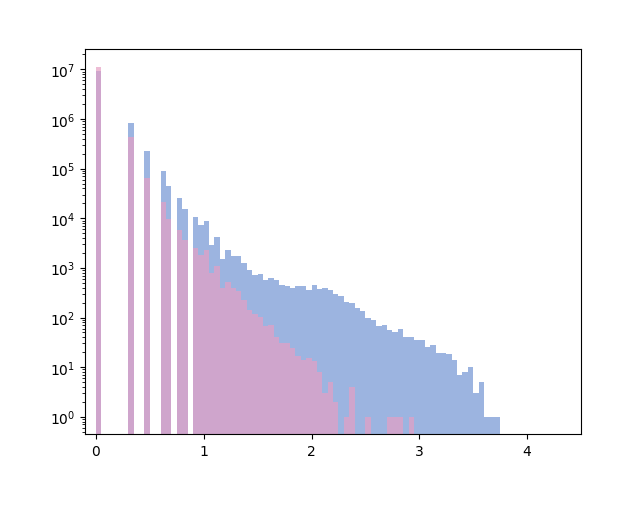

In [708]:
plt.figure().set_figheight(5)
plt.hist(np.log10(cell_barcodes['UMI_Count']),bins=np.arange(0, 3.718916686014861 + .05, .05),color='#7294d4',alpha=0.7)
plt.hist(np.log10(nuc_barcodes['UMI_Count']),bins=np.arange(0, 2.9355072658247128 + .05, .05),color='#e6a0c4',alpha=0.7)

#plt.xlabel('UMIs per Barcode:CBC Combo')
#plt.ylabel('Frequency')
plt.xlim([-.1, 4.5])
plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/6_cell_nuc/combo_dist.svg', bbox_inches='tight', format='svg')
plt.show()

In [709]:
print('Set bins for nuc:')
print((np.log10(real_nuc['UMI_Count'])).min())
print((np.log10(real_nuc['UMI_Count'])).max())
print('Set bins for cell:')
print((np.log10(real_cell['UMI_Count'])).min())
print((np.log10(real_cell['UMI_Count'])).max())


print()
print('Wilcoxon Ranked Sum to compare distributions:')

import numpy as np
#import scipy
#from scipy.stats import ranksums

nuc_dist = real_nuc['UMI_Count']
cell_dist = real_cell['UMI_Count']

nuc_dist.to_csv('/Users/maddieurbanek/Desktop/total_nuc_dist.csv')
cell_dist.to_csv('/Users/maddieurbanek/Desktop/total_cell_dist.csv')

print('Nuc mean:')
print((nuc_dist.mean()))
print('Nuc median:')
print((nuc_dist.median()))
print('Nuc SEM:')
print(nuc_dist.sem())
print('Cell mean:')
print(cell_dist.mean())
print('Cell median:')
print((cell_dist.median()))
print('Cell SEM:')
print(cell_dist.sem())

from scipy.stats import ranksums
print('Wilcoxon Ranked Sum Results:')
print(ranksums(nuc_dist, cell_dist))
print(len(nuc_dist))
print(len(cell_dist))

#print('IQR for nuclei')
#print(iqr(nuc_dist))

#print('IQR for cells')
#print(iqr(cell_dist))

Set bins for nuc:
1.2041199826559248
3.4837298990000236
Set bins for cell:
1.5185139398778875
3.8171685723810556

Wilcoxon Ranked Sum to compare distributions:
Nuc mean:
153.1469013006886
Nuc median:
120.0
Nuc SEM:
4.128119540412135
Cell mean:
220.09121224009417
Cell median:
135.0
Cell SEM:
3.235844526981215
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-9.896404161194855, pvalue=4.3151175946649126e-23)
1307
10196


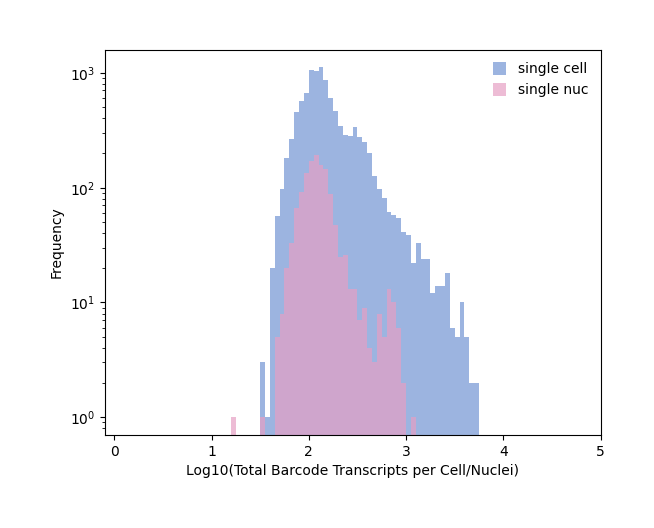

In [710]:
plt.figure().set_figheight(5)
#Set bins to the max values printed above
#Pre-thresholded distribution of barcode UMI counts
plt.hist((np.log10(real_cell['UMI_Count'])),bins=np.arange(0, 3.7712934426290596 + .01, .05),alpha=0.7,color='#7294d4',label='single cell')
plt.hist((np.log10(real_nuc['UMI_Count'])),bins=np.arange(0, 3.109240968588203 + .01, .05),color='#e6a0c4',alpha=0.7, label= 'single nuc')
plt.xlim([-.1, 5])
plt.legend(loc='upper right')
plt.xlabel('Log10(Total Barcode Transcripts per Cell/Nuclei)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/6_cell_nuc/barcode_capture.svg', bbox_inches='tight', format='svg')
plt.show()


SignificanceResult(statistic=0.9432363102106899, pvalue=0.0)
Nuc r_squared:
SignificanceResult(statistic=0.8284164188602785, pvalue=0.0)
Cell r_squared:


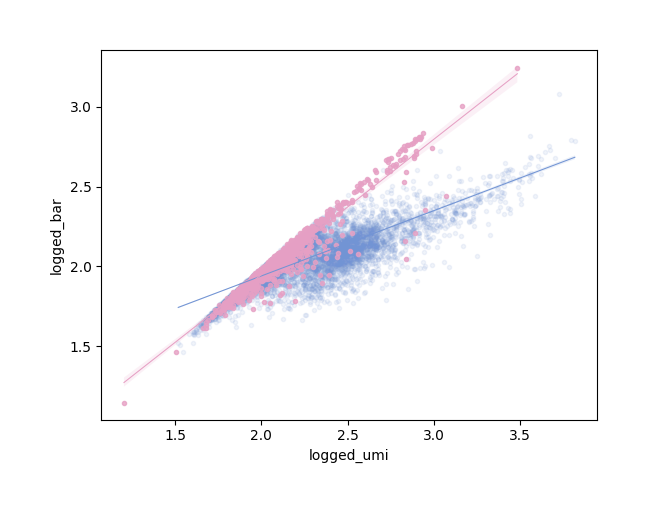

In [711]:
#Barcode Inflation QC w/ thresholded dataset
#Barcode UMIs per cell vs. Unique barcodes per cell
real_nuc = nuc_barcodes.loc[nuc_barcodes['CBC'].isin(qc_nuc)]
real_cell = cell_barcodes.loc[cell_barcodes['CBC'].isin(qc_nuc)]

nuc_total_umis=(real_nuc.groupby(['CBC'], as_index=False)['UMI_Count'].sum())
nuc_uniq_bcs=(real_nuc.groupby(['CBC'], as_index=False)['barcode'].nunique())

nuc_mergeddf = pd.merge(nuc_total_umis, nuc_uniq_bcs, on ='CBC')

cell_total_umis=(real_cell.groupby(['CBC'], as_index=False)['UMI_Count'].sum())
cell_uniq_bcs=(real_cell.groupby(['CBC'], as_index=False)['barcode'].nunique())

cell_mergeddf = pd.merge(cell_total_umis, cell_uniq_bcs, on ='CBC')

# plot 1 with axes level-plot
nuc_mergeddf['logged_umi']=np.log10(nuc_mergeddf['UMI_Count'])
nuc_mergeddf['logged_bar']=np.log10(nuc_mergeddf['barcode'])
#ax = sns.regplot(data=nuc_mergeddf, x='logged_umi', y='logged_bar', color = '#e6a0c4')

cell_mergeddf['logged_umi']=np.log10(cell_mergeddf['UMI_Count'])
cell_mergeddf['logged_bar']=np.log10(cell_mergeddf['barcode'])
sns.regplot(data=cell_mergeddf, x='logged_umi', y='logged_bar', color = '#7294d4',scatter_kws={'alpha':0.1})
ax=sns.regplot(data=nuc_mergeddf, x='logged_umi', y='logged_bar', color = '#e6a0c4')


#ax.figure.savefig("/Users/maddieurbanek/Desktop/neuron_submission/6_cell_nuc/logged_inflation.svg")

#corr_matrix = np.corrcoef(np.log10(nuc_mergeddf['UMI_Count']), np.log10(nuc_mergeddf['barcode']))
print(scipy.stats.spearmanr(np.log10(nuc_mergeddf['UMI_Count']), np.log10(nuc_mergeddf['barcode']),nan_policy="omit"))
#print(0.9523766792293984**2)
corr = corr_matrix[0,1]
R_sq = corr**2
print('Nuc r_squared:')
print(R_sq)

#corr_matrix = np.corrcoef(np.log10(cell_mergeddf['UMI_Count']), np.log10(cell_mergeddf['barcode']))
print(scipy.stats.spearmanr(np.log10(cell_mergeddf['UMI_Count']), np.log10(cell_mergeddf['barcode']),nan_policy="omit"))
print('Cell r_squared:')
#print(0.8138803974603327**2)
corr = corr_matrix[0,1]
R_sq = corr**2
print('Cell r_squared:')
print(R_sq)

In [ ]:
CONNECTIVITY ANALYSIS PART 1

In [823]:
#Connectivity analysis (w/ conservative barcode calling)
metadata=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/metadata.csv',delimiter=',')
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/thresholded_barcodes.csv',delimiter=',')
foundercells=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/thresholded_helpers.csv',delimiter=',')
barcodes.drop(barcodes[barcodes['UMI_Count'] < 3].index, inplace=True)
barcodes = barcodes[barcodes['CBC'].isin(metadata['cellbarcode'])]
foundercells.drop(foundercells[foundercells['UMI_Count'] < 3].index, inplace=True)
print(len(barcodes))
l23=metadata.loc[metadata['celltype'] == 'L2/3', 'cellbarcode']
l4=metadata.loc[metadata['celltype'] == 'L4', 'cellbarcode']
rg=metadata.loc[metadata['celltype'] == 'RG', 'cellbarcode']
inh=metadata.loc[metadata['celltype'] == 'In', 'cellbarcode']
pro=metadata.loc[metadata['celltype'] == 'Progenitors', 'cellbarcode']
ast=metadata.loc[metadata['celltype'] == 'Astrocytes', 'cellbarcode']
l56sp=metadata.loc[metadata['celltype'] == 'L5/6/SP', 'cellbarcode']
opcs=metadata.loc[metadata['celltype'] == 'OPCs', 'cellbarcode']

barcodes['celltype'] = barcodes.loc[:, 'CBC']
barcodes.loc[barcodes['CBC'].isin(l23), 'celltype'] = 'L2/3'
barcodes.loc[barcodes['CBC'].isin(l4), 'celltype'] = 'L4'
barcodes.loc[barcodes['CBC'].isin(rg), 'celltype'] = 'RG'
barcodes.loc[barcodes['CBC'].isin(inh), 'celltype'] = 'In'
barcodes.loc[barcodes['CBC'].isin(pro), 'celltype'] = 'Progenitors'
barcodes.loc[barcodes['CBC'].isin(ast), 'celltype'] = 'Astrocytes'
barcodes.loc[barcodes['CBC'].isin(l56sp), 'celltype'] = 'L5/6/SP'
barcodes.loc[barcodes['CBC'].isin(opcs), 'celltype'] = 'OPCs'
actualbarcodes = barcodes[barcodes.duplicated(subset=['barcode'], keep=False)]
print('Total number of barcodes with at least one pair:')
print(len(actualbarcodes))

actualbarcodes['helper'] = actualbarcodes.loc[:, 'CBC']
foundercells=foundercells['CBC']
print('Number of founders in dataset:')
print(len(foundercells))
print('Total number of cells with barcodes in dataset:')
print(actualbarcodes['CBC'].nunique())
actualbarcodes.loc[actualbarcodes['CBC'].isin(foundercells), 'helper'] = 'founder'
actualbarcodes.loc[~actualbarcodes['CBC'].isin(foundercells), 'helper'] = 'presynaptic'


cellprops=actualbarcodes.groupby(['celltype','helper','datasetid'])['CBC'].nunique()
#actualbarcodes.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/finalized_barcodes.csv')
#cellprops.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/connectivity_proportions_table.csv')

182495
Total number of barcodes with at least one pair:
175564
Number of founders in dataset:
2478
Total number of cells with barcodes in dataset:
15786


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/1673369525.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actualbarcodes['helper'] = actualbarcodes.loc[:, 'CBC']


KeyError: 'datasetid'

In [486]:
#Chi-squared analysis of cell type proportions for presynaptic vs helper

import numpy as np
f_exp = np.array([(763/14582)*1204,(349/14582)*1204,(611/14582)*1204,(424/14582)*1204,(1314/14582)*1204,(9072/14582)*1204,(1496/14582)*1204,(553/14582)*1204]) 
f_obs = np.array([48,24,63,22,58,795,118,76])
from scipy.stats import chisquare

print('Chi-squared results:')
print(chisquare(f_obs=f_obs, f_exp=f_exp))

print("Post hoc w/ Bonferroni Correction:")
print("RG:")
print("Chi-squared stat:")
print(((48-((763/14582)*1204))**2)/((763/14582)*1204))




Chi-squared results:
Power_divergenceResult(statistic=59.05820460018688, pvalue=2.3268310887374083e-10)
Post hoc w/ Bonferroni Correction:
RG:
Chi-squared stat:
3.571025822010107


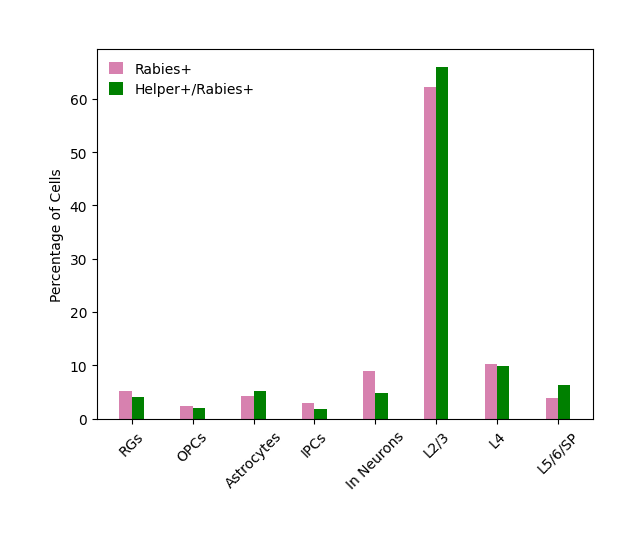

In [462]:
#Barplot of cell type proportions for each dataset
x = np.arange(8)
width= 0.20

cell_error = [1.570374313,0.474527418,2.116059492,0.173644045,2.748948484,6.084222012,0.481464784,4.017100444]
nuc_error = [3.106263034,0.541335375,1.633917709,1.001069908,0.774461244,0.233804745,1.06352646,0.591572167]


infected=[(763/14582)*100,(349/14582)*100,(611/14582)*100,(424/14582)*100,(1314/14582)*100,(9072/14582)*100,(1496/14582)*100,(553/14582)*100]
founder=[(48/1204)*100,(24/1204)*100,(63/1204)*100,(22/1204)*100,(58/1204)*100,(795/1204)*100,(118/1204)*100,(76/1204)*100]

lt.bar(x-0.1, cell,width,yerr=cell_error, color='#7294d4')
plt.bar(x-0.1, infected,width, color='#d781af')
plt.bar(x+0.1, founder,width, color='green') 

plt.xticks(x, ['RGs', 'OPCs', 'Astrocytes','IPCs','In Neurons','L2/3','L4','L5/6/SP'],rotation=45) 
#plt.xlabel("Cell Types")
plt.ylabel("Percentage of Cells") 
#plt.title('Cell Type Proportions')
plt.legend(["Rabies+",'Helper+/Rabies+'],loc='upper left',fontsize="10") 
plt.draw()
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/7_barcode_qc/cell_type_proportions.svg', bbox_inches='tight', format='svg')
plt.show()

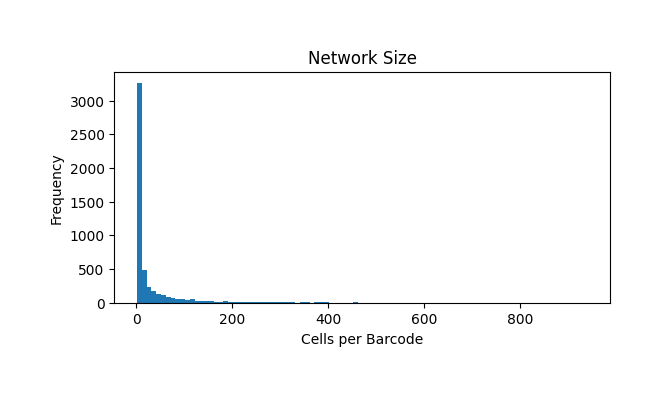

In [848]:
#Plot network size (number of cells per barcode)
actualbarcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/finalized_barcodes.csv',delimiter=',')
cellcounts= actualbarcodes.groupby('barcode')['CBC'].count()
plt.figure().set_figheight(3)
plt.hist((cellcounts),bins=range(1, 942 + 3, 10))

#plt.hist(np.log10(umisreads['count']), bins = 500)
#plt.axis([-.1, 1000, 0, 10000])
plt.xlabel('Cells per Barcode')
plt.ylabel('Frequency')
#plt.yscale('log')
plt.title('Network Size')


#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/network_size_dist.svg', bbox_inches='tight', format='svg')
plt.show()

cellcounts.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/network_size_distribution.csv')

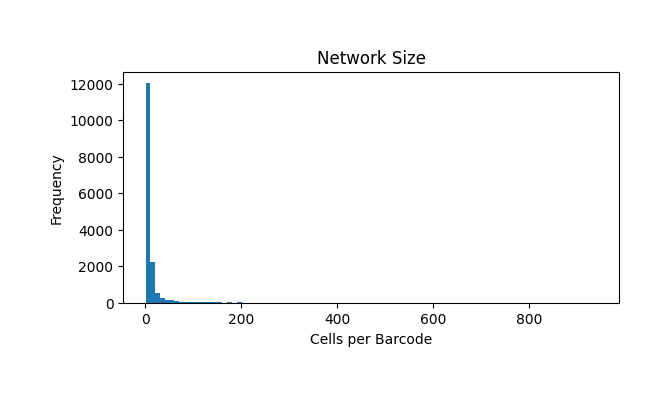

In [849]:
#Plot barcodes per cell
#Plot network size (number of cells per barcode)
actualbarcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/finalized_barcodes.csv',delimiter=',')
cellcounts= actualbarcodes.groupby('CBC')['barcode'].count()
plt.figure().set_figheight(3)
plt.hist((cellcounts),bins=range(1, 942 + 3, 10))

#plt.hist(np.log10(umisreads['count']), bins = 500)
#plt.axis([-.1, 1000, 0, 10000])
plt.xlabel('Barcodes per Cell')
plt.ylabel('Frequency')
#plt.yscale('log')
plt.title('Barcodes per Cell')


#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/network_size_dist.svg', bbox_inches='tight', format='svg')
plt.show()

cellcounts.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/barcodes_per_cell_distribution.csv')

In [850]:
#Pull networks w/ founders
dualfounder=actualbarcodes.copy()
dualfounder.drop(dualfounder[dualfounder['helper'] == 'presynaptic'].index, inplace=True)
dualfounder = dualfounder['barcode'].value_counts().reset_index()
dualfounder.columns=['barcode','count']
print('Set bins in next cell to this number:')
print(dualfounder['count'].max())

Set bins in next cell to this number:
159


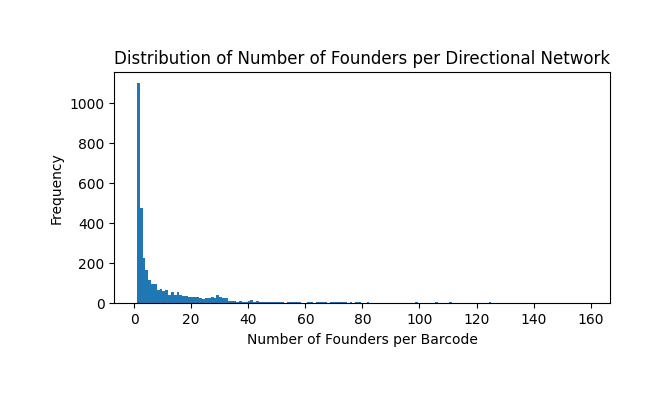

In [852]:
#Plot number of founders per network
###
plt.figure().set_figheight(3)
plt.hist(dualfounder['count'],bins=159)
###
plt.xlabel('Number of Founders per Barcode')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Founders per Directional Network')

#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/dist_founders_per_directional_network.svg', bbox_inches='tight', format='svg')
plt.show()

dualfounder.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/founders_per_network_distrbution.csv')

In [21]:
#Drop all networks with more than one founder
dualfounder.drop(dualfounder[dualfounder['count'] > 1].index, inplace=True)
actualbarcodes = actualbarcodes.loc[actualbarcodes['barcode'].isin(dualfounder['barcode'])]

#Directional network analysis
directional_barcodes=actualbarcodes.query("helper=='founder'")["barcode"]
print('Number of directional networks:')
print(directional_barcodes.nunique())
mask = actualbarcodes['barcode'].isin(directional_barcodes)

#subset big dataframe down to just cells matched to a founder:
#directional_networks=actualbarcodes
mask = actualbarcodes['barcode'].isin(directional_barcodes)
directional_networks = actualbarcodes[mask]

###
directional_networks.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/directional_networks.csv')
###

Number of directional networks:
1102


         Unnamed: 0                  CBC  \
195           22031  n1_CCAACCGCAACCACTA   
231           22546  n1_CCGCCCGCAACTAAAT   
246           23461  n1_CACCAGACAACAATAC   
262           24834  n1_CCGAACTCAAGTAAGA   
268           25228  n1_ACCGATCACATAACGC   
...             ...                  ...   
2470578    37103977  s5_AAGTAGGTAAAGCACC   
2471565    37129523  s5_AATCATACATTTACAG   
2471575    37130152  s5_AGATAGGGACCGAGCT   
2479299    37247904  s5_CAGGACCCACTGAACC   
2479305    37248816  s5_CCGGACTTAAAGCCCT   

                                                   barcode  UMI_Count  \
195      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          4   
231      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          4   
246      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          6   
262      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          3   
268      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          4   
...                              

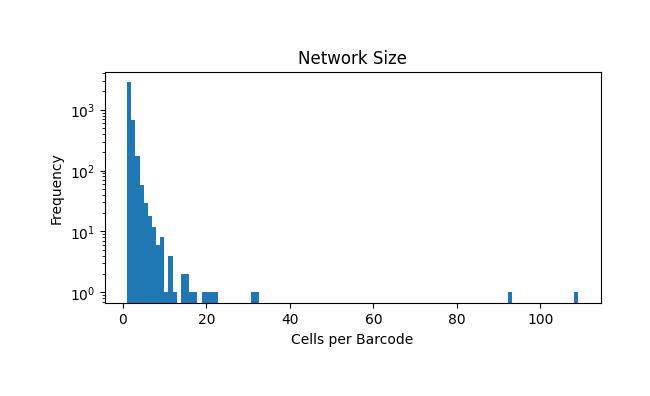

In [489]:
#Plot network size (number of cells per barcode) for directional
print(actualbarcodes)
cellcounts= directional_networks.groupby('CBC')['barcode'].count()
print(cellcounts.max())
plt.figure().set_figheight(3)
plt.hist((cellcounts),bins=109)
#bins?
#plt.hist(np.log10(umisreads['count']), bins = 500)
#plt.axis([-.05, 1, 1, 10000000])
plt.xlabel('Cells per Barcode')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Network Size')


plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/directional_network_size_dist.svg', bbox_inches='tight', format='svg')

plt.show()

         Unnamed: 0                  CBC  \
195           22031  n1_CCAACCGCAACCACTA   
231           22546  n1_CCGCCCGCAACTAAAT   
246           23461  n1_CACCAGACAACAATAC   
262           24834  n1_CCGAACTCAAGTAAGA   
268           25228  n1_ACCGATCACATAACGC   
...             ...                  ...   
2470578    37103977  s5_AAGTAGGTAAAGCACC   
2471565    37129523  s5_AATCATACATTTACAG   
2471575    37130152  s5_AGATAGGGACCGAGCT   
2479299    37247904  s5_CAGGACCCACTGAACC   
2479305    37248816  s5_CCGGACTTAAAGCCCT   

                                                   barcode  UMI_Count  \
195      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          4   
231      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          4   
246      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          6   
262      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          3   
268      n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...          4   
...                              

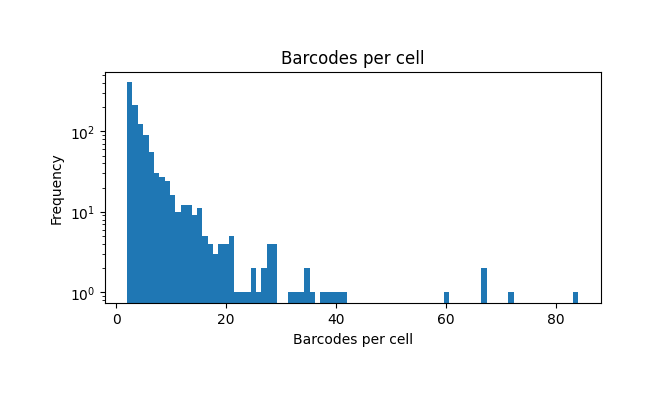

In [490]:
#Plot barcode per cell distribution (number of cells per barcode) for directional
print(actualbarcodes)
cellcounts= directional_networks.groupby('barcode')['CBC'].count()
print(cellcounts.max())
plt.figure().set_figheight(3)
plt.hist((cellcounts),bins=84)
#bins?
#plt.hist(np.log10(umisreads['count']), bins = 500)
#plt.axis([-.05, 1, 1, 10000000])
plt.xlabel('Barcodes per cell')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Barcodes per cell')


plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/directional_barcodes_per_cell_dist.svg', bbox_inches='tight', format='svg')
plt.show()

In [83]:
#Connectivity analysis for single founder networks
working_networks=directional_networks.copy(deep=True)
founders=directional_networks.copy(deep=True)
founders.drop(founders[founders['helper'] == 'presynaptic'].index, inplace=True)
founder_types = founders[['CBC',"barcode", "celltype"]]
working_networks=pd.merge(working_networks,founder_types, on='barcode')          
working_networks.drop(working_networks[working_networks['helper'] == 'founder'].index, inplace=True)
working_networks['cbc_combo']=working_networks["CBC_x"] + working_networks["CBC_y"]
working_networks=working_networks.drop_duplicates(subset='cbc_combo', keep="first")
working_networks['connection'] = working_networks[['celltype_x', 'celltype_y']].agg('-'.join, axis=1)

working_networks.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/single_founder_deduplicated_networks.csv')
directional_connection_counts=working_networks['connection'].value_counts()
print(directional_connection_counts)
directional_connection_counts.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/directional_connection_matrix.csv')

connection
L2/3-L2/3                 2039
L4-L2/3                    285
L2/3-L4                    236
In-L2/3                    229
L2/3-L5/6/SP               208
L2/3-In                    206
L5/6/SP-L2/3               132
RG-L2/3                    131
Astrocytes-L2/3            128
Progenitors-L2/3            72
OPCs-L2/3                   71
In-In                       60
In-L4                       41
L4-L4                       40
L4-L5/6/SP                  38
RG-In                       35
L5/6/SP-L5/6/SP             32
L2/3-RG                     32
L4-In                       30
L2/3-Astrocytes             29
Progenitors-In              28
In-L5/6/SP                  26
Astrocytes-In               21
Astrocytes-L5/6/SP          17
L2/3-OPCs                   17
RG-L5/6/SP                  14
L2/3-Progenitors            12
L5/6/SP-L4                  12
Astrocytes-L4                9
RG-RG                        9
RG-L4                        9
L5/6/SP-In                  

In [89]:
#Plotting directional barcodes
#Connectivity circos plot w/ arrows
from pycirclize import Circos
import pandas as pd

row_names = ['RG','OPCs','Astrocytes','Progenitors','In','L2/3','L4','L5/6/SP']
col_names = ['RG','OPCs','Astrocytes','Progenitors','In','L2/3','L4','L5/6/SP']
matrix_data = [
    [9,1,2,1,35,131,9,14],
    [3,2,3,1,3,71,3,7],
    [1,1,7,2,21,128,9,17],
    [3,0,0,0,28,72,7,3],
    [5,3,1,3,60,229,41,26],
    [32,17,29,12,206,2039,236,208],
    [2,2,0,3,30,285,40,38],
    [1,2,4,0,8,132,12,32],
]
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)
# Initialize Circos from matrix for plotting Chord Diagram
circos = Circos.initialize_from_matrix(
    matrix_df,
    space=5,
    cmap="tab10",
    label_kws=dict(size=12),
    link_kws=dict(ec="black", lw=0.5, direction=1),
)
circos.savefig("/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/directional_circos.svg")


#Sankey for directional networks
import plotly.graph_objects as go
from kaleido import *
fig = go.Figure(go.Sankey(
    arrangement='snap',
    node=dict(
        label=['RG','OPCs','Astrocytes','Progenitors','In','L2/3','L4','L5/6/SP'],
        x=[0, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7],
        y=[0, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7],
        pad=10  
    ),
    link=dict(
        arrowlen=15,
        source=[0, 1, 2,3,4,5,6,7,0, 1, 2,3,4,5,6,7,0, 1, 2,3,4,5,6,7,0, 1, 2,3,4,5,6,7,0, 1, 2,3,4,5,6,7,0, 1, 2,3,4,5,6,7,0, 1, 2,3,4,5,6,7,0, 1, 2,3,4,5,6,7,],
        target=[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7],
        value=[9,1,2,1,35,131,9,14,3,2,3,1,3,71,3,7,1,1,7,2,21,128,9,17,3,0,0,0,28,72,7,3,5,3,1,3,60,229,41,26,32,17,29,12,206,2039,236,208,2,2,0,3,30,285,40,38,1,2,4,0,8,132,12,32]  
    )
))

fig.show()
fig.write_image("/Users/maddieurbanek/Desktop/trial.svg")

In [350]:
#Get uninfected cell type proportions
uninfected=metadata.loc[metadata['datasetid'] == 'u1']
print(uninfected)
base_props=uninfected.groupby(['celltype'])['cellbarcode'].nunique()
base_props.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv')


                Unnamed: 0     orig.ident  nCount_RNA  nFeature_RNA  \
17343  u1_AAAAAAACCCGAATAA  SeuratProject        3434          1812   
17344  u1_AAAAAAAGATCGACAC  SeuratProject        2173          1165   
17345  u1_AAAAAAAGCCAGCCTG  SeuratProject        2065          1213   
17346  u1_AAAAAAATCATGAATG  SeuratProject        2134          1269   
17347  u1_AAAAAACCAAAACACT  SeuratProject        4806          2052   
...                    ...            ...         ...           ...   
24784  u1_CCTTCCGAAATGCAAA  SeuratProject        2561          1371   
24785  u1_CCTTCCGCACCTAGGC  SeuratProject        2595          1251   
24786  u1_CCTTCCTAACGACCCT  SeuratProject        1636          1048   
24787  u1_CCTTCCTAATACACTT  SeuratProject        4148          2023   
24788  u1_CCTTCCTCCATCAATA  SeuratProject        2807          1555   

       percent.mt datasetid       virus modality      age  \
17343    3.480041        u1  uninfected     cell  gw16-21   
17344    3.007798        

In [377]:
#Simulate bootstrapped random connectivity from uninfected cell types
#base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
#base_props = pd.DataFrame(base_props)
#base_props = base_props.reset_index()

for l in range(0,1):    
    for n in range(0,100):
        base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
        partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
        partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
        bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
        bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
        bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
        bootstrapped_counts.columns=['celltypes','count']
        bootstrapped_counts.set_index('celltypes', inplace=True)
    simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)    
    #simulated_connectivity=simulated_connectivity.merge(bootstrapped_counts, how='outer')
#print(bootstrapped_counts)
simulated_connectivity=simulated_connectivity.fillna(0)
print(simulated_connectivity)

                       count  count  count  count  count  count  count  count  \
celltypes                                                                       
Astrocytes-Astrocytes     58    134    196    253    306    374    430    484   
Astrocytes-In             13     29     53     73     87    109    142    165   
Astrocytes-L2/3          198    370    548    733    898   1094   1265   1454   
Astrocytes-L4             34     66     91    121    152    188    226    264   
Astrocytes-L5/6/SP        16     35     47     63     82    103    124    132   
...                      ...    ...    ...    ...    ...    ...    ...    ...   
RG-L4                     66    143    197    269    320    386    447    512   
RG-L5/6/SP                35     68    102    138    175    212    250    285   
RG-OPCs                   36     73    106    125    152    189    224    251   
RG-Progenitors           125    243    379    487    603    724    849    955   
RG-RG                    227

In [432]:
#Bootstrapping random connectivity based on total number of pairs:
import time
starttime = time.time()


simulated_connectivity = pd.DataFrame({
   'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG',

'In-Astrocytes',
'In-In',
'In-L2/3',
'In-L4',
'In-L5/6/SP',
'In-OPCs',
'In-Progenitors',
'In-RG',

'L2/3-Astrocytes',
'L2/3-In',
'L2/3-L2/3',
'L2/3-L4',
'L2/3-L5/6/SP',
'L2/3-OPCs',
'L2/3-Progenitors',
'L2/3-RG',

'L4-Astrocytes',
'L4-In',
'L4-L2/3',
'L4-L4',
'L4-L5/6/SP',
'L4-OPCs',
'L4-Progenitors',
'L4-RG',

'L5/6/SP-Astrocytes',
'L5/6/SP-In',
'L5/6/SP-L2/3',
'L5/6/SP-L4',
'L5/6/SP-L5/6/SP',
'L5/6/SP-OPCs',
'L5/6/SP-Progenitors',
'L5/6/SP-RG',

'OPCs-Astrocytes',
'OPCs-In',
'OPCs-L2/3',
'OPCs-L4',
'OPCs-L5/6/SP',
'OPCs-OPCs',
'OPCs-Progenitors',
'OPCs-RG',

'Progenitors-Astrocytes',     
'Progenitors-In',
'Progenitors-L2/3',
'Progenitors-L4',
'Progenitors-L5/6/SP',
'Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG',

'RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
})
#simulated_connectivity.columns=['start']
simulated_connectivity.set_index('celltypes', inplace=True)

base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
base_props = pd.DataFrame(base_props)
base_props = base_props.reset_index()
bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
partner=pd.DataFrame(columns=['pre','post'])

for l in range(0,10):    
    for n in range(0,1000):
        base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
        partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
        partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
        bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
        bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
        bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
        bootstrapped_counts.columns=['celltypes','count']
        bootstrapped_counts.set_index('celltypes', inplace=True)
    simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)     
    #simulated_connectivity=simulated_connectivity.merge(bootstrapped_counts, how='outer')
#print(bootstrapped_counts)
simulated_connectivity=simulated_connectivity.fillna(0)
#simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/simulated_connectivity_3.csv')
print('Done bootstrapping! :)')
endtime = time.time()
print(endtime-starttime)

Done bootstrapping! :)
179.58817267417908


In [429]:
#Bootstrapping random connectivity based on total number of pairs:
uninfected=metadata.loc[metadata['datasetid'] == 'u1']
base_props=uninfected.groupby(['celltype'])['cellbarcode'].nunique()
base_props.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv')
base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
base_props = pd.DataFrame(base_props)
base_props = base_props.reset_index()

base_props = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)


simulated_connectivity = pd.DataFrame({
   'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG',

'In-Astrocytes',
'In-In',
'In-L2/3',
'In-L4',
'In-L5/6/SP',
'In-OPCs',
'In-Progenitors',
'In-RG',

'L2/3-Astrocytes',
'L2/3-In',
'L2/3-L2/3',
'L2/3-L4',
'L2/3-L5/6/SP',
'L2/3-OPCs',
'L2/3-Progenitors',
'L2/3-RG',

'L4-Astrocytes',
'L4-In',
'L4-L2/3',
'L4-L4',
'L4-L5/6/SP',
'L4-OPCs',
'L4-Progenitors',
'L4-RG',

'L5/6/SP-Astrocytes',
'L5/6/SP-In',
'L5/6/SP-L2/3',
'L5/6/SP-L4',
'L5/6/SP-L5/6/SP',
'L5/6/SP-OPCs',
'L5/6/SP-Progenitors',
'L5/6/SP-RG',

'OPCs-Astrocytes',
'OPCs-In',
'OPCs-L2/3',
'OPCs-L4',
'OPCs-L5/6/SP',
'OPCs-OPCs',
'OPCs-Progenitors',
'OPCs-RG',

'Progenitors-Astrocytes',     
'Progenitors-In',
'Progenitors-L2/3',
'Progenitors-L4',
'Progenitors-L5/6/SP',
'Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG',

'RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
})
#simulated_connectivity.columns=['start']
simulated_connectivity.set_index('celltypes', inplace=True)

base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
base_props = pd.DataFrame(base_props)
base_props = base_props.reset_index()
bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
partner=pd.DataFrame(columns=['pre','post'])

for l in range(0,10):    
    for n in range(0,100):
        base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
        partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
        partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
        bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
        bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
        bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
        bootstrapped_counts.columns=['celltypes','count']
        bootstrapped_counts.set_index('celltypes', inplace=True)
    simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)     
    #simulated_connectivity=simulated_connectivity.merge(bootstrapped_counts, how='outer')
#print(bootstrapped_counts)
simulated_connectivity=simulated_connectivity.fillna(0)
#simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/simulated_connectivity_3.csv')
print('Done bootstrapping! :)')

Done bootstrapping! :)


In [ ]:
BARCODE DIVERSITY

In [ ]:
#plasmid comparisons
c_2=pd.read_table('/Users/maddieurbanek/Downloads/cvs_completecounts.tsv',delimiter='\t')
c_1=pd.read_table('/Users/maddieurbanek/Downloads/plasmid_sadb19_completecounts.tsv',delimiter='\t')

print(c_1['UMI_Count'].sum())
print(c_2['UMI_Count'].sum())

print(len(c_1))
print(len(c_2))

c_1['%UMI']=(c_1['UMI_Count']/55230151)*100
c_2['%UMI']=(c_2['UMI_Count']/87549500)*100

c_1_s=c_1.sort_values(by='%UMI',ascending=False)
c_1=c_1_s.reset_index()
c_1['rank']=c_1.index
c_2_s=c_2.sort_values(by='%UMI',ascending=False)
c_2=c_2_s.reset_index()
c_2['rank']=c_2.index


df = pd.DataFrame(index=range(len(c_2)-len(c_1)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
c_1 = pd.concat([c_1, df], ignore_index = True)


plt.plot(np.log10(c_1['rank']),c_1['%UMI'],label = "SADB19",color = '#882255',linewidth=1.5)

plt.plot(np.log10(c_2['rank']),c_2['%UMI'], label='CVS-N2c', color = 'indigo',linewidth=1.5,alpha=0.7)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Cell Line")
#plt.yscale('log')
plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
plt.axis([0, 8, -0.1, 0.9])
plt.legend(loc='upper right')
plt.draw()
#plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/non-logged_knee/plasmids.pdf",bbox_inches='tight', format='pdf')
plt.show()

Wilcoxon rank sum


NameError: name 'h4' is not defined

In [ ]:
#cell line comparison (lipofectamine3000, hekgt vs. hek293t)
h_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/cell_line/hekgt/2/completecounts.tsv',delimiter='\t')
h_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/cell_line/hekgt/3/completecounts.tsv',delimiter='\t')
h_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/cell_line/hekgt/4/completecounts.tsv',delimiter='\t')
h_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/cell_line/hekgt/5/completecounts.tsv',delimiter='\t')

l3_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/2/completecounts.tsv',delimiter='\t')
l3_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/3/completecounts.tsv',delimiter='\t')
l3_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/4/completecounts.tsv',delimiter='\t')
l3_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/5/completecounts.tsv',delimiter='\t')

print(h_2['UMI_Count'].sum())
print(h_3['UMI_Count'].sum())
print(h_4['UMI_Count'].sum())
print(h_5['UMI_Count'].sum())

print(l3_2['UMI_Count'].sum())
print(l3_3['UMI_Count'].sum())
print(l3_4['UMI_Count'].sum())
print(l3_5['UMI_Count'].sum())

print(len(h_2))
print(len(h_3))
print(len(h_4))
print(len(h_5))
print(len(l3_2))
print(len(l3_3))
print(len(l3_4))
print(len(l3_5))


h_2['%UMI']=(h_2['UMI_Count']/22531141)*100
h_3['%UMI']=(h_3['UMI_Count']/23469504)*100
h_4['%UMI']=(h_4['UMI_Count']/20661031)*100
h_5['%UMI']=(h_5['UMI_Count']/22821298)*100
l3_2['%UMI']=(l3_2['UMI_Count']/25457517)*100
l3_3['%UMI']=(l3_3['UMI_Count']/15639047)*100
l3_4['%UMI']=(l3_4['UMI_Count']/20028038)*100
l3_5['%UMI']=(l3_5['UMI_Count']/18347023)*100

print('Wilcoxon rank sum')
print(ranksums(h_2, h_3))



h_2_s=h_2.sort_values(by='%UMI',ascending=False)
h_2=h_2_s.reset_index()
h_2['rank']=h_2.index
h_3_s=h_3.sort_values(by='%UMI',ascending=False)
h_3=h_3_s.reset_index()
h_3['rank']=h_3.index
h_4_s=h_4.sort_values(by='%UMI',ascending=False)
h_4=h_4_s.reset_index()
h_4['rank']=h_4.index
h_5_s=h_5.sort_values(by='%UMI',ascending=False)
h_5=h_5_s.reset_index()
h_5['rank']=h_5.index

l3_2_s=l3_2.sort_values(by='%UMI',ascending=False)
l3_2=l3_2_s.reset_index()
l3_2['rank']=l3_2.index
l3_3_s=l3_3.sort_values(by='%UMI',ascending=False)
l3_3=l3_3_s.reset_index()
l3_3['rank']=l3_3.index
l3_4_s=l3_4.sort_values(by='%UMI',ascending=False)
l3_4=l3_4_s.reset_index()
l3_4['rank']=l3_4.index
l3_5_s=l3_5.sort_values(by='%UMI',ascending=False)
l3_5=l3_5_s.reset_index()
l3_5['rank']=l3_5.index

df = pd.DataFrame(index=range(len(l3_5)-len(h_2)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
h_2 = pd.concat([h_2, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l3_5)-len(h_3)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
h_3 = pd.concat([h_3, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l3_5)-len(h_4)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
h_4 = pd.concat([h_4, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l3_5)-len(h_5)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
h_5 = pd.concat([h_5, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l3_5)-len(l3_2)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_2 = pd.concat([l3_2, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l3_5)-len(l3_3)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_3 = pd.concat([l3_3, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l3_5)-len(l3_4)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_4 = pd.concat([l3_4, df], ignore_index = True)


plt.plot(np.log10(h_2['rank']),h_2['%UMI'],label = "HEKGT",color = '#882255',linewidth=1.5)
plt.plot(np.log10(l3_2['rank']),l3_2['%UMI'],label = "HEK293T",color = '#0077BB',linewidth=1.5)
plt.plot(np.log10(h_3['rank']),h_3['%UMI'],color = '#882255',linewidth=1.5,alpha=0.7)
plt.plot(np.log10(l3_3['rank']),l3_3['%UMI'],color = '#0077BB',linewidth=1.5,alpha=0.7)
plt.plot(np.log10(h_4['rank']),h_4['%UMI'],color = '#882255',linewidth=1.5,alpha=0.4)
plt.plot(np.log10(l3_4['rank']),l3_4['%UMI'],color = '#0077BB',linewidth=1.5,alpha=0.4)
plt.plot(np.log10(h_5['rank']),h_5['%UMI'],color = '#882255',linewidth=1.5,alpha=0.2)
plt.plot(np.log10(l3_5['rank']),l3_5['%UMI'],color = '#0077BB',linewidth=1.5,alpha=0.2)


plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Cell Line")
#plt.yscale('log')
plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
#plt.axis([0, 7, 0.95, 1000000])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/non-logged_knee/cell_line.pdf",bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
#old transfection comparison
#cell line comparison (lipofectamine3000, hekgt vs. hek293t)
hek_enva=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/old_transfection/liporealcounts.csv',delimiter=',')
l3_enva=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/old_transfection/xtrerealcounts.csv',delimiter=',')

hek_enva=hek_enva[~hek_enva.barcode.str.contains("Empty")]
l3_enva=l3_enva[~l3_enva.barcode.str.contains("Empty")]

print(hek_enva['UMI_Count'].sum())
print(l3_enva['UMI_Count'].sum())

print(len(hek_enva))
print(len(l3_enva))

hek_enva['%UMI']=(hek_enva['UMI_Count']/53147364)*100
l3_enva['%UMI']=(l3_enva['UMI_Count']/244120961)*100

hek_enva_s=hek_enva.sort_values(by='%UMI',ascending=False)
hek_enva=hek_enva_s.reset_index()
hek_enva['rank']=hek_enva.index

l3_enva_s=l3_enva.sort_values(by='%UMI',ascending=False)
l3_enva=l3_enva_s.reset_index()
l3_enva['rank']=l3_enva.index


df = pd.DataFrame(index=range(len(hek_enva)-len(l3_enva)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_enva = pd.concat([l3_enva, df], ignore_index = True)


plt.plot(np.log10(hek_enva['rank']),hek_enva['%UMI'],label = "Lipofectamine3000",color = '#882255',linewidth=1.5)
plt.plot(np.log10(l3_enva['rank']),l3_enva['%UMI'],label = "XtremeGeneHP",color = '#0077BB',linewidth=1.5)


plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Lipofectamine vs. XtremeGeneHP")
#plt.yscale('log')
plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
#plt.axis([0, 7, 0.95, 1000000])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/non-logged_knee/old_transfection_reagents.pdf",bbox_inches='tight', format='pdf')
plt.show()


63093988
79471625
8711231
5958021


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



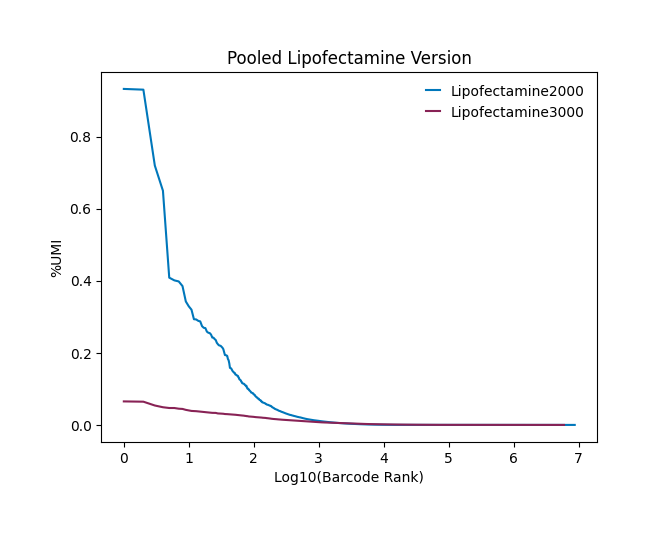

In [240]:
#pooled lipofectamine comparison (lipofectamine3000_g, 293 vs. lipofectamine2000_g, 293)
l2_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine2000/2/completecounts.tsv',delimiter='\t')
l2_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine2000/3/completecounts.tsv',delimiter='\t')
l2_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine2000/4/completecounts.tsv',delimiter='\t')
l2_6=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine2000/6/completecounts.tsv',delimiter='\t')

l3_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/2/completecounts.tsv',delimiter='\t')
l3_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/3/completecounts.tsv',delimiter='\t')
l3_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/4/completecounts.tsv',delimiter='\t')
l3_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/5/completecounts.tsv',delimiter='\t')

l2_data=[l2_2,l2_3,l2_4,l2_6]
l2_pooled = pd.concat(l2_data, axis=0, ignore_index=True)
l2_barcodes=l2_pooled.groupby('barcode')['UMI_Count'].sum()
l2_barcodes = pd.DataFrame(l2_barcodes)
l2_barcodes = l2_barcodes.reset_index()

l3_data=[l3_2,l3_3,l3_4,l3_5]
l3_pooled = pd.concat(l3_data, axis=0, ignore_index=True)
l3_barcodes=l3_pooled.groupby('barcode')['UMI_Count'].sum()
l3_barcodes = pd.DataFrame(l3_barcodes)
l3_barcodes = l3_barcodes.reset_index()

print(l2_barcodes['UMI_Count'].sum())
print(l3_barcodes['UMI_Count'].sum())

print(len(l2_barcodes))
print(len(l3_barcodes))


l2_barcodes['%UMI']=(l2_barcodes['UMI_Count']/63093988)*100
l3_barcodes['%UMI']=(l3_barcodes['UMI_Count']/79471625)*100

l2_barcodes_s=l2_barcodes.sort_values(by='%UMI',ascending=False)
l2_barcodes=l2_barcodes_s.reset_index()
l2_barcodes['rank']=l2_barcodes.index

l3_barcodes_s=l3_barcodes.sort_values(by='%UMI',ascending=False)
l3_barcodes=l3_barcodes_s.reset_index()
l3_barcodes['rank']=l3_barcodes.index

df = pd.DataFrame(index=range(len(l2_barcodes)-len(l3_barcodes)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_barcodes = pd.concat([l3_barcodes, df], ignore_index = True)

plt.plot(np.log10(l2_barcodes['rank']),l2_barcodes['%UMI'],label = "Lipofectamine2000",color = '#0077BB',linewidth=1.5)
plt.plot(np.log10(l3_barcodes['rank']),l3_barcodes['%UMI'],label = "Lipofectamine3000",color = '#882255',linewidth=1.5)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Pooled Lipofectamine Version")
#plt.yscale('log')
plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
#plt.axis([0, 7, 0.95, 1000000])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/non-logged_knee/pooled_lipofectamine_comparison.pdf",bbox_inches='tight', format='pdf')
plt.show()

16098390
14075623
16848906
16071069
25457517
15639047
20028038
18347023
2541102
2025608
2768499
2546343
1316958
1220929
1864912
2514628


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



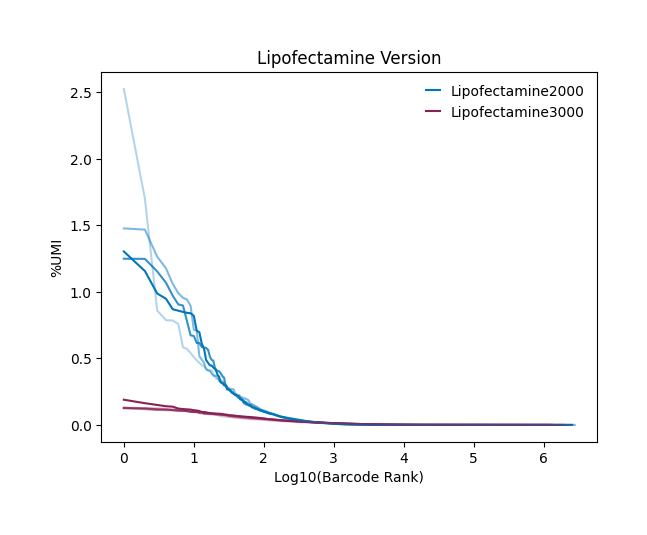

In [242]:
#replicate lipofectamine comparison (lipofectamine3000_g, 293 vs. lipofectamine2000_g, 293)
l2_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine2000/2/completecounts.tsv',delimiter='\t')
l2_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine2000/3/completecounts.tsv',delimiter='\t')
l2_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine2000/4/completecounts.tsv',delimiter='\t')
l2_6=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine2000/6/completecounts.tsv',delimiter='\t')

l3_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/2/completecounts.tsv',delimiter='\t')
l3_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/3/completecounts.tsv',delimiter='\t')
l3_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/4/completecounts.tsv',delimiter='\t')
l3_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/new_transfection/lipofectamine3000/5/completecounts.tsv',delimiter='\t')


print(l2_2['UMI_Count'].sum())
print(l2_3['UMI_Count'].sum())
print(l2_4['UMI_Count'].sum())
print(l2_6['UMI_Count'].sum())

print(l3_2['UMI_Count'].sum())
print(l3_3['UMI_Count'].sum())
print(l3_4['UMI_Count'].sum())
print(l3_5['UMI_Count'].sum())

print(len(l2_2))
print(len(l2_3))
print(len(l2_4))
print(len(l2_6))

print(len(l3_2))
print(len(l3_3))
print(len(l3_4))
print(len(l3_5))

l2_2['%UMI']=(l2_2['UMI_Count']/16098390)*100
l2_3['%UMI']=(l2_3['UMI_Count']/14075623)*100
l2_4['%UMI']=(l2_4['UMI_Count']/16848906)*100
l2_6['%UMI']=(l2_6['UMI_Count']/16071069)*100
l3_2['%UMI']=(l3_2['UMI_Count']/25457517)*100
l3_3['%UMI']=(l3_3['UMI_Count']/15639047)*100
l3_4['%UMI']=(l3_4['UMI_Count']/20028038)*100
l3_5['%UMI']=(l3_5['UMI_Count']/18347023)*100

l2_2_s=l2_2.sort_values(by='%UMI',ascending=False)
l2_2=l2_2_s.reset_index()
l2_2['rank']=l2_2.index
l2_3_s=l2_3.sort_values(by='%UMI',ascending=False)
l2_3=l2_3_s.reset_index()
l2_3['rank']=l2_3.index
l2_4_s=l2_4.sort_values(by='%UMI',ascending=False)
l2_4=l2_4_s.reset_index()
l2_4['rank']=l2_4.index
l2_6_s=l2_6.sort_values(by='%UMI',ascending=False)
l2_6=l2_6_s.reset_index()
l2_6['rank']=l2_6.index

l3_2_s=l3_2.sort_values(by='%UMI',ascending=False)
l3_2=l3_2_s.reset_index()
l3_2['rank']=l3_2.index
l3_3_s=l3_3.sort_values(by='%UMI',ascending=False)
l3_3=l3_3_s.reset_index()
l3_3['rank']=l3_3.index
l3_4_s=l3_4.sort_values(by='%UMI',ascending=False)
l3_4=l3_4_s.reset_index()
l3_4['rank']=l3_4.index
l3_5_s=l3_5.sort_values(by='%UMI',ascending=False)
l3_5=l3_5_s.reset_index()
l3_5['rank']=l3_5.index

df = pd.DataFrame(index=range(len(l2_4)-len(l2_2)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l2_2 = pd.concat([l2_2, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l2_4)-len(l2_3)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l2_3 = pd.concat([l2_3, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l2_4)-len(l2_6)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l2_6 = pd.concat([l2_6, df], ignore_index = True)

df = pd.DataFrame(index=range(len(l2_4)-len(l3_2)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_2 = pd.concat([l3_2, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l2_4)-len(l3_3)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_3 = pd.concat([l3_3, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l2_4)-len(l3_4)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_4 = pd.concat([l3_4, df], ignore_index = True)
df = pd.DataFrame(index=range(len(l2_4)-len(l3_5)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
l3_5 = pd.concat([l3_5, df], ignore_index = True)

plt.plot(np.log10(l2_2['rank']),l2_2['%UMI'],label = "Lipofectamine2000",color = '#0077BB',linewidth=1.5)
plt.plot(np.log10(l3_2['rank']),l3_2['%UMI'],label = "Lipofectamine3000",color = '#882255',linewidth=1.5)
plt.plot(np.log10(l2_3['rank']),l2_3['%UMI'],color = '#0077BB',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(l3_3['rank']),l3_3['%UMI'],color = '#882255',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(l2_4['rank']),l2_4['%UMI'],color = '#0077BB',linewidth=1.5,alpha=0.5)
plt.plot(np.log10(l3_4['rank']),l3_4['%UMI'],color = '#882255',linewidth=1.5,alpha=0.5)
plt.plot(np.log10(l2_6['rank']),l2_6['%UMI'],color = '#0077BB',linewidth=1.5,alpha=0.3)
plt.plot(np.log10(l3_5['rank']),l3_5['%UMI'],color = '#882255',linewidth=1.5,alpha=0.3)



plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Lipofectamine Version")
#plt.yscale('log')
plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
#plt.axis([0, 7, 0.95, 1000000])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/non-logged_knee/rep_lipofectamine_comparison.pdf",bbox_inches='tight', format='pdf')
plt.show()

110336495
111654453
1016443
1041619


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



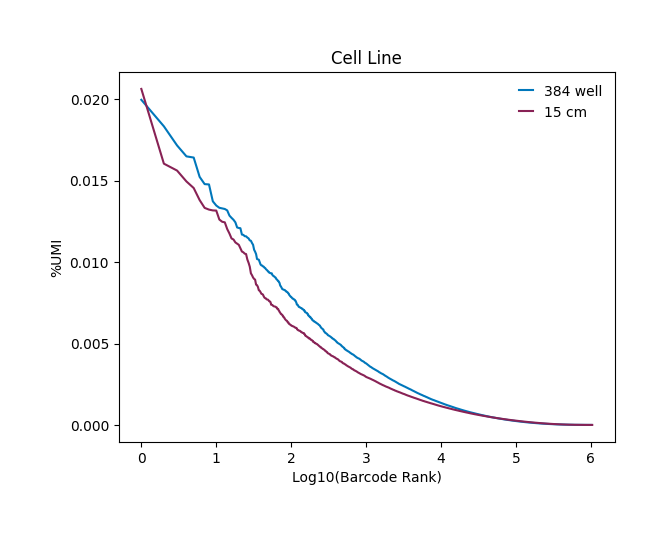

In [245]:
#plate size
#cell line comparison (lipofectamine3000, hekgt vs. hek293t)
hek_enva=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/plate_size/15_completecounts.tsv',delimiter='\t')
l3_enva=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/plate_size/384_completecounts.tsv',delimiter='\t')

print(hek_enva['UMI_Count'].sum())
print(l3_enva['UMI_Count'].sum())

print(len(hek_enva))
print(len(l3_enva))

hek_enva['%UMI']=(hek_enva['UMI_Count']/110336495)*100
l3_enva['%UMI']=(l3_enva['UMI_Count']/111654453)*100

hek_enva_s=hek_enva.sort_values(by='%UMI',ascending=False)
hek_enva=hek_enva_s.reset_index()
hek_enva['rank']=hek_enva.index

l3_enva_s=l3_enva.sort_values(by='%UMI',ascending=False)
l3_enva=l3_enva_s.reset_index()
l3_enva['rank']=l3_enva.index


df = pd.DataFrame(index=range(len(l3_enva)-len(hek_enva)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
hek_enva = pd.concat([hek_enva, df], ignore_index = True)


plt.plot(np.log10(hek_enva['rank']),hek_enva['%UMI'],label = "384 well",color = '#0077BB',linewidth=1.5)
plt.plot(np.log10(l3_enva['rank']),l3_enva['%UMI'],label = "15 cm",color = '#882255',linewidth=1.5)


plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Cell Line")
#plt.yscale('log')
plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
#plt.axis([0, 7, 0.95, 1000000])
plt.legend(loc='upper right')
plt.draw()
plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/non-logged_knee/plate_size.pdf",bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
#previous dataset vs replicates
#processing saunders dataset:
saunders_temp=pd.read_table('/Users/maddieurbanek/Desktop/pseudotypedcounts.csv',delimiter=',')
print(saunders_temp)
#Finish processing Saunders dataset
saunders = saunders_temp.loc[saunders_temp.index.repeat(saunders_temp['n_count'])].reset_index(drop=True)
saunders['barcode'] = saunders.index
saunders.drop(['n_count'],axis=1)
umis = saunders.loc[saunders.index.repeat(saunders['n_unique_umibc_pairs'])].reset_index(drop=True)
saunders=umis.drop(['n_count','n_unique_umibc_pairs'], axis=1)
saunders=pd.DataFrame(saunders)
saunders=pd.DataFrame(saunders)
saunders=saunders['barcode'].value_counts().reset_index()
saunders.columns=['barcode','UMI_Count']
#saunders.to_csv('/Users/maddieurbanek/Desktop/saunders.csv')

In [ ]:
#previous dataset vs replicates

rep1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/gt_completecounts.tsv',delimiter='\t')
rep2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/envb.tsv',delimiter='\t')
rep3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/enva.tsv',delimiter='\t')
#rep4=pd.read_table('/Users/maddieurbanek/Desktop/h2b_completecounts.tsv',delimiter='\t')
rep5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/cvs_viral/cvs_completecounts.tsv',delimiter='\t')
chen=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/previous_studies/zhang/zhangcompletecounts.csv',delimiter=',')
clark=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/previous_studies/clark/clarkcounts.tsv',delimiter='\t')
saunders=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/previous_studies/saunders/saunders.csv',delimiter=',')

rep3 = pd.DataFrame(rep3)
rep3 = rep3.reset_index()
test_1 = rep3.loc[rep3.index.repeat(rep3['UMI_Count'])].reset_index(drop=True)
test_1=test_1['barcode'].value_counts()
test_1=pd.DataFrame(test_1)
rep3 = test_1.reset_index()
rep3.columns=['barcode','UMI_Count']

print(rep1['UMI_Count'].sum())
print(rep2['UMI_Count'].sum())
print(rep3['UMI_Count'].sum())
#print(rep4['UMI_Count'].sum())
print(rep5['UMI_Count'].sum())
print(chen['UMI_Count'].sum())
print(clark['UMI_Count'].sum())
print(saunders['UMI_Count'].sum())

print(len(rep1))
print(len(rep2))
print(len(rep3))
#print(len(rep4))
print(len(rep5))
print(len(chen))
print(len(clark))
print(len(saunders))
rep1['%UMI']=(rep1['UMI_Count']/98288058)*100
rep2['%UMI']=(rep2['UMI_Count']/1339366)*100
rep3['%UMI']=(rep3['UMI_Count']/4830613)*100
#rep4['%UMI']=(rep4['UMI_Count']/9795086)*100
rep5['%UMI']=(rep5['UMI_Count']/61765229)*100
chen['%UMI']=(chen['UMI_Count']/399833)*100
clark['%UMI']=(clark['UMI_Count']/16446027)*100
saunders['%UMI']=(saunders['UMI_Count']/8239362.00255729)*100

rep1_s=rep1.sort_values(by='%UMI',ascending=False)
rep1=rep1_s.reset_index()
rep1['rank']=rep1.index
rep2_s=rep2.sort_values(by='%UMI',ascending=False)
rep2=rep2_s.reset_index()
rep2['rank']=rep2.index
rep3_s=rep3.sort_values(by='%UMI',ascending=False)
rep3=rep3_s.reset_index()
rep3['rank']=rep3.index
rep4_s=rep4.sort_values(by='%UMI',ascending=False)
#rep4=rep4_s.reset_index()
#rep4['rank']=rep4.index
rep5_s=rep5.sort_values(by='%UMI',ascending=False)
rep5=rep5_s.reset_index()
rep5['rank']=rep5.index

chen_s=chen.sort_values(by='%UMI',ascending=False)
chen=chen_s.reset_index()
chen['rank']=chen.index
clark_s=clark.sort_values(by='%UMI',ascending=False)
clark=clark_s.reset_index()
clark['rank']=clark.index
saunders_s=saunders.sort_values(by='%UMI',ascending=False)
saunders=saunders_s.reset_index()
saunders['rank']=saunders.index


df = pd.DataFrame(index=range(len(rep4)-len(rep1)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
rep1 = pd.concat([rep1, df], ignore_index = True)
df = pd.DataFrame(index=range(len(rep4)-len(rep2)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
rep2 = pd.concat([rep2, df], ignore_index = True)
df = pd.DataFrame(index=range(len(rep4)-len(rep3)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
rep3 = pd.concat([rep3, df], ignore_index = True)
df = pd.DataFrame(index=range(len(rep4)-len(rep5)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
rep5 = pd.concat([rep5, df], ignore_index = True)
df = pd.DataFrame(index=range(len(rep4)-len(chen)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
chen = pd.concat([chen, df], ignore_index = True)
df = pd.DataFrame(index=range(len(rep4)-len(clark)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
clark = pd.concat([clark, df], ignore_index = True)
df = pd.DataFrame(index=range(len(rep4)-len(saunders)),columns=range(1))
df.fillna(-100, inplace=True)
df.columns=['%UMI']
saunders = pd.concat([saunders, df], ignore_index = True)

plt.plot(np.log10(rep1['rank']),rep1['%UMI'],label = "This Study",color = '#882255',linewidth=1.5)
plt.plot(np.log10(rep2['rank']),rep2['%UMI'],color = '#882255',linewidth=1.5,alpha=0.8)
plt.plot(np.log10(rep3['rank']),rep3['%UMI'],color = '#882255',linewidth=1.5,alpha=0.6)
#plt.plot(np.log10(rep4['rank']),rep4['%UMI'],color = '#882255',linewidth=1.5,alpha=0.4)
plt.plot(np.log10(rep5['rank']),rep5['%UMI'],color = '#882255',linewidth=1.5,alpha=0.2)
plt.plot(np.log10(chen['rank']),chen['%UMI'],label = "Zhang 2024",color = '#88CCEE',linewidth=1.5)
plt.plot(np.log10(saunders['rank']),saunders['%UMI'],label = "Saunders 2022",color = '#332288',linewidth=1.5)
plt.plot(np.log10(clark['rank']),clark['%UMI'],label = "Clark 2021",color = '#117733',linewidth=1.5)


plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
plt.title("Previously Published Datasets")
#plt.yscale('log')
#plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
plt.axis([0, 7, 0.95, 1000000])
plt.legend(loc='upper right')
plt.draw()
#plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/non-logged_knee/publication_comparison.pdf",bbox_inches='tight', format='pdf')
plt.show()

          index  Unnamed: 0    barcode  UMI_Count        %UMI  rank
0           0.0         0.0  1293510.0    73967.0    0.897727   0.0
1           1.0         1.0  1293509.0    58453.0    0.709436   1.0
2           2.0         2.0  1293508.0    57649.0    0.699678   2.0
3           3.0         3.0  1293507.0    38478.0    0.467002   3.0
4           4.0         4.0  1293506.0    37200.0    0.451491   4.0
...         ...         ...        ...        ...         ...   ...
43691971    NaN         NaN        NaN        NaN -100.000000   NaN
43691972    NaN         NaN        NaN        NaN -100.000000   NaN
43691973    NaN         NaN        NaN        NaN -100.000000   NaN
43691974    NaN         NaN        NaN        NaN -100.000000   NaN
43691975    NaN         NaN        NaN        NaN -100.000000   NaN

[43691976 rows x 6 columns]


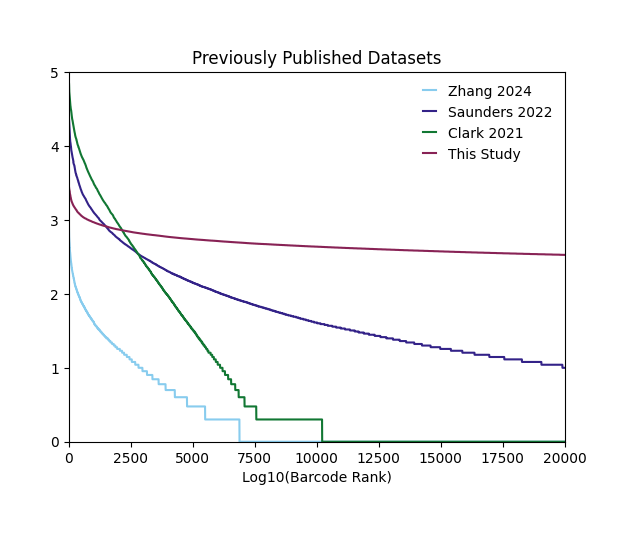

In [1165]:
print(saunders)

#plt.plot((rep1['rank']),np.log10(rep1['UMI_Count']),label = "This Study",color = '#882255',linewidth=1.5)
#plt.plot((rep2['rank']),np.log10(rep2['UMI_Count']),color = '#882255',linewidth=1.5,alpha=0.8)
#plt.plot((rep3['rank']),np.log10(rep3['UMI_Count']),color = '#882255',linewidth=1.5,alpha=0.6)
#plt.plot((rep4['rank']),np.log10(rep4['UMI_Count']),color = '#882255',linewidth=1.5,alpha=0.4)
#plt.plot((rep5['rank']),np.log10(rep5['UMI_Count']),color = '#882255',linewidth=1.5,alpha=0.2)
plt.plot((chen['rank']),np.log10(chen['UMI_Count']),label = "Zhang 2024",color = '#88CCEE',linewidth=1.5)
plt.plot((saunders['rank']),np.log10(saunders['UMI_Count']),label = "Saunders 2022",color = '#332288',linewidth=1.5)
plt.plot((clark['rank']),np.log10(clark['UMI_Count']),label = "Clark 2021",color = '#117733',linewidth=1.5)
plt.plot((rep1['rank']),np.log10(rep1['UMI_Count']),label = "This Study",color = '#882255',linewidth=1.5)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("")
plt.title("Previously Published Datasets")
#plt.yscale('log')
plt.legend(loc='upper right')
# Adding legend, which helps us recognize the curve according to it's color
plt.axis([0, 20000, 0, 5])
plt.legend(loc='upper right')
plt.draw()
#plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/non-logged_knee/publication_comparison.pdf",bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
#Plot barcode collision w/ error

In [ ]:
#cvs=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/gt_completecounts.tsv',delimiter='\t')
#cvs=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/envb.tsv',delimiter='\t')
#rep3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/enva.tsv',delimiter='\t')
rep3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/enva.tsv',delimiter='\t')
rep3 = pd.DataFrame(rep3)
rep3 = rep3.reset_index()
test_1 = rep3.loc[rep3.index.repeat(rep3['UMI_Count'])].reset_index(drop=True)
test_1=test_1['barcode'].value_counts()
test_1=pd.DataFrame(test_1)
cvs = test_1.reset_index()
cvs.columns=['barcode','UMI_Count']
#cvs=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/cvs_viral/cvs_completecounts.tsv',delimiter='\t')
#cvs=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/previous_studies/zhang/zhangcompletecounts.csv',delimiter=',')
cvs = cvs.loc[cvs.index.repeat(cvs['UMI_Count'])].reset_index(drop=True)
print(cvs)

In [517]:
int_list = [130000000000000]
i=100000
for n in range(0,50):
    data=(np.random.choice(cvs['barcode'],i,replace=True))
    data=pd.DataFrame(data)
    dup = data.duplicated(keep=first).sum()
    int_list.append(dup)
int_list = int_list[1:]
int_list=pd.DataFrame(int_list)
percentcells = int_list / i
int_list = pd.concat([int_list, percentcells], axis=1, ignore_index=True)
int_list.columns=['collisioncells','percentcells']
print(len(int_list))
int_list.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep1_5.txt', index = False, sep = '\t')

50


In [ ]:
sim_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep1_1.txt')
sim_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep1_2.txt')
sim_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep1_3.txt')
sim_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep1_4.txt')
sim_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep1_5.txt')

threemeans = [130000000000000]
threemean=sim_1['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_2['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_3['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_4['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_5['percentcells'].mean()
threemeans.append(threemean)

threemeans = threemeans[1:]

chencis = [130000000000000]
chenci=st.t.interval(confidence=0.95, df=len(sim_1['percentcells'])-1, loc=np.mean(sim_1['percentcells']), scale=st.sem(sim_1['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_2['percentcells'])-1, loc=np.mean(sim_2['percentcells']), scale=st.sem(sim_2['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_3['percentcells'])-1, loc=np.mean(sim_3['percentcells']), scale=st.sem(sim_3['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_4['percentcells'])-1, loc=np.mean(sim_4['percentcells']), scale=st.sem(sim_4['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_5['percentcells'])-1, loc=np.mean(sim_5['percentcells']), scale=st.sem(sim_5['percentcells'])) 
chencis.append(chenci)

chencis = chencis[1:]

new=[1,2,3,4,5]
new=pd.DataFrame(new)
chencis=pd.DataFrame(chencis)
threemeans=pd.DataFrame(threemeans)
new = pd.concat([new, threemeans], axis=1, ignore_index=True)
new = pd.concat([new, chencis], axis=1, ignore_index=True)
new.columns=['x','mean','higher','lower']
rep1=new.copy(deep=True)

In [ ]:
sim_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep2_1.txt')
sim_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep2_2.txt')
sim_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep2_3.txt')
sim_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep2_4.txt')
sim_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep2_5.txt')

threemeans = [130000000000000]
threemean=sim_1['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_2['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_3['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_4['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_5['percentcells'].mean()
threemeans.append(threemean)

threemeans = threemeans[1:]

chencis = [130000000000000]
chenci=st.t.interval(confidence=0.95, df=len(sim_1['percentcells'])-1, loc=np.mean(sim_1['percentcells']), scale=st.sem(sim_1['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_2['percentcells'])-1, loc=np.mean(sim_2['percentcells']), scale=st.sem(sim_2['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_3['percentcells'])-1, loc=np.mean(sim_3['percentcells']), scale=st.sem(sim_3['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_4['percentcells'])-1, loc=np.mean(sim_4['percentcells']), scale=st.sem(sim_4['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_5['percentcells'])-1, loc=np.mean(sim_5['percentcells']), scale=st.sem(sim_5['percentcells'])) 
chencis.append(chenci)

chencis = chencis[1:]

new=[1,2,3,4,5]
new=pd.DataFrame(new)
chencis=pd.DataFrame(chencis)
threemeans=pd.DataFrame(threemeans)
new = pd.concat([new, threemeans], axis=1, ignore_index=True)
new = pd.concat([new, chencis], axis=1, ignore_index=True)
new.columns=['x','mean','higher','lower']
rep2=new.copy(deep=True)

In [ ]:
sim_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep3_1.txt')
sim_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep3_2.txt')
sim_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep3_3.txt')
sim_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep3_4.txt')
sim_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep3_5.txt')

threemeans = [130000000000000]
threemean=sim_1['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_2['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_3['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_4['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_5['percentcells'].mean()
threemeans.append(threemean)

threemeans = threemeans[1:]

chencis = [130000000000000]
chenci=st.t.interval(confidence=0.95, df=len(sim_1['percentcells'])-1, loc=np.mean(sim_1['percentcells']), scale=st.sem(sim_1['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_2['percentcells'])-1, loc=np.mean(sim_2['percentcells']), scale=st.sem(sim_2['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_3['percentcells'])-1, loc=np.mean(sim_3['percentcells']), scale=st.sem(sim_3['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_4['percentcells'])-1, loc=np.mean(sim_4['percentcells']), scale=st.sem(sim_4['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_5['percentcells'])-1, loc=np.mean(sim_5['percentcells']), scale=st.sem(sim_5['percentcells'])) 
chencis.append(chenci)

chencis = chencis[1:]

new=[1,2,3,4,5]
new=pd.DataFrame(new)
chencis=pd.DataFrame(chencis)
threemeans=pd.DataFrame(threemeans)
new = pd.concat([new, threemeans], axis=1, ignore_index=True)
new = pd.concat([new, chencis], axis=1, ignore_index=True)
new.columns=['x','mean','higher','lower']
rep3=new.copy(deep=True)

In [ ]:
sim_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep4_1.txt')
sim_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep4_2.txt')
sim_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep4_3.txt')
sim_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep4_4.txt')
sim_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/rep4_5.txt')

threemeans = [130000000000000]
threemean=sim_1['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_2['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_3['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_4['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_5['percentcells'].mean()
threemeans.append(threemean)

threemeans = threemeans[1:]

chencis = [130000000000000]
chenci=st.t.interval(confidence=0.95, df=len(sim_1['percentcells'])-1, loc=np.mean(sim_1['percentcells']), scale=st.sem(sim_1['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_2['percentcells'])-1, loc=np.mean(sim_2['percentcells']), scale=st.sem(sim_2['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_3['percentcells'])-1, loc=np.mean(sim_3['percentcells']), scale=st.sem(sim_3['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_4['percentcells'])-1, loc=np.mean(sim_4['percentcells']), scale=st.sem(sim_4['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_5['percentcells'])-1, loc=np.mean(sim_5['percentcells']), scale=st.sem(sim_5['percentcells'])) 
chencis.append(chenci)

chencis = chencis[1:]

new=[1,2,3,4,5]
new=pd.DataFrame(new)
chencis=pd.DataFrame(chencis)
threemeans=pd.DataFrame(threemeans)
new = pd.concat([new, threemeans], axis=1, ignore_index=True)
new = pd.concat([new, chencis], axis=1, ignore_index=True)
new.columns=['x','mean','higher','lower']
rep4=new.copy(deep=True)

In [482]:
sim_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/saunders_1.txt')
sim_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/saunders_2.txt')
sim_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/saunders_3.txt')
sim_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/saunders_4.txt')
sim_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/saunders_5.txt')

threemeans = [130000000000000]
threemean=sim_1['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_2['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_3['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_4['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_5['percentcells'].mean()
threemeans.append(threemean)

threemeans = threemeans[1:]

chencis = [130000000000000]
chenci=st.t.interval(confidence=0.95, df=len(sim_1['percentcells'])-1, loc=np.mean(sim_1['percentcells']), scale=st.sem(sim_1['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_2['percentcells'])-1, loc=np.mean(sim_2['percentcells']), scale=st.sem(sim_2['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_3['percentcells'])-1, loc=np.mean(sim_3['percentcells']), scale=st.sem(sim_3['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_4['percentcells'])-1, loc=np.mean(sim_4['percentcells']), scale=st.sem(sim_4['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_5['percentcells'])-1, loc=np.mean(sim_5['percentcells']), scale=st.sem(sim_5['percentcells'])) 
chencis.append(chenci)

chencis = chencis[1:]

new=[1,2,3,4,5]
new=pd.DataFrame(new)
chencis=pd.DataFrame(chencis)
threemeans=pd.DataFrame(threemeans)
new = pd.concat([new, threemeans], axis=1, ignore_index=True)
new = pd.concat([new, chencis], axis=1, ignore_index=True)
new.columns=['x','mean','higher','lower']
saunders=new.copy(deep=True)

/Users/maddieurbanek/miniconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2285: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/miniconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [483]:
sim_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/clark_1.txt')
sim_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/clark_2.txt')
sim_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/clark_3.txt')
sim_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/clark_4.txt')
sim_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/clark_5.txt')

threemeans = [130000000000000]
threemean=sim_1['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_2['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_3['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_4['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_5['percentcells'].mean()
threemeans.append(threemean)

threemeans = threemeans[1:]

chencis = [130000000000000]
chenci=st.t.interval(confidence=0.95, df=len(sim_1['percentcells'])-1, loc=np.mean(sim_1['percentcells']), scale=st.sem(sim_1['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_2['percentcells'])-1, loc=np.mean(sim_2['percentcells']), scale=st.sem(sim_2['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_3['percentcells'])-1, loc=np.mean(sim_3['percentcells']), scale=st.sem(sim_3['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_4['percentcells'])-1, loc=np.mean(sim_4['percentcells']), scale=st.sem(sim_4['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_5['percentcells'])-1, loc=np.mean(sim_5['percentcells']), scale=st.sem(sim_5['percentcells'])) 
chencis.append(chenci)

chencis = chencis[1:]

new=[1,2,3,4,5]
new=pd.DataFrame(new)
chencis=pd.DataFrame(chencis)
threemeans=pd.DataFrame(threemeans)
new = pd.concat([new, threemeans], axis=1, ignore_index=True)
new = pd.concat([new, chencis], axis=1, ignore_index=True)
new.columns=['x','mean','higher','lower']
clark=new.copy(deep=True)

In [484]:
sim_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/chen_1.txt')
sim_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/chen_2.txt')
sim_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/chen_3.txt')
sim_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/chen_4.txt')
sim_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/prev_data/keep_true/chen_5.txt')

threemeans = [130000000000000]
threemean=sim_1['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_2['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_3['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_4['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_5['percentcells'].mean()
threemeans.append(threemean)

threemeans = threemeans[1:]

chencis = [130000000000000]
chenci=st.t.interval(confidence=0.95, df=len(sim_1['percentcells'])-1, loc=np.mean(sim_1['percentcells']), scale=st.sem(sim_1['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_2['percentcells'])-1, loc=np.mean(sim_2['percentcells']), scale=st.sem(sim_2['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_3['percentcells'])-1, loc=np.mean(sim_3['percentcells']), scale=st.sem(sim_3['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_4['percentcells'])-1, loc=np.mean(sim_4['percentcells']), scale=st.sem(sim_4['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_5['percentcells'])-1, loc=np.mean(sim_5['percentcells']), scale=st.sem(sim_5['percentcells'])) 
chencis.append(chenci)

chencis = chencis[1:]

new=[1,2,3,4,5]
new=pd.DataFrame(new)
chencis=pd.DataFrame(chencis)
threemeans=pd.DataFrame(threemeans)
new = pd.concat([new, threemeans], axis=1, ignore_index=True)
new = pd.concat([new, chencis], axis=1, ignore_index=True)
new.columns=['x','mean','higher','lower']
chen=new.copy(deep=True)

/Users/maddieurbanek/miniconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2285: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/miniconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [404]:
sim_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/new_transfection/l3k.5_1.txt')
sim_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/new_transfection/l3k.5_2.txt')
sim_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/new_transfection/l3k.5_3.txt')
sim_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/new_transfection/l3k.5_4.txt')
sim_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/collision/new_transfection/l3k.5_5.txt')

threemeans = [130000000000000]
threemean=sim_1['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_2['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_3['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_4['percentcells'].mean()
threemeans.append(threemean)
threemean=sim_5['percentcells'].mean()
threemeans.append(threemean)

threemeans = threemeans[1:]

chencis = [130000000000000]
chenci=st.t.interval(confidence=0.95, df=len(sim_1['percentcells'])-1, loc=np.mean(sim_1['percentcells']), scale=st.sem(sim_1['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_2['percentcells'])-1, loc=np.mean(sim_2['percentcells']), scale=st.sem(sim_2['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_3['percentcells'])-1, loc=np.mean(sim_3['percentcells']), scale=st.sem(sim_3['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_4['percentcells'])-1, loc=np.mean(sim_4['percentcells']), scale=st.sem(sim_4['percentcells'])) 
chencis.append(chenci)
chenci=st.t.interval(confidence=0.95, df=len(sim_5['percentcells'])-1, loc=np.mean(sim_5['percentcells']), scale=st.sem(sim_5['percentcells'])) 
chencis.append(chenci)

chencis = chencis[1:]

new=[1,2,3,4,5]
new=pd.DataFrame(new)
chencis=pd.DataFrame(chencis)
threemeans=pd.DataFrame(threemeans)
new = pd.concat([new, threemeans], axis=1, ignore_index=True)
new = pd.concat([new, chencis], axis=1, ignore_index=True)
new.columns=['x','mean','higher','lower']
l3k_4=new.copy(deep=True)

/Users/maddieurbanek/miniconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2285: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/maddieurbanek/miniconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1047/311563515.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=rep1, x="x", y="mean", ci='sd', color='black',linewidth = 1.5)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1047/311563515.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=rep2, x="x", y="mean", ci='sd',color='black', linewidth = 1.5,alpha=0.8)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1047/311563515.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=rep3, x="x", y="mean", ci='sd', color='black',linewidth = 1.5,alpha=0.6)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1047/311563515.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=rep4, x="x", y="mea

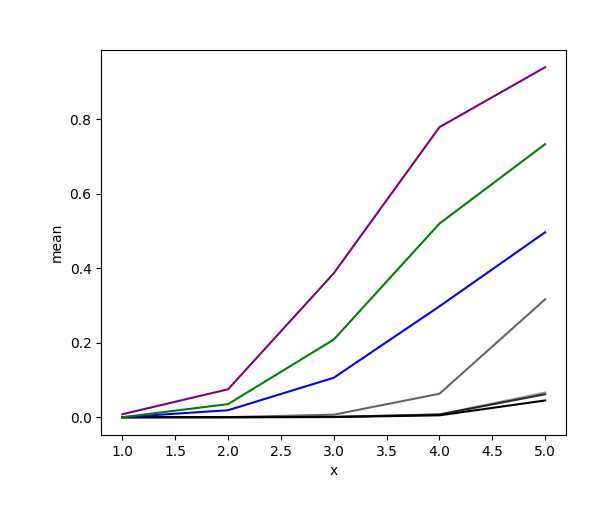

In [523]:
fig, ax = plt.subplots(figsize=(6,5))
sns.lineplot(data=rep1, x="x", y="mean", ci='sd', color='black',linewidth = 1.5)
sns.lineplot(data=rep2, x="x", y="mean", ci='sd',color='black', linewidth = 1.5,alpha=0.8)
sns.lineplot(data=rep3, x="x", y="mean", ci='sd', color='black',linewidth = 1.5,alpha=0.6)
sns.lineplot(data=rep4, x="x", y="mean", ci='sd',color='black', linewidth = 1.5,alpha=0.4)

sns.lineplot(data=chen, x="x", y="mean", ci='sd', color='blue',linewidth = 1.5)
sns.lineplot(data=saunders, x="x", y="mean", ci='sd',color='green', linewidth = 1.5)
sns.lineplot(data=clark, x="x", y="mean", ci='sd', color='purple',linewidth = 1.5)
#sns.lineplot(data=l3k_4, x="x", y="mean", ci='sd',color='blue', linewidth = 1.5)

#sns.lineplot(data=saunders, x="x", y="mean", ci='sd',color='indigo', linewidth = 1.5,label='saunders')
#sns.lineplot(data=clark, x="x", y="mean", errorbar='sd',color='green', linewidth = 1.5,label='clark')
#sns.lineplot(data=chen, x="x", y="mean", ci='sd',color='skyblue', linewidth = 1.5,label='chen')

#sns.lineplot(data=sad, x="x", y="mean", errorbar='sd',color='green', linewidth = 1.5,label='sad')
#sns.lineplot(data=cvs, x="x", y="mean", errorbar='sd',color='skyblue', linewidth = 1.5,label='cvs')
ax.figure.savefig("/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/prev_pub.svg")
plt.show()

In [ ]:
#Plot read simulations

In [ ]:
#previous dataset vs replicates
#processing saunders dataset:
rep1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/gt_completecounts.tsv',delimiter='\t')
rep2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/envb.tsv',delimiter='\t')
rep3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/enva.tsv',delimiter='\t')
#rep4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/optimized_replicates/h2b.csv',delimiter=',')
rep5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/cvs_viral/cvs_completecounts.tsv',delimiter='\t')
chen=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/previous_studies/zhang/zhangcompletecounts.csv',delimiter=',')
clark=pd.read_table('/Users/maddieurbanek/Downloads/Source/raw_data/previous_studies/clark/clarkcounts.tsv',delimiter='\t')
saunders=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/previous_studies/saunders/saunders.csv',delimiter=',')

rep3 = pd.DataFrame(rep3)
rep3 = rep3.reset_index()
test_1 = rep3.loc[rep3.index.repeat(rep3['UMI_Count'])].reset_index(drop=True)
test_1=test_1['barcode'].value_counts()
test_1=pd.DataFrame(test_1)
rep3 = test_1.reset_index()
rep3.columns=['barcode','UMI_Count']
print(rep3.head)



In [ ]:
#Bootstrapping 10^1-6 and save datsets
chen=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/previous_studies/zhang/zhangcompletecounts.csv',delimiter=',')

chen['barcode'] = chen.index
#clark['barcode'] = clark.index
#saunders['barcode']= saunders.index
#rep1['barcode']= rep1.index
#rep2['barcode']= rep2.index
#rep3['barcode']= rep3.index
#rep5['barcode']= rep5.index

chen = chen.loc[chen.index.repeat(chen['UMI_Count'])].reset_index(drop=True)
#clark = clark.loc[clark.index.repeat(clark['UMI_Count'])].reset_index(drop=True)
#saunders = saunders.loc[saunders.index.repeat(saunders['UMI_Count'])].reset_index(drop=True)
#rep1 = rep1.loc[rep1.index.repeat(rep1['UMI_Count'])].reset_index(drop=True)
#rep2 = rep2.loc[rep2.index.repeat(rep2['UMI_Count'])].reset_index(drop=True)
#rep3 = rep3.loc[rep3.index.repeat(rep3['UMI_Count'])].reset_index(drop=True)
#rep5 = rep5.loc[rep5.index.repeat(rep5['UMI_Count'])].reset_index(drop=True)

chenbootcounts = pd.DataFrame()
i=1000
for n in range(0,100):
    data=(np.random.choice(chen['barcode'],i,replace=True))
    data=pd.Series(data).value_counts()
    data = pd.DataFrame(data)
    data.columns=['count']
    data=data.reset_index()
    chenbootcounts=pd.concat([chenbootcounts,data['count']],ignore_index=True,axis=1)

chenbootcounts.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_chen.csv')
print(chenbootcounts)

In [ ]:
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_chen.csv',delimiter=',')
chenmeans = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
chenmeans.append(chenmean)
chenmeans = chenmeans[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
chenmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
chenmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
chenmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
chenmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
chenmeans.append(chenmean)
print(chenmeans)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_chen.csv',delimiter=',')
chendevs = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
chendevs.append(chendev)
chendevs = chendevs[1:]
print(chendevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
chendevs.append(chendev)
print(chendevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
chendevs.append(chendev)
print(chendevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
chendevs.append(chendev)
print(chendevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
chendevs.append(chendev)
print(chendevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_chen.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
chendevs.append(chendev)
print(chendevs)

#
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_clark.csv',delimiter=',')
clarkmeans = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
clarkmeans.append(chenmean)
clarkmeans = clarkmeans[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
clarkmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
clarkmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
clarkmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
clarkmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
clarkmeans.append(chenmean)


chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_clark.csv',delimiter=',')
clarkdevs = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
clarkdevs.append(chendev)
clarkdevs = clarkdevs[1:]
print(clarkdevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
clarkdevs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
clarkdevs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
clarkdevs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
clarkdevs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_clark.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
clarkdevs.append(chendev)

#
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_saunders.csv',delimiter=',')
saundersmeans = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
saundersmeans.append(chenmean)
saundersmeans = saundersmeans[1:]
print(saundersmeans)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
saundersmeans.append(chenmean)
print(saundersmeans)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
saundersmeans.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
saundersmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
saundersmeans.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
saundersmeans.append(chenmean)


chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_saunders.csv',delimiter=',')
saundersdevs = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
saundersdevs.append(chendev)
saundersdevs = saundersdevs[1:]
print(saundersdevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
saundersdevs.append(chendev)
print(saundersdevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
saundersdevs.append(chendev)
print(saundersdevs)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
saundersdevs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
saundersdevs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_saunders.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
saundersdevs.append(chendev)




#
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_rep1.csv',delimiter=',')
rep1means = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep1means.append(chenmean)
rep1means = rep1means[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep1means.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep1means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep1means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep1means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep1means.append(chenmean)





chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_rep1.csv',delimiter=',')
rep1devs = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep1devs.append(chendev)
rep1devs = rep1devs[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep1devs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep1devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep1devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep1devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_rep1.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep1devs.append(chendev)



#
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_rep2.csv',delimiter=',')
rep2means = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep2means.append(chenmean)
rep2means = rep2means[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep2means.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep2means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep2means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep2means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep2means.append(chenmean)


chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_rep2.csv',delimiter=',')
rep2devs = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep2devs.append(chendev)
rep2devs = rep2devs[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep2devs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep2devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep2devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep2devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_rep2.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep2devs.append(chendev)
#
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_rep3.csv',delimiter=',')
rep3means = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep3means.append(chenmean)
rep3means = rep3means[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep3means.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep3means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep3means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep3means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep3means.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_rep3.csv',delimiter=',')
rep3devs = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep3devs.append(chendev)
rep3devs = rep3devs[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep3devs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep3devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep3devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep3devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_rep3.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep3devs.append(chendev)


chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_rep5.csv',delimiter=',')
rep5means = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep5means.append(chenmean)
rep5means = rep5means[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep5means.append(chenmean)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep5means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep5means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep5means.append(chenmean)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chenmean=df.mean()
rep5means.append(chenmean)


chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/1_rep5.csv',delimiter=',')
rep5devs = [130000000000000]
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep5devs.append(chendev)
rep5devs = rep5devs[1:]

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/2_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep5devs.append(chendev)

chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/3_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep5devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/4_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep5devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/5_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep5devs.append(chendev)
chen = pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes/6_rep5.csv',delimiter=',')
chen=chen.iloc[: , 1:]
df=chen.count()
chendev=df.std()
rep5devs.append(chendev)

#
reads=[10,100,1000,10000,100000,1000000]
reads=pd.DataFrame(reads)
chenmeans=pd.DataFrame(chenmeans)
clarkmeans=pd.DataFrame(clarkmeans)
saundersmeans=pd.DataFrame(saundersmeans)
rep1means=pd.DataFrame(rep1means)
rep2means=pd.DataFrame(rep2means)
rep3means=pd.DataFrame(rep3means)
rep5means=pd.DataFrame(rep5means)

chendevs=pd.DataFrame(chendevs)
clarkdevs=pd.DataFrame(clarkdevs)
saundersdevs=pd.DataFrame(saundersdevs)
rep1devs=pd.DataFrame(rep1devs)
rep2devs=pd.DataFrame(rep2devs)
rep3devs=pd.DataFrame(rep3devs)
rep5devs=pd.DataFrame(rep5devs)

reads.columns=['x']
reads = pd.concat([reads, chenmeans], axis=1, ignore_index=True)
reads = pd.concat([reads, clarkmeans], axis=1, ignore_index=True)
reads = pd.concat([reads, saundersmeans], axis=1, ignore_index=True)
reads = pd.concat([reads, rep1means], axis=1, ignore_index=True)
reads = pd.concat([reads, rep2means], axis=1, ignore_index=True)
reads = pd.concat([reads, rep3means], axis=1, ignore_index=True)
reads = pd.concat([reads, rep5means], axis=1, ignore_index=True)
ideal=[10,100,1000,10000,100000,1000000]
ideal=pd.DataFrame(ideal)
idealdev=[0,0,0,0,0,0]
idealdev=pd.DataFrame(idealdev)
reads = pd.concat([reads, ideal], axis=1, ignore_index=True)

reads = pd.concat([reads, chendevs], axis=1, ignore_index=True)
reads = pd.concat([reads, clarkdevs], axis=1, ignore_index=True)
reads = pd.concat([reads, saundersdevs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep1devs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep2devs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep3devs], axis=1, ignore_index=True)
reads = pd.concat([reads, rep5devs], axis=1, ignore_index=True)
reads = pd.concat([reads, idealdev], axis=1, ignore_index=True)

reads.columns=['x','chen','clark','saunders','rep1','rep2','rep3','rep5', 'ideal', 'chendev','clarkdev','saundersdev','rep1dev','rep2dev','rep3dev','rep5dev','idealdev']

reads.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/unique_barcodes_vs_reads.csv')


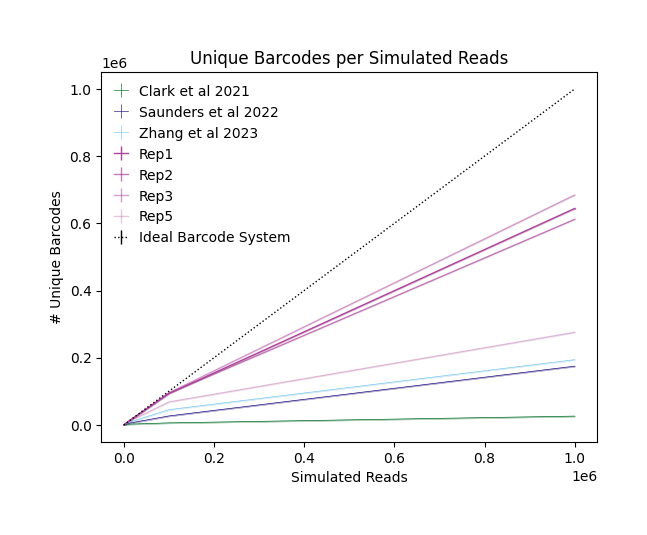

In [79]:
#Plot unique barcode per reads comparison
reads=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/diversity_datasets/unique_barcodes_vs_reads.csv',delimiter=',')
plt.errorbar(reads['x'],reads['clark'], yerr=reads['clarkdev'], color = '#117733',label="Clark et al 2021")
plt.errorbar(reads['x'],reads['saunders'], yerr=reads['saundersdev'], color = '#332288',label="Saunders et al 2022")
plt.errorbar(reads['x'],reads['chen'], yerr=reads['chendev'], color = '#88CCEE',label="Zhang et al 2023")

plt.errorbar(reads['x'],reads['rep1'], yerr=reads['rep1dev'], color = '#AA4499',label="Rep1",linewidth=1)
plt.errorbar(reads['x'],reads['rep2'], yerr=reads['rep2dev'], color = '#AA4499',label="Rep2",alpha=0.7,linewidth=1)
plt.errorbar(reads['x'],reads['rep3'], yerr=reads['rep3dev'], color = '#AA4499',label="Rep3",alpha=0.5,linewidth=1)
plt.errorbar(reads['x'],reads['rep5'], yerr=reads['rep5dev'], color = '#AA4499',label="Rep5",alpha=0.3,linewidth=1)
plt.errorbar(reads['x'],reads['ideal'], yerr=reads['idealdev'], color = 'black',label="Ideal Barcode System", fmt=":",linewidth=1)


plt.fill_between(reads['x'], reads['chen']-reads['chendev'], reads['chen']+reads['chendev'],color='#88CCEE',alpha=0.3,linewidth=1)
plt.fill_between(reads['x'], reads['clark']-reads['clarkdev'], reads['clark']+reads['clarkdev'],color='#117733',alpha=0.3,linewidth=1)
plt.fill_between(reads['x'], reads['saunders']-reads['saundersdev'], reads['saunders']+reads['saundersdev'],color='#332288',alpha=0.3,linewidth=1)
plt.fill_between(reads['x'], reads['rep1']-reads['rep1dev'], reads['rep1']+reads['rep1dev'],color='#AA4499',alpha=0.3,linewidth=1)
plt.fill_between(reads['x'], reads['rep2']-reads['rep2dev'], reads['rep2']+reads['rep2dev'],color='#AA4499',alpha=0.1,linewidth=1)
plt.fill_between(reads['x'], reads['rep3']-reads['rep3dev'], reads['rep3']+reads['rep3dev'],color='#AA4499',alpha=0.1,linewidth=1)
plt.fill_between(reads['x'], reads['rep5']-reads['rep5dev'], reads['rep5']+reads['rep5dev'],color='#AA4499',alpha=0.1,linewidth=1)


plt.ylabel("# Unique Barcodes")
plt.xlabel("Simulated Reads")
plt.title("Unique Barcodes per Simulated Reads")
plt.legend()

#plt.axis([5, 6.5, 1000, 1000000])


#import matplotlib as mpl
#mpl.rcParams['pdf.fonttype'] = 42
#mpl.rcParams['ps.fonttype'] = 42
#plt.draw()
#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/1-3_diversity/unique_barcodes_per_simulated_reads.pdf', bbox_inches='tight', format='pdf')
plt.show()


<bound method NDFrame.head of             counts  barcode
0          1057053        0
1          1057053        0
2          1057053        0
3          1057053        0
4          1057053        0
...            ...      ...
244120956        1   214836
244120957        1   214837
244120958        1   214838
244120959        1   214839
244120960        1   214840

[244120961 rows x 2 columns]>



KeyboardInterrupt



In [ ]:
CONNECTIVITY ANALYSIS PART 2

In [ ]:
#Bootstrapping random connectivity based on total number of pairs:
import time
starttime = time.time()


simulated_connectivity = pd.DataFrame({
   'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG',

'In-Astrocytes',
'In-In',
'In-L2/3',
'In-L4',
'In-L5/6/SP',
'In-OPCs',
'In-Progenitors',
'In-RG',

'L2/3-Astrocytes',
'L2/3-In',
'L2/3-L2/3',
'L2/3-L4',
'L2/3-L5/6/SP',
'L2/3-OPCs',
'L2/3-Progenitors',
'L2/3-RG',

'L4-Astrocytes',
'L4-In',
'L4-L2/3',
'L4-L4',
'L4-L5/6/SP',
'L4-OPCs',
'L4-Progenitors',
'L4-RG',

'L5/6/SP-Astrocytes',
'L5/6/SP-In',
'L5/6/SP-L2/3',
'L5/6/SP-L4',
'L5/6/SP-L5/6/SP',
'L5/6/SP-OPCs',
'L5/6/SP-Progenitors',
'L5/6/SP-RG',

'OPCs-Astrocytes',
'OPCs-In',
'OPCs-L2/3',
'OPCs-L4',
'OPCs-L5/6/SP',
'OPCs-OPCs',
'OPCs-Progenitors',
'OPCs-RG',

'Progenitors-Astrocytes',     
'Progenitors-In',
'Progenitors-L2/3',
'Progenitors-L4',
'Progenitors-L5/6/SP',
'Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG',

'RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
})
#simulated_connectivity.columns=['start']
simulated_connectivity.set_index('celltypes', inplace=True)

base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
base_props = pd.DataFrame(base_props)
base_props = base_props.reset_index()
bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
partner=pd.DataFrame(columns=['pre','post'])

for l in range(0,10):    
    for n in range(0,4331):
        base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
        partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
        partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
        bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
        bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
        bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
        bootstrapped_counts.columns=['celltypes','count']
        bootstrapped_counts.set_index('celltypes', inplace=True)
    simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)     
    #simulated_connectivity=simulated_connectivity.merge(bootstrapped_counts, how='outer')
#print(bootstrapped_counts)
simulated_connectivity=simulated_connectivity.fillna(0)
simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/simulated_connectivity_1_1.csv')
print('Done bootstrapping! :)')
endtime = time.time()
print(starttime)
print("total time taken")
print(endtime-starttime)

In [59]:
def simulate_connections_1(n,l):
    np.random.seed()
    simulated_connectivity_1 = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity_1.set_index('celltypes', inplace=True)
    base_props_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props_1 = pd.DataFrame(base_props_1)
    base_props_1 = base_props_1.reset_index()
    bootstrapped_pairs_1 = pd.DataFrame(columns=['pre','post'])
    partner_1=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop_1 = base_props_1.loc[base_props_1.index.repeat(base_props_1['cellbarcode'])].reset_index(drop=True)
            partner_1['pre']=(np.random.choice(base_prop_1['celltype'],1,replace=False))
            partner_1['post']=(np.random.choice(base_prop_1['celltype'],1,replace=False))
            bootstrapped_pairs_1=pd.concat([bootstrapped_pairs_1,partner_1],ignore_index=True,axis=0)
            bootstrapped_pairs_1['connection'] = bootstrapped_pairs_1[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts_1=bootstrapped_pairs_1['connection'].value_counts().reset_index()
            bootstrapped_counts_1.columns=['celltypes','count']
            bootstrapped_counts_1.set_index('celltypes', inplace=True)
        simulated_connectivity_1 = pd.concat([simulated_connectivity_1, bootstrapped_counts_1], axis=1).reindex(simulated_connectivity_1.index)
        bootstrapped_pairs_1 = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity_1=simulated_connectivity_1.fillna(0)
    simulated_connectivity_1.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_1.csv')
    print('Done bootstrapping 1! :)')

def simulate_connections_2(n,l):
    np.random.seed()
    simulated_connectivity = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity.set_index('celltypes', inplace=True)
    base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props = pd.DataFrame(base_props)
    base_props = base_props.reset_index()
    bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    partner=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
            partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
            partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
            bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
            bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
            bootstrapped_counts.columns=['celltypes','count']
            bootstrapped_counts.set_index('celltypes', inplace=True)
        simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)
        bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity=simulated_connectivity.fillna(0)
    simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_2.csv')
    print('Done bootstrapping 2! :)')

def simulate_connections_3(n,l):
    np.random.seed()
    simulated_connectivity = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity.set_index('celltypes', inplace=True)
    base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props = pd.DataFrame(base_props)
    base_props = base_props.reset_index()
    bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    partner=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
            partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
            partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
            bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
            bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
            bootstrapped_counts.columns=['celltypes','count']
            bootstrapped_counts.set_index('celltypes', inplace=True)
        simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)
        bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity=simulated_connectivity.fillna(0)
    simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_3.csv')
    print('Done bootstrapping 3! :)')

def simulate_connections_4(n,l):
    np.random.seed()
    simulated_connectivity_1 = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity_1.set_index('celltypes', inplace=True)
    base_props_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props_1 = pd.DataFrame(base_props_1)
    base_props_1 = base_props_1.reset_index()
    bootstrapped_pairs_1 = pd.DataFrame(columns=['pre','post'])
    partner_1=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop_1 = base_props_1.loc[base_props_1.index.repeat(base_props_1['cellbarcode'])].reset_index(drop=True)
            partner_1['pre']=(np.random.choice(base_prop_1['celltype'],1,replace=False))
            partner_1['post']=(np.random.choice(base_prop_1['celltype'],1,replace=False))
            bootstrapped_pairs_1=pd.concat([bootstrapped_pairs_1,partner_1],ignore_index=True,axis=0)
            bootstrapped_pairs_1['connection'] = bootstrapped_pairs_1[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts_1=bootstrapped_pairs_1['connection'].value_counts().reset_index()
            bootstrapped_counts_1.columns=['celltypes','count']
            bootstrapped_counts_1.set_index('celltypes', inplace=True)
        simulated_connectivity_1 = pd.concat([simulated_connectivity_1, bootstrapped_counts_1], axis=1).reindex(simulated_connectivity_1.index)
        bootstrapped_pairs_1 = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity_1=simulated_connectivity_1.fillna(0)
    simulated_connectivity_1.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_4.csv')
    print('Done bootstrapping 4! :)')

def simulate_connections_5(n,l):
    np.random.seed()
    simulated_connectivity = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity.set_index('celltypes', inplace=True)
    base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props = pd.DataFrame(base_props)
    base_props = base_props.reset_index()
    bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    partner=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
            partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
            partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
            bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
            bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
            bootstrapped_counts.columns=['celltypes','count']
            bootstrapped_counts.set_index('celltypes', inplace=True)
        simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)
        bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity=simulated_connectivity.fillna(0)
    simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_5.csv')
    print('Done bootstrapping 5! :)')

def simulate_connections_6(n,l):
    np.random.seed()
    simulated_connectivity = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity.set_index('celltypes', inplace=True)
    base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props = pd.DataFrame(base_props)
    base_props = base_props.reset_index()
    bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    partner=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
            partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
            partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
            bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
            bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
            bootstrapped_counts.columns=['celltypes','count']
            bootstrapped_counts.set_index('celltypes', inplace=True)
        simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)
        bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity=simulated_connectivity.fillna(0)
    simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_6.csv')
    print('Done bootstrapping 6! :)')

def simulate_connections_7(n,l):
    np.random.seed()
    simulated_connectivity_1 = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity_1.set_index('celltypes', inplace=True)
    base_props_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props_1 = pd.DataFrame(base_props_1)
    base_props_1 = base_props_1.reset_index()
    bootstrapped_pairs_1 = pd.DataFrame(columns=['pre','post'])
    partner_1=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop_1 = base_props_1.loc[base_props_1.index.repeat(base_props_1['cellbarcode'])].reset_index(drop=True)
            partner_1['pre']=(np.random.choice(base_prop_1['celltype'],1,replace=False))
            partner_1['post']=(np.random.choice(base_prop_1['celltype'],1,replace=False))
            bootstrapped_pairs_1=pd.concat([bootstrapped_pairs_1,partner_1],ignore_index=True,axis=0)
            bootstrapped_pairs_1['connection'] = bootstrapped_pairs_1[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts_1=bootstrapped_pairs_1['connection'].value_counts().reset_index()
            bootstrapped_counts_1.columns=['celltypes','count']
            bootstrapped_counts_1.set_index('celltypes', inplace=True)
        simulated_connectivity_1 = pd.concat([simulated_connectivity_1, bootstrapped_counts_1], axis=1).reindex(simulated_connectivity_1.index)
        bootstrapped_pairs_1 = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity_1=simulated_connectivity_1.fillna(0)
    simulated_connectivity_1.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_7.csv')
    print('Done bootstrapping 7! :)')

def simulate_connections_8(n,l):
    np.random.seed()
    simulated_connectivity = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity.set_index('celltypes', inplace=True)
    base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props = pd.DataFrame(base_props)
    base_props = base_props.reset_index()
    bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    partner=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
            partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
            partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
            bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
            bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
            bootstrapped_counts.columns=['celltypes','count']
            bootstrapped_counts.set_index('celltypes', inplace=True)
        simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)
        bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity=simulated_connectivity.fillna(0)
    simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_8.csv')
    print('Done bootstrapping 8! :)')

def simulate_connections_9(n,l):
    np.random.seed()
    simulated_connectivity = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity.set_index('celltypes', inplace=True)
    base_props=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props = pd.DataFrame(base_props)
    base_props = base_props.reset_index()
    bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    partner=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop = base_props.loc[base_props.index.repeat(base_props['cellbarcode'])].reset_index(drop=True)
            partner['pre']=(np.random.choice(base_prop['celltype'],1,replace=False))
            partner['post']=(np.random.choice(base_prop['celltype'],1,replace=False))
            bootstrapped_pairs=pd.concat([bootstrapped_pairs,partner],ignore_index=True,axis=0)
            bootstrapped_pairs['connection'] = bootstrapped_pairs[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts=bootstrapped_pairs['connection'].value_counts().reset_index()
            bootstrapped_counts.columns=['celltypes','count']
            bootstrapped_counts.set_index('celltypes', inplace=True)
        simulated_connectivity = pd.concat([simulated_connectivity, bootstrapped_counts], axis=1).reindex(simulated_connectivity.index)
        bootstrapped_pairs = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity=simulated_connectivity.fillna(0)
    simulated_connectivity.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_9.csv')
    print('Done bootstrapping 9! :)')

def simulate_connections_10(n,l):
    np.random.seed()
    simulated_connectivity_1 = pd.DataFrame({
       'celltypes': ['Astrocytes-Astrocytes','Astrocytes-In','Astrocytes-L2/3','Astrocytes-L4','Astrocytes-L5/6/SP','Astrocytes-OPCs','Astrocytes-Progenitors','Astrocytes-RG','In-Astrocytes','In-In','In-L2/3','In-L4','In-L5/6/SP','In-OPCs','In-Progenitors','In-RG','L2/3-Astrocytes','L2/3-In','L2/3-L2/3','L2/3-L4','L2/3-L5/6/SP','L2/3-OPCs','L2/3-Progenitors','L2/3-RG','L4-Astrocytes','L4-In','L4-L2/3','L4-L4','L4-L5/6/SP','L4-OPCs','L4-Progenitors','L4-RG','L5/6/SP-Astrocytes','L5/6/SP-In','L5/6/SP-L2/3','L5/6/SP-L4','L5/6/SP-L5/6/SP','L5/6/SP-OPCs','L5/6/SP-Progenitors','L5/6/SP-RG','OPCs-Astrocytes','OPCs-In','OPCs-L2/3','OPCs-L4','OPCs-L5/6/SP','OPCs-OPCs','OPCs-Progenitors','OPCs-RG','Progenitors-Astrocytes',     'Progenitors-In','Progenitors-L2/3','Progenitors-L4','Progenitors-L5/6/SP','Progenitors-OPCs','Progenitors-Progenitors','Progenitors-RG','RG-Astrocytes','RG-In','RG-L2/3','RG-L4','RG-L5/6/SP','RG-OPCs','RG-Progenitors','RG-RG']
    })
    simulated_connectivity_1.set_index('celltypes', inplace=True)
    base_props_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/uninfected_proportions.csv',delimiter=',')
    base_props_1 = pd.DataFrame(base_props_1)
    base_props_1 = base_props_1.reset_index()
    bootstrapped_pairs_1 = pd.DataFrame(columns=['pre','post'])
    partner_1=pd.DataFrame(columns=['pre','post'])
    for l in range (0,l):    
        for n in range(0,n):
            base_prop_1 = base_props_1.loc[base_props_1.index.repeat(base_props_1['cellbarcode'])].reset_index(drop=True)
            partner_1['pre']=(np.random.choice(base_prop_1['celltype'],1,replace=False))
            partner_1['post']=(np.random.choice(base_prop_1['celltype'],1,replace=False))
            bootstrapped_pairs_1=pd.concat([bootstrapped_pairs_1,partner_1],ignore_index=True,axis=0)
            bootstrapped_pairs_1['connection'] = bootstrapped_pairs_1[['pre', 'post']].agg('-'.join, axis=1)
            bootstrapped_counts_1=bootstrapped_pairs_1['connection'].value_counts().reset_index()
            bootstrapped_counts_1.columns=['celltypes','count']
            bootstrapped_counts_1.set_index('celltypes', inplace=True)
        simulated_connectivity_1 = pd.concat([simulated_connectivity_1, bootstrapped_counts_1], axis=1).reindex(simulated_connectivity_1.index)
        bootstrapped_pairs_1 = pd.DataFrame(columns=['pre','post'])
    simulated_connectivity_1=simulated_connectivity_1.fillna(0)
    simulated_connectivity_1.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/2/simulated_connectivity_10.csv')
    print('Done bootstrapping 10! :)')

In [120]:
#concatenate all bootstrapped files
con_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_1.csv',delimiter=',')
con_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_2.csv',delimiter=',')
con_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_3.csv',delimiter=',')
con_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_4.csv',delimiter=',')
con_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_5.csv',delimiter=',')
con_6=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_6.csv',delimiter=',')
con_7=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_7.csv',delimiter=',')
con_8=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_8.csv',delimiter=',')
con_9=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_9.csv',delimiter=',')
con_10=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/simulated_connectivity_10.csv',delimiter=',')

con_1=con_1.add_prefix('1_',axis=1)
con_2=con_2.add_prefix('2_',axis=1)
con_3=con_3.add_prefix('3_',axis=1)
con_4=con_4.add_prefix('4_',axis=1)
con_5=con_5.add_prefix('5_',axis=1)
con_6=con_6.add_prefix('6_',axis=1)
con_7=con_7.add_prefix('7_',axis=1)
con_8=con_8.add_prefix('8_',axis=1)
con_9=con_9.add_prefix('9_',axis=1)
con_10=con_10.add_prefix('10_',axis=1)

con_1=con_1.rename(columns={'1_celltypes':'celltypes'})
con_2=con_2.rename(columns={'2_celltypes':'celltypes'})
con_3=con_3.rename(columns={'3_celltypes':'celltypes'})
con_4=con_4.rename(columns={'4_celltypes':'celltypes'})
con_5=con_5.rename(columns={'5_celltypes':'celltypes'})
con_6=con_6.rename(columns={'6_celltypes':'celltypes'})
con_7=con_7.rename(columns={'7_celltypes':'celltypes'})
con_8=con_8.rename(columns={'8_celltypes':'celltypes'})
con_9=con_9.rename(columns={'9_celltypes':'celltypes'})
con_10=con_10.rename(columns={'10_celltypes':'celltypes'})

con = pd.merge(con_1, con_2, on ='celltypes')
temp_con = pd.merge(con, con_3, on ='celltypes')
con = pd.merge(temp_con, con_4, on ='celltypes')
temp_con = pd.merge(con, con_5, on ='celltypes')
con = pd.merge(temp_con, con_6, on ='celltypes')
temp_con = pd.merge(con, con_7, on ='celltypes')
con = pd.merge(temp_con, con_8, on ='celltypes')
temp_con = pd.merge(con, con_9, on ='celltypes')
con = pd.merge(temp_con, con_10, on ='celltypes')
con.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/10/all_simulated_10.csv')

con_1=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/1/all_simulated_1.csv',delimiter=',')
con_2=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/2/all_simulated_2.csv',delimiter=',')
con_3=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/3/all_simulated_3.csv',delimiter=',')
con_4=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/4/all_simulated_4.csv',delimiter=',')
con_5=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/5/all_simulated_5.csv',delimiter=',')
con_6=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/6/all_simulated_6.csv',delimiter=',')
con_7=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/7/all_simulated_7.csv',delimiter=',')
con_8=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/8/all_simulated_8.csv',delimiter=',')
con_9=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/9/all_simulated_9.csv',delimiter=',')
con_10=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/10/all_simulated_10.csv',delimiter=',')

con_1= con_1.loc[:, ~con_1.columns.str.contains('^Unnamed')]
con_2= con_2.loc[:, ~con_2.columns.str.contains('^Unnamed')]
con_3= con_3.loc[:, ~con_3.columns.str.contains('^Unnamed')]
con_4= con_4.loc[:, ~con_4.columns.str.contains('^Unnamed')]
con_5= con_5.loc[:, ~con_5.columns.str.contains('^Unnamed')]
con_6= con_6.loc[:, ~con_6.columns.str.contains('^Unnamed')]
con_7= con_7.loc[:, ~con_7.columns.str.contains('^Unnamed')]
con_8= con_8.loc[:, ~con_8.columns.str.contains('^Unnamed')]
con_9= con_9.loc[:, ~con_9.columns.str.contains('^Unnamed')]
con_10= con_10.loc[:, ~con_10.columns.str.contains('^Unnamed')]

con_1=con_1.add_prefix('1_',axis=1)
con_2=con_2.add_prefix('2_',axis=1)
con_3=con_3.add_prefix('3_',axis=1)
con_4=con_4.add_prefix('4_',axis=1)
con_5=con_5.add_prefix('5_',axis=1)
con_6=con_6.add_prefix('6_',axis=1)
con_7=con_7.add_prefix('7_',axis=1)
con_8=con_8.add_prefix('8_',axis=1)
con_9=con_9.add_prefix('9_',axis=1)
con_10=con_10.add_prefix('10_',axis=1)

con_1=con_1.rename(columns={'1_celltypes':'celltypes'})
con_2=con_2.rename(columns={'2_celltypes':'celltypes'})
con_3=con_3.rename(columns={'3_celltypes':'celltypes'})
con_4=con_4.rename(columns={'4_celltypes':'celltypes'})
con_5=con_5.rename(columns={'5_celltypes':'celltypes'})
con_6=con_6.rename(columns={'6_celltypes':'celltypes'})
con_7=con_7.rename(columns={'7_celltypes':'celltypes'})
con_8=con_8.rename(columns={'8_celltypes':'celltypes'})
con_9=con_9.rename(columns={'9_celltypes':'celltypes'})
con_10=con_10.rename(columns={'10_celltypes':'celltypes'})


con = pd.merge(con_1, con_2, on ='celltypes')
temp_con = pd.merge(con, con_3, on ='celltypes')
con = pd.merge(temp_con, con_4, on ='celltypes')
temp_con = pd.merge(con, con_5, on ='celltypes')
con = pd.merge(temp_con, con_6, on ='celltypes')
temp_con = pd.merge(con, con_7, on ='celltypes')
con = pd.merge(temp_con, con_8, on ='celltypes')
temp_con = pd.merge(con, con_9, on ='celltypes')
con = pd.merge(temp_con, con_10, on ='celltypes')

print(con)
con.to_csv('/Users/maddieurbanek/Desktop/neuron_submission/data/bootstrapped_connectivity_counts.csv')

In [ ]:
#Histograms+descriptive stats of bootstrapped connectivity

actual=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/directional_connection_matrix.csv',delimiter=',')
#print(actual)
bootstrapped=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/bootstrapped_connectivity_counts.csv',delimiter=',')
bootstrapped= bootstrapped.loc[:, ~bootstrapped.columns.str.contains('^Unnamed')]
bootstrapped.set_index('celltypes', inplace=True)
#print(bootstrapped)

#plot distributions of every cell type count :')
#A->A
a=bootstrapped.loc['Astrocytes-Astrocytes']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 93 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 7, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 114])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/a_a.svg', bbox_inches='tight', format='svg')
plt.show()

#A->I
a=bootstrapped.loc['Astrocytes-In']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 41 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 21, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 42])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/a_i.svg', bbox_inches='tight', format='svg')
plt.show()

#A->L23
a=bootstrapped.loc['Astrocytes-L2/3']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 231 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 128, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 352])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/a_l23.svg', bbox_inches='tight', format='svg')
plt.show()

#A->L4
a=bootstrapped.loc['Astrocytes-L4']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 54 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 9, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 64])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/a_l4.svg', bbox_inches='tight', format='svg')
plt.show()

#A->L56SP
a=bootstrapped.loc['Astrocytes-L5/6/SP']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 35 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 17, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 36])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/a_l56sp.svg', bbox_inches='tight', format='svg')
plt.show()

#A->O
a=bootstrapped.loc['Astrocytes-OPCs']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 31 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 1, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 32])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/a_o.svg', bbox_inches='tight', format='svg')
plt.show()

#A->P
a=bootstrapped.loc['Astrocytes-Progenitors']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 99 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 2, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 128])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/a_p.svg', bbox_inches='tight', format='svg')
plt.show()

#A->R
a=bootstrapped.loc['Astrocytes-RG']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 164 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 1, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 224])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/a_r.svg', bbox_inches='tight', format='svg')
plt.show()

#I->A
a=bootstrapped.loc['In-Astrocytes']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 39.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 1, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 42])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/i_a.svg', bbox_inches='tight', format='svg')
plt.show()

#I->I
a=bootstrapped.loc['In-In']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 24.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 60, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 62])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/i_i.svg', bbox_inches='tight', format='svg')
plt.show()

#I->L23
a=bootstrapped.loc['In-L2/3']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 100.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 229, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 240])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/i_l23.svg', bbox_inches='tight', format='svg')
plt.show()

#I->In-L4
a=bootstrapped.loc['In-L4']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 26 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 41, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 42])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/i_l4.svg', bbox_inches='tight', format='svg')
plt.show()

#I->In-L56SP
a=bootstrapped.loc['In-L5/6/SP']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 17 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 26, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 28])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/i_l56sp.svg', bbox_inches='tight', format='svg')
plt.show()

#I->O
a=bootstrapped.loc['In-OPCs']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 16 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 16])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/i_o.svg', bbox_inches='tight', format='svg')
plt.show()

#I->P
a=bootstrapped.loc['In-Progenitors']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 44 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 46])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/i_p.svg', bbox_inches='tight', format='svg')
plt.show()

#I->R
a=bootstrapped.loc['In-RG']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 66 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 5, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 82])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/i_r.svg', bbox_inches='tight', format='svg')
plt.show()

#L23->A
a=bootstrapped.loc['L2/3-Astrocytes']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 228.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 29, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 352])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l23_a.svg', bbox_inches='tight', format='svg')
plt.show()

#L23->I
a=bootstrapped.loc['L2/3-In']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 95.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 206, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 210])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l23_i.svg', bbox_inches='tight', format='svg')
plt.show()

#L23->L23
a=bootstrapped.loc['L2/3-L2/3']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 623.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 2039, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 2050])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l23_l23.svg', bbox_inches='tight', format='svg')
plt.show()

#L23->L4
a=bootstrapped.loc['L2/3-L4']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 138.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 236, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 240])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l23_l4.svg', bbox_inches='tight', format='svg')
plt.show()

#L23->L56SP
a=bootstrapped.loc['L2/3-L5/6/SP']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 85 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 208, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 220])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l23_l56sp.svg', bbox_inches='tight', format='svg')
plt.show()

#L23->O
a=bootstrapped.loc['L2/3-OPCs']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 74 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 17, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 92])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l23_o.svg', bbox_inches='tight', format='svg')
plt.show()

#L23->P
a=bootstrapped.loc['L2/3-Progenitors']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 251 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 12, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 390])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l23_p.svg', bbox_inches='tight', format='svg')
plt.show()

#L23->R
a=bootstrapped.loc['L2/3-RG']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 421.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 32, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 690])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l23_r.svg', bbox_inches='tight', format='svg')
plt.show()

#L4->A
a=bootstrapped.loc['L4-Astrocytes']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 54.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 0, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 64])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l4_a.svg', bbox_inches='tight', format='svg')
plt.show()

#L4->I
a=bootstrapped.loc['L4-In']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 30.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 30, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 32])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l4_i.svg', bbox_inches='tight', format='svg')
plt.show()

#L4->L23
a=bootstrapped.loc['L4-L2/3']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 141.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 285, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 295])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l4_l23.svg', bbox_inches='tight', format='svg')
plt.show()

#L4->L4
a=bootstrapped.loc['L4-L4']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 36.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 40, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 42])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l4_l4.svg', bbox_inches='tight', format='svg')
plt.show()

#L4->L56SP
a=bootstrapped.loc['L4-L5/6/SP']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 23.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 38, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 40])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l4_l56sp.svg', bbox_inches='tight', format='svg')
plt.show()

#L4->O
a=bootstrapped.loc['L4-OPCs']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 22.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 2, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 24])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l4_o.svg', bbox_inches='tight', format='svg')
plt.show()

#L4->P
a=bootstrapped.loc['L4-Progenitors']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 61.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 72])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l4_p.svg', bbox_inches='tight', format='svg')
plt.show()

#L4->R
a=bootstrapped.loc['L4-RG']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 95.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 2, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 126])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l4_r.svg', bbox_inches='tight', format='svg')
plt.show()

#L56SP->A
a=bootstrapped.loc['L5/6/SP-Astrocytes']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 38.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 4, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 40])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l56sp_a.svg', bbox_inches='tight', format='svg')
plt.show()

#L56SP->I
a=bootstrapped.loc['L5/6/SP-In']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 17.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 8, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 18])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l56sp_i.svg', bbox_inches='tight', format='svg')
plt.show()

#L56SP->L23
a=bootstrapped.loc['L5/6/SP-L2/3']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 83.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 132, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 140])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l56sp_l23.svg', bbox_inches='tight', format='svg')
plt.show()

#L56SP->L4
a=bootstrapped.loc['L5/6/SP-L4']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 22.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 12, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 24])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l56sp_l4.svg', bbox_inches='tight', format='svg')
plt.show()

#L56SP->L56SP
a=bootstrapped.loc['L5/6/SP-L5/6/SP']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 20.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 32, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 34])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l56sp_l56sp.svg', bbox_inches='tight', format='svg')
plt.show()

#L56SP->O
a=bootstrapped.loc['L5/6/SP-OPCs']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 14.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 1, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 15])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l56sp_o.svg', bbox_inches='tight', format='svg')
plt.show()

#L56SP->P
a=bootstrapped.loc['L5/6/SP-Progenitors']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 39.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 0, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 40])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l56sp_p.svg', bbox_inches='tight', format='svg')
plt.show()

#L56SP->R
a=bootstrapped.loc['L5/6/SP-RG']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 61.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 1, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 70])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/l56sp_r.svg', bbox_inches='tight', format='svg')
plt.show()

#O->A
a=bootstrapped.loc['OPCs-Astrocytes']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 31.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 32])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/o_a.svg', bbox_inches='tight', format='svg')
plt.show()

#O->I
a=bootstrapped.loc['OPCs-In']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 16.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 18])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/o_i.svg', bbox_inches='tight', format='svg')
plt.show()

#O->L23
a=bootstrapped.loc['OPCs-L2/3']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 73.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 71, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 92])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/o_l23.svg', bbox_inches='tight', format='svg')
plt.show()

#O->L4
a=bootstrapped.loc['OPCs-L4']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 21.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 22])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/o_l4.svg', bbox_inches='tight', format='svg')
plt.show()

#O->L56SP
a=bootstrapped.loc['OPCs-L5/6/SP']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 15.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 7, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 17])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/o_l56sp.svg', bbox_inches='tight', format='svg')
plt.show()

#O->O
a=bootstrapped.loc['OPCs-OPCs']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 13.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 2, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 15])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/o_o.svg', bbox_inches='tight', format='svg')
plt.show()

#O->P
a=bootstrapped.loc['OPCs-Progenitors']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 34.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 1, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 35])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/o_p.svg', bbox_inches='tight', format='svg')
plt.show()

#O->R
a=bootstrapped.loc['OPCs-RG']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 55.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 58])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/o_r.svg', bbox_inches='tight', format='svg')
plt.show()

#P->A
a=bootstrapped.loc['Progenitors-Astrocytes']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 96.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 0, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 126])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/p_a.svg', bbox_inches='tight', format='svg')
plt.show()

#P->I
a=bootstrapped.loc['Progenitors-In']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 41.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 28, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 46])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/p_i.svg', bbox_inches='tight', format='svg')
plt.show()

#P->L23
a=bootstrapped.loc['Progenitors-L2/3']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 253.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 72, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 392])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/p_l23.svg', bbox_inches='tight', format='svg')
plt.show()


#P->L4
a=bootstrapped.loc['Progenitors-L4']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 60.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 7, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 72])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/p_l4.svg', bbox_inches='tight', format='svg')
plt.show()

#P->L56SP
a=bootstrapped.loc['Progenitors-L5/6/SP']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 41.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 42])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/p_l56sp.svg', bbox_inches='tight', format='svg')
plt.show()

#P->O
a=bootstrapped.loc['Progenitors-OPCs']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 35.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 0, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 36])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/p_o.svg', bbox_inches='tight', format='svg')
plt.show()

#P->P
a=bootstrapped.loc['Progenitors-Progenitors']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 104 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 0, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 142])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/p_p.svg', bbox_inches='tight', format='svg')
plt.show()

#P->R
a=bootstrapped.loc['Progenitors-RG']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 179.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 3, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 250])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/p_r.svg', bbox_inches='tight', format='svg')
plt.show()

#R->A
a=bootstrapped.loc['RG-Astrocytes']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 154.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 2, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 224])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/r_a.svg', bbox_inches='tight', format='svg')
plt.show()

#R->I
a=bootstrapped.loc['RG-In']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 69.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 35, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 82])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/r_i.svg', bbox_inches='tight', format='svg')
plt.show()

#R->L23
a=bootstrapped.loc['RG-L2/3']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 421.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 131, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 690])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/r_l23.svg', bbox_inches='tight', format='svg')
plt.show()

#R->L4
a=bootstrapped.loc['RG-L4']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 94.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 9, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 126])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/r_4.svg', bbox_inches='tight', format='svg')
plt.show()

#R->L56SP
a=bootstrapped.loc['RG-L5/6/SP']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 60.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 14, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 70])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/r_l56sp.svg', bbox_inches='tight', format='svg')
plt.show()

#R->O
a=bootstrapped.loc['RG-OPCs']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 54.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 1, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 58])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/r_o.svg', bbox_inches='tight', format='svg')
plt.show()

#R->P
a=bootstrapped.loc['RG-Progenitors']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 169.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 1, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 250])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/r_p.svg', bbox_inches='tight', format='svg')
plt.show()

#R->R
a=bootstrapped.loc['RG-RG']
print(a.max())
print(a.mean())
print(a.median())
print(a.std())
print(a.sem())
plt.hist((a),bins=np.arange(0, 270.0 + 5, 1),color='indigo',alpha=0.2)
plt.axvline(x = 6, color = 'black',linestyle='dashed',linewidth=2)
plt.xlim([0, 440])
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/bootstrapped_distributions/r_r.svg', bbox_inches='tight', format='svg')
plt.show()

[[-4.60859441 -4.8651666  -5.81360289 -6.96403464 -0.22410027 -1.39725326
  -2.81052537 -1.32472421]
 [-3.27758312 -0.94912401 -2.31368121 -4.04990082 -0.85824629  0.63359641
  -1.48587331  0.57340552]
 [-6.81279601 -3.89759864 -3.03971495 -4.99617406  0.01370176 -0.46458414
  -1.84439458 -0.07388474]
 [-5.3793206   0.          0.          0.          0.27077355 -1.4430312
  -2.35338782 -2.72502854]
 [-3.02989455 -0.85543164 -4.38540342 -2.9487192   2.98096711  1.84118434
   1.80227573  1.99977806]
 [-3.42937703 -1.42958603 -2.60533248 -4.0274593   1.68366076  1.91291113
   1.25305766  1.91879149]
 [-4.9819942  -2.05757157  0.         -3.57598995  1.36256596  1.52748268
   1.14287094  1.91660925]
 [-5.13102555 -2.22533663 -2.17091051  0.          0.2947298   1.25991369
   0.25923071  2.52133876]]


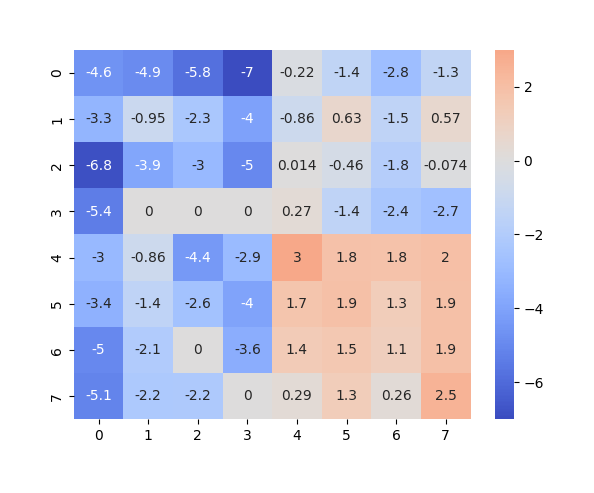

In [337]:
#Connectivity enrichment heat map
#Values from previous cell were compiled in a .csv file called "connectivity_heatmap_values", 
#and then observed counts from "directional_connection_matrix" were normalized using:

#(Observed celltype_1->celltype_2 count/total number of counts in observed dataset)/
#(Bootstrapped mean celltype_1 -> celltype_2/sum of all bootstrapped count averages)

#Which gives enrichment fold score which is used to plot the following heat map:

#CSV was also reordered to correspond to cell type ordering scheme used previously, and then logfold 2 of normalized 
#connectivity score was calculated and plotted

# generating 2-D 10x10 matrix of random numbers 
# from 1 to 100 
heatmap=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/ordered_heatmap_values.csv',delimiter=',')
heatmap=heatmap['log_fold_2']
heatmap = heatmap.to_numpy()
heatmap=np.asmatrix(heatmap)
heatmap = heatmap.reshape((8, 8))
print(heatmap)


#plotting the heatmap 

connectivity_matrix = sns.heatmap(data=heatmap, 
               center=0,
               vmin=-7,
                cmap=sns.color_palette("coolwarm", as_cmap=True),
                vmax=3,
                annot=True,)
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/connectivity_matrix.svg', bbox_inches='tight', format='svg')
plt.show()

In [ ]:
#One sample t-test for each cell-type pairing w/ Bonferroni Correction (*64), p-values added to 'ordered_heatmap_values.csv'
#Popmeans is manually set to observed count numbers from 'ordered_heatmap_values.csv'
con=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/bootstrapped_connectivity_counts.csv',delimiter=',')
con= con.loc[:, ~con.columns.str.contains('^Unnamed')]
con.set_index('celltypes', inplace=True)

#R->R
a=con.loc['RG-RG']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=9)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#R->O
a=con.loc['RG-OPCs']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=1)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#R->A
a=con.loc['RG-Astrocytes']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=2)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#R->P
a=con.loc['RG-Progenitors']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=1)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#R->I
a=con.loc['RG-In']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=35)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#R->L23
a=con.loc['RG-L2/3']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=131)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#R->L4
a=con.loc['RG-L4']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=9)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#R->L56SP
a=con.loc['RG-L5/6/SP']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=14)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#O->R
a=con.loc['OPCs-RG']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=3)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#O->O
a=con.loc['OPCs-OPCs']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=2)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#O->A
a=con.loc['OPCs-Astrocytes']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=3)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#O->P
a=con.loc['OPCs-Progenitors']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=1)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#O->I
a=con.loc['OPCs-In']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=3)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#O->L23
a=con.loc['OPCs-L2/3']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=71)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#O->L4
a=con.loc['OPCs-L4']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=3)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#O->L56SP
a=con.loc['OPCs-L5/6/SP']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=7)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#A->R
a=con.loc['Astrocytes-RG']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=1)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#A->O
a=con.loc['Astrocytes-OPCs']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=1)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#A->A
a=con.loc['Astrocytes-Astrocytes']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=7)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#A->P
a=con.loc['Astrocytes-Progenitors']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=2)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0.0*64)

#A->I
a=con.loc['Astrocytes-In']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=21)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(1.3005920094846614e-05*64)

#A->L23
a=con.loc['Astrocytes-L2/3']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=128)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#A->L4
a=con.loc['Astrocytes-L4']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=9)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#A->L56SP
a=con.loc['Astrocytes-L5/6/SP']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=17)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(9.524439002644996e-98*64)

#P->R
a=con.loc['Progenitors-RG']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=3)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#P->0
a=con.loc['Progenitors-OPCs']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=0)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#P->A
a=con.loc['Progenitors-Astrocytes']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=0)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#P->P
a=con.loc['Progenitors-Progenitors']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=0)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#P->I
a=con.loc['Progenitors-In']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=28)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#P->L2/3
a=con.loc['Progenitors-L2/3']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=72)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#P->L4
a=con.loc['Progenitors-L4']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=7)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#P->L56SP
a=con.loc['Progenitors-L5/6/SP']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=3)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#I->R
a=con.loc['In-RG']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=5)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#I->A
a=con.loc['In-Astrocytes']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=1)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#I->P
a=con.loc['In-Progenitors']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=3)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#I->I
a=con.loc['In-In']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=60)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#I->L23
a=con.loc['In-L2/3']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=229)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#I->L4
a=con.loc['In-L4']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=41)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#I->L56SP
a=con.loc['In-L5/6/SP']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=26)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L23->RG
a=con.loc['L2/3-RG']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=32)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L23->O
a=con.loc['L2/3-OPCs']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=17)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L23->A
a=con.loc['L2/3-Astrocytes']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=29)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L23->P
a=con.loc['L2/3-Progenitors']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=12)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L23->I
a=con.loc['L2/3-In']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=206)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L23->L23
a=con.loc['L2/3-L2/3']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=2039)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L23->L4
a=con.loc['L2/3-L4']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=236)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L23->L56SP
a=con.loc['L2/3-L5/6/SP']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=208)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L4->R
a=con.loc['L4-RG']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=2)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L4->O
a=con.loc['L4-OPCs']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=2)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L4->A
a=con.loc['L4-Astrocytes']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=0)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L4->P
a=con.loc['L4-Progenitors']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=3)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L4->I
a=con.loc['L4-In']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=30)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L4->L23
a=con.loc['L4-L2/3']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=285)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L4->L4
a=con.loc['L4-L4']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=40)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L4->L56SP
a=con.loc['L4-L5/6/SP']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=38)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L56SP->R
a=con.loc['L5/6/SP-RG']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=1)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L56SP->O
a=con.loc['L5/6/SP-OPCs']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=1)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L56SP->A
a=con.loc['L5/6/SP-Astrocytes']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=4)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L56SP->P
a=con.loc['L5/6/SP-Progenitors']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=0)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L56SP->I
a=con.loc['L5/6/SP-In']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=8)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L56SP->L23
a=con.loc['L5/6/SP-L2/3']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=132)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L56SP->L4
a=con.loc['L5/6/SP-L4']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=12)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

#L56SP->L56SP
a=con.loc['L5/6/SP-L5/6/SP']
a = np.array(a)
results=stats.ttest_1samp(a, popmean=32)
print(results)
print('Bonferroni-corrected pvalue (x64):')
print(0*64)

In [ ]:
EMPTY DROPLET ANALYSIS

In [ ]:
NUC ONLY

In [690]:
#Pull empty droplets for nuc datasets
n1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n1_empty.drop(n1_empty[n1_empty['NUM_READS'] > 10].index, inplace=True)
n1_empty['GENERATED_BARCODE'] = 'n1_' + n1_empty['GENERATED_BARCODE'].astype(str)

n2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n2_empty.drop(n2_empty[n2_empty['NUM_READS'] > 10].index, inplace=True)
n2_empty['GENERATED_BARCODE'] = 'n2_' + n2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([n1_empty, n2_empty], axis=0, ignore_index=True)

In [691]:
#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

In [692]:
#Get all cell-matched barcodes, w/o UMI thresholding
actualbarcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('n')] 

In [693]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

1.2041199826559248
3.461198288622493
Number of nuc:
1307
Mean of total transcripts per cell/nuc
147.48201989288447
Median of total transcripts per cell/nuc
116.0
sem of total transcripts per cell/nuc
3.9549673296693157
0.0
2.510545010206612
Number of empty droplets:
196934
Mean of total transcripts per empty droplet
1.3570587100246783
Median of total transcripts per empty droplet
1.0
sem of total transcripts per empty droplet
0.004372372438318191


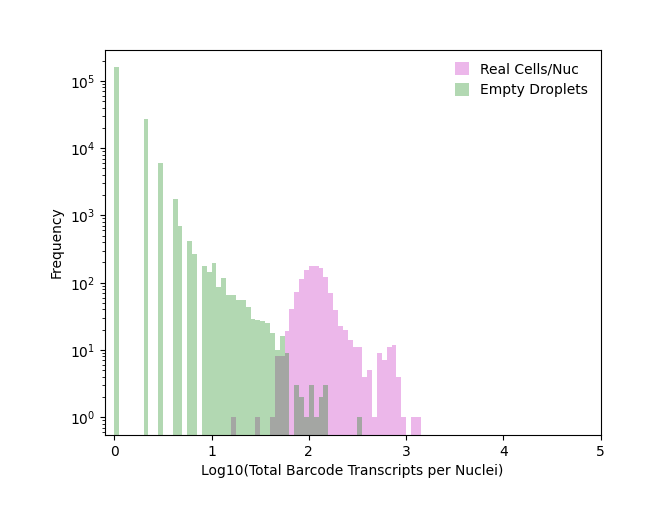

Wilcoxon Ranked Sum to compare distributions:
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-62.40621621508335, pvalue=0.0)


In [694]:
#Plot total transcripts distribution
print(np.log10(summed['UMI_Count'].min()))
print(np.log10(summed['UMI_Count'].max()))
print('Number of nuc:')
print(summed['CBC'].nunique())
print('Mean of total transcripts per cell/nuc')
print(summed['UMI_Count'].mean())
print('Median of total transcripts per cell/nuc')
print(summed['UMI_Count'].median())
print('sem of total transcripts per cell/nuc')
print(summed['UMI_Count'].sem())

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()
print(np.log10(summed_empty['UMI_Count'].min()))
print(np.log10(summed_empty['UMI_Count'].max()))
print('Number of empty droplets:')
print(summed_empty['CBC'].nunique())
print('Mean of total transcripts per empty droplet')
print(summed_empty['UMI_Count'].mean())
print('Median of total transcripts per empty droplet')
print(summed_empty['UMI_Count'].median())
print('sem of total transcripts per empty droplet')
print(summed_empty['UMI_Count'].sem())

summed_empty.to_csv('/Users/maddieurbanek/Desktop/summed_empty.csv')
summed.to_csv('/Users/maddieurbanek/Desktop/summed.csv')

plt.figure().set_figheight(5)
#Set bins to the max values printed above

plt.hist((np.log10(summed['UMI_Count'])),bins=np.arange(0, 3.461198288622493 + .01, .05),alpha=0.5,color='orchid',label='Real Cells/Nuc')
plt.hist((np.log10(summed_empty['UMI_Count'])),bins=np.arange(0, 3.461198288622493 + .01, .05),alpha=0.3,color='green',label='Empty Droplets')

plt.xlim([-.1, 5])
plt.legend(loc='upper right')
plt.xlabel('Log10(Total Barcode Transcripts per Nuclei)')
plt.ylabel('Frequency')
plt.yscale('log')
#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/nuc_total_transcripts.svg', bbox_inches='tight', format='svg')
plt.show()

print('Wilcoxon Ranked Sum to compare distributions:')

import numpy as np
from scipy.stats import ranksums

drop_dist = summed_empty['UMI_Count']
cell_dist = summed['UMI_Count']

print('Wilcoxon Ranked Sum Results:')
print(ranksums(drop_dist, cell_dist))

1
862
Number of nuc:barcode combos:
157073
Mean of unique barcode transcripts per cell/nuc
1.227193725210571
Median of unique barcode transcripts per cell/nuc
1.0
sem of total transcripts per cell/nuc
0.009885664497003921
1
240
Number of droplet:barcode combos:
239338
Mean of unique barcode transcripts per empty droplet
1.1166258596629035
Median of unique barcode transcripts per empty droplet
1.0
sem of total transcripts per empty droplet
0.0029322203917492877


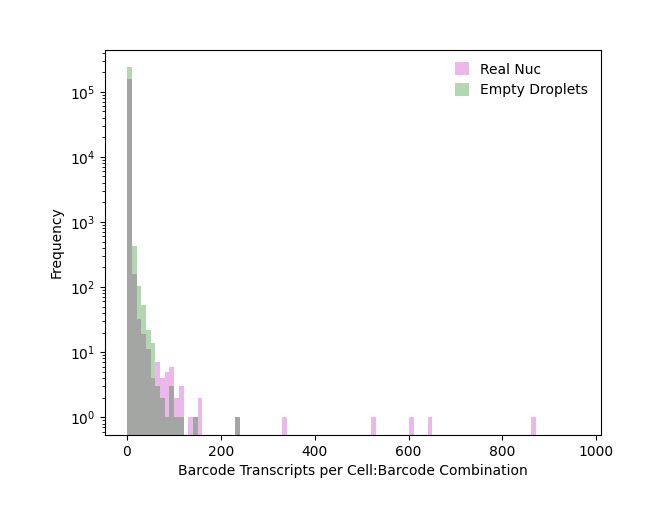

Wilcoxon Ranked Sum to compare distributions:
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-39.80660983962146, pvalue=0.0)


In [695]:
#Plot combo
print((nuc_barcodes['UMI_Count'].min()))
print((nuc_barcodes['UMI_Count'].max()))
print('Number of nuc:barcode combos:')
print(len(nuc_barcodes))
print('Mean of unique barcode transcripts per cell/nuc')
print(nuc_barcodes['UMI_Count'].mean())
print('Median of unique barcode transcripts per cell/nuc')
print(nuc_barcodes['UMI_Count'].median())
print('sem of total transcripts per cell/nuc')
print(nuc_barcodes['UMI_Count'].sem())

print((empty_barcodes['UMI_Count'].min()))
print((empty_barcodes['UMI_Count'].max()))
print('Number of droplet:barcode combos:')
print(len(empty_barcodes))
print('Mean of unique barcode transcripts per empty droplet')
print(empty_barcodes['UMI_Count'].mean())
print('Median of unique barcode transcripts per empty droplet')
print(empty_barcodes['UMI_Count'].median())
print('sem of total transcripts per empty droplet')
print(empty_barcodes['UMI_Count'].sem())

plt.figure().set_figheight(5)
#Set bins to the max values printed above

plt.hist(((nuc_barcodes['UMI_Count'])),bins=np.arange(1, 862 + 100, 10),alpha=0.5,color='orchid',label='Real Nuc')
plt.hist(((empty_barcodes['UMI_Count'])),bins=np.arange(1, 240 + 100, 10),alpha=0.3,color='green',label='Empty Droplets')


#plt.xlim([-.1, 5])
plt.legend(loc='upper right')
plt.xlabel('Barcode Transcripts per Cell:Barcode Combination')
plt.ylabel('Frequency')
plt.yscale('log')
#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/nuc_combo_transcripts.svg', bbox_inches='tight', format='svg')
plt.show()

print('Wilcoxon Ranked Sum to compare distributions:')

import numpy as np
from scipy.stats import ranksums

drop_dist = empty_barcodes['UMI_Count']
cell_dist = nuc_barcodes['UMI_Count']

print('Wilcoxon Ranked Sum Results:')
print(ranksums(drop_dist, cell_dist))

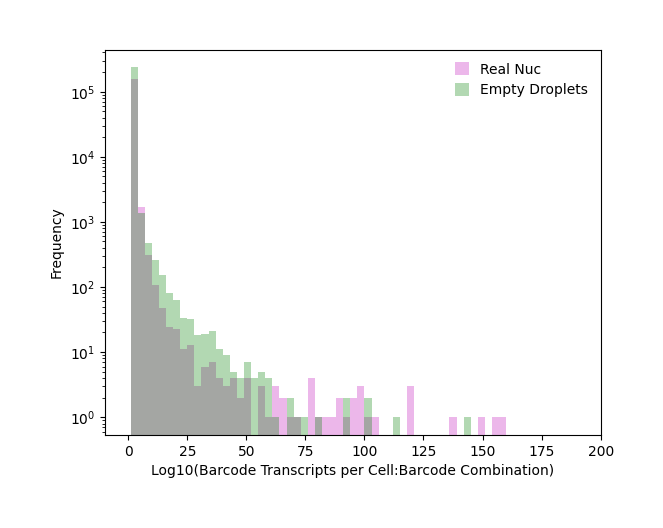

In [1207]:
#Zoomed
plt.figure().set_figheight(5)
#Set bins to the max values printed above

plt.hist(((nuc_barcodes['UMI_Count'])),bins=np.arange(1, 24169 + 100, 3),alpha=0.5,color='orchid',label='Real Nuc')
plt.hist(((empty_barcodes['UMI_Count'])),bins=np.arange(1, 533 + 100, 3),alpha=0.3,color='green',label='Empty Droplets')

plt.xlim([-10, 200])
plt.legend(loc='upper right')
plt.xlabel('Log10(Barcode Transcripts per Cell:Barcode Combination)')
plt.ylabel('Frequency')
plt.yscale('log')
#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/nuc_zoomed_combo_transcripts.svg', bbox_inches='tight', format='svg')
plt.show()

In [696]:
#Calculate % of UMIs each barcode takes up per cell

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


In [697]:
actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

combo_actual=new_actual.copy(deep=True)
combo_empty=new_empty.copy(deep=True)
print(len(new_actual))
new_actual=new_actual.drop_duplicates('CBC').sort_index()
print(len(new_actual))
new_empty=new_empty.drop_duplicates('CBC').sort_index()


157073
1307


1.146128035678238
3.209783014848515
Number of nuc:
1307
Mean of unique barcodes for cell/nuc
2.0250978131934567
Median of unique barcodes for cell/nuc
2.0
SEM of unique barcodes for cell/nuc
0.00523651323796154
Mean of unique barcodes for cell/nuc
120.17827084927315
Median of unique barcodes for cell/nuc
100.0
SEM of unique barcodes for cell/nuc
2.541922688891627
0.0
1.7708520116421442
Number of droplets:
196934
Mean of unique barcodes for empty droplet
0.058296797500817794
Median of unique barcodes for empty droplet
0.0
SEM of unique barcodes for empty droplet
0.00030262947999959634
Mean of unique barcodes for empty droplet
1.2153208689205521
Median of unique barcodes for empty droplet
1.0
SEM of empty droplets for cell/nuc
0.0013545559485691593


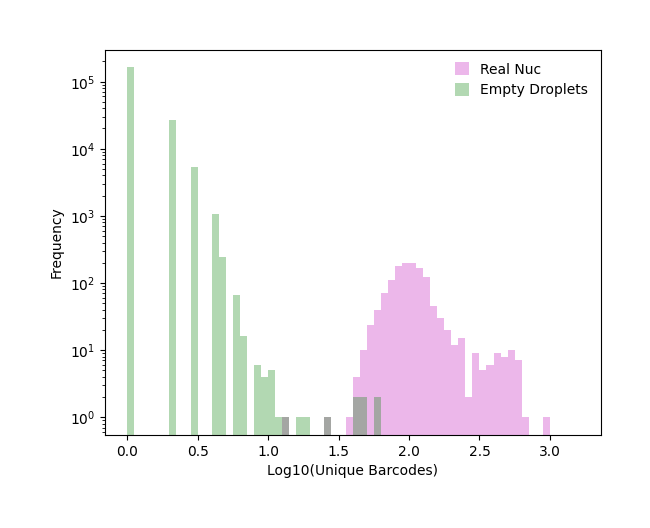

Wilcoxon Ranked Sum to compare distributions:
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-62.410907111366484, pvalue=0.0)


In [698]:
#Plot unique number of barcodes per cell/droplet
print(new_actual['logged_unique'].min())
print(new_actual['logged_unique'].max())
print('Number of nuc:')
print(new_actual['CBC'].nunique())
print('Mean of unique barcodes for cell/nuc')
print(new_actual['logged_unique'].mean())
print('Median of unique barcodes for cell/nuc')
print(new_actual['logged_unique'].median())
print('SEM of unique barcodes for cell/nuc')
print(new_actual['logged_unique'].sem())

print('Mean of unique barcodes for cell/nuc')
print(new_actual['barcode_y'].mean())
print('Median of unique barcodes for cell/nuc')
print(new_actual['barcode_y'].median())
print('SEM of unique barcodes for cell/nuc')
print(new_actual['barcode_y'].sem())

print((new_empty['logged_unique'].min()))
print(new_empty['logged_unique'].max())
print('Number of droplets:')
print(new_empty['CBC'].nunique())
print('Mean of unique barcodes for empty droplet')
print(new_empty['logged_unique'].mean())
print('Median of unique barcodes for empty droplet')
print(new_empty['logged_unique'].median())
print('SEM of unique barcodes for empty droplet')
print(new_empty['logged_unique'].sem())

print('Mean of unique barcodes for empty droplet')
print(new_empty['barcode_y'].mean())
print('Median of unique barcodes for empty droplet')
print(new_empty['barcode_y'].median())
print('SEM of empty droplets for cell/nuc')
print(new_empty['barcode_y'].sem())

new_empty.to_csv('/Users/maddieurbanek/Desktop/new_empty.csv')
new_actual.to_csv('/Users/maddieurbanek/Desktop/new_actual.csv')

plt.figure().set_figheight(5)
#Set bins to the max values printed above

plt.hist(((new_actual['logged_unique'])),bins=np.arange(0, 3.209783014848515 + .01, .05),alpha=0.5,color='orchid',label='Real Nuc')
plt.hist(((new_empty['logged_unique'])),bins=np.arange(0, 3.209783014848515 + .01, .05),alpha=0.3,color='green',label='Empty Droplets')

plt.legend(loc='upper right')
plt.xlabel('Log10(Unique Barcodes)')
plt.ylabel('Frequency')
plt.yscale('log')
#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/nuc_unique_barcode.svg', bbox_inches='tight', format='svg')
plt.show()

print('Wilcoxon Ranked Sum to compare distributions:')

import numpy as np
from scipy.stats import ranksums

drop_dist = new_empty['logged_unique']
cell_dist = new_actual['logged_unique']

print('Wilcoxon Ranked Sum Results:')
print(ranksums(drop_dist, cell_dist))

In [699]:
new_empty['logged_combo']=np.log10(new_empty['UMI_Count_x'])
new_actual['logged_combo']=np.log10(new_actual['UMI_Count_x'])
new_actual['datasetid']='actual'
new_empty['datasetid']='empty'
barplot=pd.concat([new_actual, new_empty], axis=0)

In [700]:
combos = barplot[['logged_combo', 'datasetid']].copy()
combos[['origin']]='combo'
print(combos)

subset_barplot=barplot.copy(deep=True)
subset_barplot=subset_barplot.drop_duplicates(subset=['CBC'])

totals = subset_barplot[['logged_total', 'datasetid']].copy()
totals.columns=['logged_combo','datasetid']
totals[['origin']]='totals'
print(totals)

uniques = subset_barplot[['logged_unique', 'datasetid']].copy()
uniques.columns=['logged_combo','datasetid']
uniques[['origin']]='unique'
print(uniques)

barplot_input=pd.concat([combos, totals, uniques], axis=0)
print(barplot_input)

        logged_combo datasetid origin
0                0.0    actual  combo
1                0.0    actual  combo
2                0.0    actual  combo
3                0.0    actual  combo
4                0.0    actual  combo
...              ...       ...    ...
239333           0.0     empty  combo
239334           0.0     empty  combo
239335           0.0     empty  combo
239336           0.0     empty  combo
239337           0.0     empty  combo

[198241 rows x 3 columns]
        logged_combo datasetid  origin
0           2.703291    actual  totals
1           2.033424    actual  totals
2           2.136721    actual  totals
3           2.382017    actual  totals
4           2.117271    actual  totals
...              ...       ...     ...
239333      0.000000     empty  totals
239334      0.000000     empty  totals
239335      0.000000     empty  totals
239336      0.000000     empty  totals
239337      0.000000     empty  totals

[198241 rows x 3 columns]
        logged_combo d

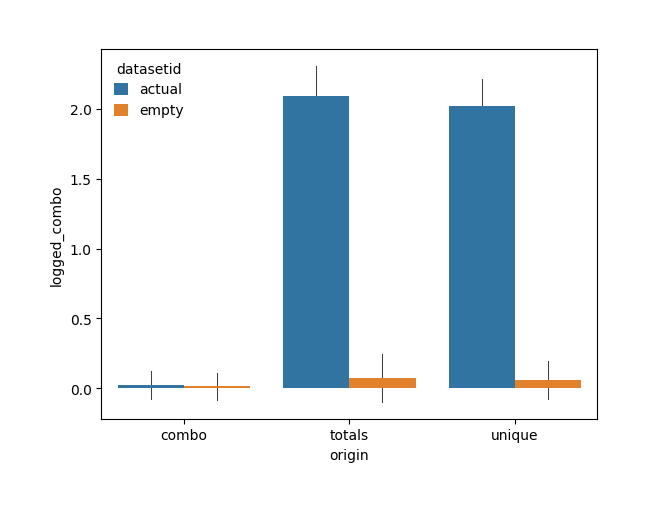

Welchs T-test to compare means for cell:barcode combos:
TtestResult(statistic=3.9062070105527034, pvalue=9.849510331999409e-05, df=1321.9622311260594)
Welchs T-test to compare means for total transcripts:
TtestResult(statistic=341.18957237510875, pvalue=0.0, df=1317.25250146467)
Welchs T-test to compare means for unique barcodes:
TtestResult(statistic=374.967967629754, pvalue=0.0, df=1314.738382346623)


In [701]:
#Summary stats bar plot
ax=sns.barplot(data=barplot_input, x="origin", y="logged_combo", hue="datasetid",errorbar="sd",zorder=10)
#ax=sns.swarmplot(x="origin", y="logged_combo", data=barplot_input, color="0", alpha=.1)
#ax.figure.savefig("/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/nuc_pre_stats.svg")
plt.show()


print('Welchs T-test to compare means for cell:barcode combos:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(new_actual['logged_combo'], new_empty['logged_combo'],equal_var=False))

print('Welchs T-test to compare means for total transcripts:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(new_actual['logged_total'], new_empty['logged_total'],equal_var=False))

print('Welchs T-test to compare means for unique barcodes:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(new_actual['logged_unique'], new_empty['logged_unique'],equal_var=False))

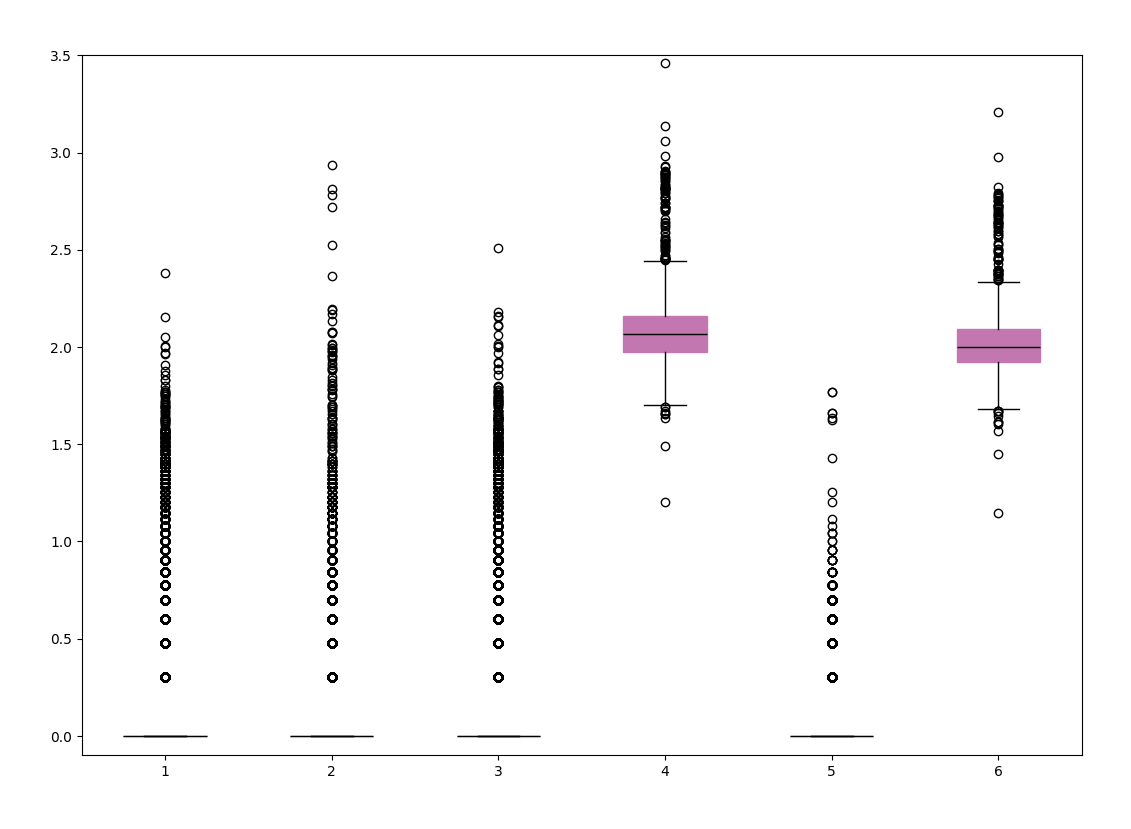

In [702]:
#Box plot since data is non-normal
total_droplets=barplot_input.loc[barplot_input['origin'] == 'totals']
total_nuc=total_droplets.loc[total_droplets['datasetid'] == 'actual']
total_droplets=total_droplets.loc[total_droplets['datasetid'] == 'empty']

unique_droplets=barplot_input.loc[barplot_input['origin'] == 'unique']
unique_nuc=unique_droplets.loc[unique_droplets['datasetid'] == 'actual']
unique_droplets=unique_droplets.loc[unique_droplets['datasetid'] == 'empty']
c='#c277b1'
#altogether
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([np.log10(empty_barcodes['UMI_Count']), np.log10(nuc_barcodes['UMI_Count']),total_droplets['logged_combo'], total_nuc['logged_combo'],unique_droplets['logged_combo'], unique_nuc['logged_combo']],patch_artist=True,
            boxprops=dict(facecolor=c, color=c),medianprops=dict(color='black'))
bp=ax.set_ylim([-0.1, 3.5])
# show plot
#ax.figure.savefig("/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/nuc_box_whisker.svg")
plt.show()

In [703]:
#Mann-whitney test of medians for each metric
from scipy.stats import ranksums

print('Combos')
print(ranksums(np.log10(empty_barcodes['UMI_Count']), np.log10(nuc_barcodes['UMI_Count'])))
print('Bonferroni Adjusted')
print(0.0*3)
print('Totals')
print(ranksums(total_droplets['logged_combo'], total_nuc['logged_combo']))
print('Bonferroni Adjusted')
print(0.0*3)
print('Unique')
print(ranksums(unique_droplets['logged_combo'], unique_nuc['logged_combo']))
print('Bonferroni Adjusted')
print(0.0*3)


Combos
RanksumsResult(statistic=-39.80660983962146, pvalue=0.0)
Bonferroni Adjusted
0.0
Totals
RanksumsResult(statistic=-62.40621621508335, pvalue=0.0)
Bonferroni Adjusted
0.0
Unique
RanksumsResult(statistic=-62.410907111366484, pvalue=0.0)
Bonferroni Adjusted
0.0


In [ ]:
NO THRESHOLDING

In [1314]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('n')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 1].index, inplace=True)

#Pull empty droplets for all datasets
n1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n1_empty.drop(n1_empty[n1_empty['NUM_READS'] > 10].index, inplace=True)
n1_empty['GENERATED_BARCODE'] = 'n1_' + n1_empty['GENERATED_BARCODE'].astype(str)

n2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n2_empty.drop(n2_empty[n2_empty['NUM_READS'] > 10].index, inplace=True)
n2_empty['GENERATED_BARCODE'] = 'n2_' + n2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([n1_empty, n2_empty], axis=0, ignore_index=True)
print(empty['GENERATED_BARCODE'].nunique())
#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 1].index, inplace=True)
print(empty_barcodes['CBC'].nunique())

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/38868238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 1].index, inplace=True)


3895198
196934


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/38868238.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 1].index, inplace=True)


In [1214]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


        Unnamed: 0                  CBC  \
0                0  n1_ATCTATTGCATCAGGA   
1              271  n1_CCAGACGCAGTCATGT   
2              333  n1_AGCGCATTACCTAGCA   
3              349  n1_ATGCCCTAAGGCAATC   
4              461  n1_AAGGCCGAACGAAGAA   
...            ...                  ...   
239333    11814395  n2_ATGGACATAGCTACGC   
239334    11814585  n2_AGTGCAAAACTACAGC   
239335    11814695  n2_ATGCAATGAAAGAACA   
239336    11814831  n2_CATACCGTCATCCATA   
239337    11814857  n2_ATCTCAGGCCACACTC   

                                                  barcode  UMI_Count_x  \
0       n1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...            1   
1       n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...            1   
2       n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...            1   
3       n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...            1   
4       n1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...            1   
...                                    

In [1217]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
41754
Unique barcodes detected across all real nuc:
13171
Unique barcodes overlapping between real nuc and empty droplets:
12282
Unique barcodes exclusive to empty droplets:
29472
Unique barcodes exclusive to real nuc:
889
Number of usable nuc
1307
Number of empty droplets
196934


In [ ]:
THRESHOLDING AT ≥2

In [1218]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('n')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 2].index, inplace=True)

#Pull empty droplets for all datasets
n1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n1_empty.drop(n1_empty[n1_empty['NUM_READS'] > 10].index, inplace=True)
n1_empty['GENERATED_BARCODE'] = 'n1_' + n1_empty['GENERATED_BARCODE'].astype(str)

n2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n2_empty.drop(n2_empty[n2_empty['NUM_READS'] > 10].index, inplace=True)
n2_empty['GENERATED_BARCODE'] = 'n2_' + n2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([n1_empty, n2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 2].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3097395110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 2].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3097395110.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 2].index, inplace=True)


In [1219]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


      Unnamed: 0                  CBC  \
0           2427  n1_CATTCCATCAGTAGAT   
1           4383  n1_CCGTACCGCCGTATTT   
2           5533  n1_CATACATTCCGTAGGT   
3           5601  n1_AGCCCCGAAGCTATGT   
4          12498  n1_ACTCCCCGCCAGCAGG   
...          ...                  ...   
7195    11812675  n2_ATTTAGCCATTAACTG   
7196    11812743  n2_ATGCCATTAACAATAA   
7197    11812750  n2_ACGCAAGTACCCATTT   
7198    11813260  n2_ACCCAAGCAGACCACC   
7199    11813780  n2_CAGGAGCGACCACCTG   

                                                barcode  UMI_Count_x  \
0     n1_AATTCAAACCCCTGGCGATGG-GATCATGACGCCGGGTCAAG-...            2   
1     n1_AATTCAAACCCCTGGCGATGG-GATCGATCGAAAGCGCCAGG-...            2   
2     n1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           22   
3     n1_AATTCAAACCCCTGGCGATGG-GATCGGCGGGACGCATCTCG-...            3   
4     n1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...            4   
...                                                 ...          ...   
719

In [1220]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
6440
Unique barcodes detected across all real nuc:
4659
Unique barcodes overlapping between real nuc and empty droplets:
823
Unique barcodes exclusive to empty droplets:
5617
Unique barcodes exclusive to real nuc:
3836
Number of usable nuc
1303
Number of empty droplets
6537


In [ ]:
THRESHOLDING AT ≥3

In [1221]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('n')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 3].index, inplace=True)

#Pull empty droplets for all datasets
n1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n1_empty.drop(n1_empty[n1_empty['NUM_READS'] > 10].index, inplace=True)
n1_empty['GENERATED_BARCODE'] = 'n1_' + n1_empty['GENERATED_BARCODE'].astype(str)

n2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n2_empty.drop(n2_empty[n2_empty['NUM_READS'] > 10].index, inplace=True)
n2_empty['GENERATED_BARCODE'] = 'n2_' + n2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([n1_empty, n2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 3].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3927926755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 3].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3927926755.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 3].index, inplace=True)


In [1222]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


      Unnamed: 0                  CBC  \
0           5533  n1_CATACATTCCGTAGGT   
1           5601  n1_AGCCCCGAAGCTATGT   
2          12498  n1_ACTCCCCGCCAGCAGG   
3          16369  n1_ATTGATTGATCTAGCC   
4          18077  n1_ACCTATGTACGTAGCC   
...          ...                  ...   
3676    11805134  n2_CATGCATACAAAAAGC   
3677    11809131  n2_ATGCCATGCAAACCGG   
3678    11812481  n2_ATTTCCAAATGAAACT   
3679    11812750  n2_ACGCAAGTACCCATTT   
3680    11813260  n2_ACCCAAGCAGACCACC   

                                                barcode  UMI_Count_x  \
0     n1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           22   
1     n1_AATTCAAACCCCTGGCGATGG-GATCGGCGGGACGCATCTCG-...            3   
2     n1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...            4   
3     n1_AATTCAACAGCCCTCTACACG-GATCGCGCGCGTGAAAATGG-...            3   
4     n1_AATTCAACAGCCCTCTACACG-GATCGGTGACTGGGGTGGGG-...            4   
...                                                 ...          ...   
367

In [1223]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
3500
Unique barcodes detected across all real nuc:
2317
Unique barcodes overlapping between real nuc and empty droplets:
139
Unique barcodes exclusive to empty droplets:
3361
Unique barcodes exclusive to real nuc:
2178
Number of usable nuc
1133
Number of empty droplets
3366


In [ ]:
THRESHOLDING AT ≥4

In [1224]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('n')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 4].index, inplace=True)

#Pull empty droplets for all datasets
n1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n1_empty.drop(n1_empty[n1_empty['NUM_READS'] > 10].index, inplace=True)
n1_empty['GENERATED_BARCODE'] = 'n1_' + n1_empty['GENERATED_BARCODE'].astype(str)

n2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n2_empty.drop(n2_empty[n2_empty['NUM_READS'] > 10].index, inplace=True)
n2_empty['GENERATED_BARCODE'] = 'n2_' + n2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([n1_empty, n2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 4].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/2679852750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 4].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/2679852750.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 4].index, inplace=True)


In [1225]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


      Unnamed: 0                  CBC  \
0           5533  n1_CATACATTCCGTAGGT   
1          12498  n1_ACTCCCCGCCAGCAGG   
2          18077  n1_ACCTATGTACGTAGCC   
3          35603  n1_AGTTAGGACCGTCCGA   
4          35658  n1_AGCGCCGGCAACCCAT   
...          ...                  ...   
2577    11798843  n2_CAGGAAGAATGTATGA   
2578    11802008  n2_AGAAAACTAAGGAAAA   
2579    11804993  n2_AAGTACAAACTTCAGC   
2580    11812481  n2_ATTTCCAAATGAAACT   
2581    11813260  n2_ACCCAAGCAGACCACC   

                                                barcode  UMI_Count_x  \
0     n1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           22   
1     n1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...            4   
2     n1_AATTCAACAGCCCTCTACACG-GATCGGTGACTGGGGTGGGG-...            4   
3     n1_AATTCAACCTCAGCGACTTCG-GATCCCATCCGACTTAGGAG-...            4   
4     n1_AATTCAACCTCAGCGACTTCG-GATCCCGTCTAACGAGCAAG-...            9   
...                                                 ...          ...   
257

In [1226]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
2481
Unique barcodes detected across all real nuc:
1379
Unique barcodes overlapping between real nuc and empty droplets:
56
Unique barcodes exclusive to empty droplets:
2425
Unique barcodes exclusive to real nuc:
1323
Number of usable nuc
847
Number of empty droplets
2399


In [ ]:
THRESHOLDING AT ≥5

In [1227]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('n')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 5].index, inplace=True)

#Pull empty droplets for all datasets
n1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n1_empty.drop(n1_empty[n1_empty['NUM_READS'] > 10].index, inplace=True)
n1_empty['GENERATED_BARCODE'] = 'n1_' + n1_empty['GENERATED_BARCODE'].astype(str)

n2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n2_empty.drop(n2_empty[n2_empty['NUM_READS'] > 10].index, inplace=True)
n2_empty['GENERATED_BARCODE'] = 'n2_' + n2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([n1_empty, n2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 5].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/68666675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 5].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/68666675.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 5].index, inplace=True)


In [1228]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


      Unnamed: 0                  CBC  \
0           5533  n1_CATACATTCCGTAGGT   
1          35658  n1_AGCGCCGGCAACCCAT   
2          46017  n1_CCGAATATAATCATTC   
3          52371  n1_ACTTAGAAAACCATTC   
4          53231  n1_AACTACACATTGAGCA   
...          ...                  ...   
1923    11790603  n2_ATTCATAACACCAACA   
1924    11795639  n2_ATGCAGCGAGGAATTC   
1925    11798843  n2_CAGGAAGAATGTATGA   
1926    11804993  n2_AAGTACAAACTTCAGC   
1927    11813260  n2_ACCCAAGCAGACCACC   

                                                barcode  UMI_Count_x  \
0     n1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           22   
1     n1_AATTCAACCTCAGCGACTTCG-GATCCCGTCTAACGAGCAAG-...            9   
2     n1_AATTCAACCTGCTGAGACCCG-GATCCAGCGCCTTGCCTTCG-...           20   
3     n1_AATTCAACCTGCTGAGACCCG-GATCGGATTTGGGGCTTCTG-...           18   
4     n1_AATTCAACCTGCTGAGACCCG-GATCGTGGAGGAGGACATTG-...            5   
...                                                 ...          ...   
192

In [1229]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
1865
Unique barcodes detected across all real nuc:
934
Unique barcodes overlapping between real nuc and empty droplets:
28
Unique barcodes exclusive to empty droplets:
1837
Unique barcodes exclusive to real nuc:
906
Number of usable nuc
628
Number of empty droplets
1793


In [ ]:
THRESHOLDING AT ≥10

In [1230]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('n')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 10].index, inplace=True)

#Pull empty droplets for all datasets
n1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n1_empty.drop(n1_empty[n1_empty['NUM_READS'] > 10].index, inplace=True)
n1_empty['GENERATED_BARCODE'] = 'n1_' + n1_empty['GENERATED_BARCODE'].astype(str)

n2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n2_empty.drop(n2_empty[n2_empty['NUM_READS'] > 10].index, inplace=True)
n2_empty['GENERATED_BARCODE'] = 'n2_' + n2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([n1_empty, n2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 10].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3687657185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 10].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3687657185.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 10].index, inplace=True)


In [1231]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


     Unnamed: 0                  CBC  \
0          5533  n1_CATACATTCCGTAGGT   
1         46017  n1_CCGAATATAATCATTC   
2         52371  n1_ACTTAGAAAACCATTC   
3         59535  n1_AACTAGCGAATAAGAC   
4         79595  n1_CCGAATATATAGAGGC   
..          ...                  ...   
735    11737944  n2_AGCCCCAGAGCTCCTT   
736    11742531  n2_ACAGAAAAAGGGACCT   
737    11790088  n2_CCTGAACTACTACCCT   
738    11795639  n2_ATGCAGCGAGGAATTC   
739    11813260  n2_ACCCAAGCAGACCACC   

                                               barcode  UMI_Count_x  \
0    n1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           22   
1    n1_AATTCAACCTGCTGAGACCCG-GATCCAGCGCCTTGCCTTCG-...           20   
2    n1_AATTCAACCTGCTGAGACCCG-GATCGGATTTGGGGCTTCTG-...           18   
3    n1_AATTCAAGAGGAAGGAGGCCG-GATCCACTCCGTAATGCAGG-...           18   
4    n1_AATTCAAGCCCATTCCCCGCG-GATCCTCCCGTCCCACCACG-...           13   
..                                                 ...          ...   
735  n2_AATTCTTGTCAGGG

In [1232]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
723
Unique barcodes detected across all real nuc:
271
Unique barcodes overlapping between real nuc and empty droplets:
7
Unique barcodes exclusive to empty droplets:
716
Unique barcodes exclusive to real nuc:
264
Number of usable nuc
239
Number of empty droplets
699


In [ ]:
THRESHOLDING AT ≥100

In [1233]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('n')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 100].index, inplace=True)

#Pull empty droplets for all datasets
n1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n1_empty.drop(n1_empty[n1_empty['NUM_READS'] > 10].index, inplace=True)
n1_empty['GENERATED_BARCODE'] = 'n1_' + n1_empty['GENERATED_BARCODE'].astype(str)

n2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_nuc/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
n2_empty.drop(n2_empty[n2_empty['NUM_READS'] > 10].index, inplace=True)
n2_empty['GENERATED_BARCODE'] = 'n2_' + n2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([n1_empty, n2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 100].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/933097121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 100].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/933097121.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 100].index, inplace=True)


In [1234]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


   Unnamed: 0                  CBC  \
0     5894474  n1_CACGCCAACCACCATA   
1    10187616  n2_CATCAGGGCAATACGT   
2    10464519  n2_ATGAACGTACTAAACT   
3    10558303  n2_CCAACAAAAAAGCACG   
4    11029813  n2_ACTAACCCCAATCCTG   

                                             barcode  UMI_Count_x  \
0  n1_AATTCTGAGGCAGCACCCCGG-GATCGAGCGCAAAATGGTGG-...          112   
1  n2_AATTCGGACGCTGCTTAACCG-GATCATGTGCCCGATTGGGG-...          142   
2  n2_AATTCGGTTTAAGCCGCCACG-GATCCGGTCAGATTAGGAGG-...          100   
3  n2_AATTCGTCACAAGCAGCCCTG-GATCTGCTTCTCGGTTTCGG-...          240   
4  n2_AATTCTCCATTGTCCGCCTTG-GATCAACAGAGCTGCAACGG-...          101   

   UMI_Count_y  percent_umi  
0          112          1.0  
1          142          1.0  
2          100          1.0  
3          240          1.0  
4          101          1.0  


In [1235]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
5
Unique barcodes detected across all real nuc:
15
Unique barcodes overlapping between real nuc and empty droplets:
0
Unique barcodes exclusive to empty droplets:
5
Unique barcodes exclusive to real nuc:
15
Number of usable nuc
14
Number of empty droplets
5


253000


In [ ]:
CELL ONLY

In [1568]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('c|s')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 1].index, inplace=True)


#Pull empty droplets for all datasets
s1_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s1/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s1_empty.drop(s1_empty[s1_empty['NUM_READS'] > 10].index, inplace=True)
s1_empty['GENERATED_BARCODE'] = 's1_' + s1_empty['GENERATED_BARCODE'].astype(str)

s2_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s2/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s2_empty.drop(s2_empty[s2_empty['NUM_READS'] > 10].index, inplace=True)
s2_empty['GENERATED_BARCODE'] = 's2_' + s2_empty['GENERATED_BARCODE'].astype(str)

s3_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s3/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s3_empty.drop(s3_empty[s3_empty['NUM_READS'] > 10].index, inplace=True)
s3_empty['GENERATED_BARCODE'] = 's3_' + s3_empty['GENERATED_BARCODE'].astype(str)

s4_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s4/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s4_empty.drop(s4_empty[s4_empty['NUM_READS'] > 10].index, inplace=True)
s4_empty['GENERATED_BARCODE'] = 's4_' + s4_empty['GENERATED_BARCODE'].astype(str)

s5_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s5/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s5_empty.drop(s5_empty[s5_empty['NUM_READS'] > 10].index, inplace=True)
s5_empty['GENERATED_BARCODE'] = 's5_' + s5_empty['GENERATED_BARCODE'].astype(str)

c1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c1_empty.drop(c1_empty[c1_empty['NUM_READS'] > 10].index, inplace=True)
c1_empty['GENERATED_BARCODE'] = 'c1_' + c1_empty['GENERATED_BARCODE'].astype(str)

c2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c2_empty.drop(c2_empty[c2_empty['NUM_READS'] > 10].index, inplace=True)
c2_empty['GENERATED_BARCODE'] = 'c2_' + c2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([s1_empty, s2_empty, s3_empty, s4_empty, s5_empty, c1_empty, c2_empty], axis=0, ignore_index=True)
print(empty['GENERATED_BARCODE'].nunique())
#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 1].index, inplace=True)
print(empty_barcodes['CBC'].nunique())

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3849044170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 1].index, inplace=True)


4324550
253000


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3849044170.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 1].index, inplace=True)


In [1569]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


        Unnamed: 0                  CBC  \
0         11815034  c1_ATCTCAAACATCAGGA   
1         11815067  c1_ACCTAAGTCCTTCATA   
2         11815085  c1_CCATCCGGAGGGAACG   
3         11815098  c1_AACTATGCAGTAAATA   
4         11815106  c1_CCCGCATTCAGTACTC   
...            ...                  ...   
315445    37523553  s5_AAGGACTCAACGAGCA   
315446    37523567  s5_CCATAACTAAAAAGGA   
315447    37523925  s5_ATAACCTCAAACAGGC   
315448    37524097  s5_AGATATGCATCGCAAA   
315449    37524135  s5_ACAGCAGCATAGAGAC   

                                                  barcode  UMI_Count_x  \
0       c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...            1   
1       c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...            1   
2       c1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...            1   
3       c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...            5   
4       c1_AATTCAAACCCCTGGCGATGG-GATCACCGAGTCAGGTTCAG-...            1   
...                                    

In [1251]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
40032
Unique barcodes detected across all real nuc:
25699
Unique barcodes overlapping between real nuc and empty droplets:
18945
Unique barcodes exclusive to empty droplets:
21087
Unique barcodes exclusive to real nuc:
6754
Number of usable nuc
16036
Number of empty droplets
253000


In [ ]:
THRESHOLDHING AT ≤2

In [1252]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('c|s')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 2].index, inplace=True)


#Pull empty droplets for all datasets
s1_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s1/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s1_empty.drop(s1_empty[s1_empty['NUM_READS'] > 10].index, inplace=True)
s1_empty['GENERATED_BARCODE'] = 's1_' + s1_empty['GENERATED_BARCODE'].astype(str)

s2_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s2/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s2_empty.drop(s2_empty[s2_empty['NUM_READS'] > 10].index, inplace=True)
s2_empty['GENERATED_BARCODE'] = 's2_' + s2_empty['GENERATED_BARCODE'].astype(str)

s3_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s3/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s3_empty.drop(s3_empty[s3_empty['NUM_READS'] > 10].index, inplace=True)
s3_empty['GENERATED_BARCODE'] = 's3_' + s3_empty['GENERATED_BARCODE'].astype(str)

s4_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s4/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s4_empty.drop(s4_empty[s4_empty['NUM_READS'] > 10].index, inplace=True)
s4_empty['GENERATED_BARCODE'] = 's4_' + s4_empty['GENERATED_BARCODE'].astype(str)

s5_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s5/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s5_empty.drop(s5_empty[s5_empty['NUM_READS'] > 10].index, inplace=True)
s5_empty['GENERATED_BARCODE'] = 's5_' + s5_empty['GENERATED_BARCODE'].astype(str)

c1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c1_empty.drop(c1_empty[c1_empty['NUM_READS'] > 10].index, inplace=True)
c1_empty['GENERATED_BARCODE'] = 'c1_' + c1_empty['GENERATED_BARCODE'].astype(str)

c2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c2_empty.drop(c2_empty[c2_empty['NUM_READS'] > 10].index, inplace=True)
c2_empty['GENERATED_BARCODE'] = 'c2_' + c2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([s1_empty, s2_empty, s3_empty, s4_empty, s5_empty, c1_empty, c2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 2].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/957622970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 2].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/957622970.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 2].index, inplace=True)


In [1253]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


       Unnamed: 0                  CBC  \
0        11815098  c1_AACTATGCAGTAAATA   
1        11817786  c1_AGGAAGCGAAACATCT   
2        11817833  c1_AGGAAGCGCACTATCT   
3        11817847  c1_AGGAAGCCCATTATCT   
4        11817907  c1_AGGAAACACATTATCT   
...           ...                  ...   
37639    37513275  s5_AATTAAACAATTAGTC   
37640    37519552  s5_AAGGAACCATGTAGCG   
37641    37520766  s5_ACTGAACCATGTAGGA   
37642    37520779  s5_ACGCAACCATGTAGGA   
37643    37521169  s5_ATCGAACCATGTAGGA   

                                                 barcode  UMI_Count_x  \
0      c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...            5   
1      c1_AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-...            2   
2      c1_AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-...            3   
3      c1_AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-...            2   
4      c1_AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-...            4   
...                                                  ... 

In [1254]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
9564
Unique barcodes detected across all real nuc:
12255
Unique barcodes overlapping between real nuc and empty droplets:
5483
Unique barcodes exclusive to empty droplets:
4081
Unique barcodes exclusive to real nuc:
6772
Number of usable nuc
15995
Number of empty droplets
35594


In [ ]:
THRESHOLDING AT ≤3

In [1255]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('c|s')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 3].index, inplace=True)


#Pull empty droplets for all datasets
s1_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s1/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s1_empty.drop(s1_empty[s1_empty['NUM_READS'] > 10].index, inplace=True)
s1_empty['GENERATED_BARCODE'] = 's1_' + s1_empty['GENERATED_BARCODE'].astype(str)

s2_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s2/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s2_empty.drop(s2_empty[s2_empty['NUM_READS'] > 10].index, inplace=True)
s2_empty['GENERATED_BARCODE'] = 's2_' + s2_empty['GENERATED_BARCODE'].astype(str)

s3_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s3/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s3_empty.drop(s3_empty[s3_empty['NUM_READS'] > 10].index, inplace=True)
s3_empty['GENERATED_BARCODE'] = 's3_' + s3_empty['GENERATED_BARCODE'].astype(str)

s4_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s4/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s4_empty.drop(s4_empty[s4_empty['NUM_READS'] > 10].index, inplace=True)
s4_empty['GENERATED_BARCODE'] = 's4_' + s4_empty['GENERATED_BARCODE'].astype(str)

s5_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s5/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s5_empty.drop(s5_empty[s5_empty['NUM_READS'] > 10].index, inplace=True)
s5_empty['GENERATED_BARCODE'] = 's5_' + s5_empty['GENERATED_BARCODE'].astype(str)

c1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c1_empty.drop(c1_empty[c1_empty['NUM_READS'] > 10].index, inplace=True)
c1_empty['GENERATED_BARCODE'] = 'c1_' + c1_empty['GENERATED_BARCODE'].astype(str)

c2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c2_empty.drop(c2_empty[c2_empty['NUM_READS'] > 10].index, inplace=True)
c2_empty['GENERATED_BARCODE'] = 'c2_' + c2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([s1_empty, s2_empty, s3_empty, s4_empty, s5_empty, c1_empty, c2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 3].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3320485682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 3].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3320485682.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 3].index, inplace=True)


In [1256]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


       Unnamed: 0                  CBC  \
0        11815098  c1_AACTATGCAGTAAATA   
1        11817833  c1_AGGAAGCGCACTATCT   
2        11817907  c1_AGGAAACACATTATCT   
3        11818572  c1_CCGTACCGCCGTATTT   
4        11819049  c1_CATACATTCCGTAGGT   
...           ...                  ...   
19004    37501550  s5_CAGTCATCAATAACAT   
19005    37505228  s5_ACGCCACCCAAGAGTT   
19006    37505263  s5_AAGCACCTCAAGAGTT   
19007    37506588  s5_AAGCCACCAAGAAGTT   
19008    37509808  s5_AAAACCAGAAGACCGG   

                                                 barcode  UMI_Count_x  \
0      c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...            5   
1      c1_AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-...            3   
2      c1_AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-...            4   
3      c1_AATTCAAACCCCTGGCGATGG-GATCGATCGAAAGCGCCAGG-...            3   
4      c1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           26   
...                                                  ... 

In [1257]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
6018
Unique barcodes detected across all real nuc:
9485
Unique barcodes overlapping between real nuc and empty droplets:
3306
Unique barcodes exclusive to empty droplets:
2712
Unique barcodes exclusive to real nuc:
6179
Number of usable nuc
15070
Number of empty droplets
18174


In [ ]:
THRESHOLDING AT ≤4

In [1258]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('c|s')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 4].index, inplace=True)


#Pull empty droplets for all datasets
s1_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s1/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s1_empty.drop(s1_empty[s1_empty['NUM_READS'] > 10].index, inplace=True)
s1_empty['GENERATED_BARCODE'] = 's1_' + s1_empty['GENERATED_BARCODE'].astype(str)

s2_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s2/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s2_empty.drop(s2_empty[s2_empty['NUM_READS'] > 10].index, inplace=True)
s2_empty['GENERATED_BARCODE'] = 's2_' + s2_empty['GENERATED_BARCODE'].astype(str)

s3_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s3/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s3_empty.drop(s3_empty[s3_empty['NUM_READS'] > 10].index, inplace=True)
s3_empty['GENERATED_BARCODE'] = 's3_' + s3_empty['GENERATED_BARCODE'].astype(str)

s4_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s4/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s4_empty.drop(s4_empty[s4_empty['NUM_READS'] > 10].index, inplace=True)
s4_empty['GENERATED_BARCODE'] = 's4_' + s4_empty['GENERATED_BARCODE'].astype(str)

s5_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s5/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s5_empty.drop(s5_empty[s5_empty['NUM_READS'] > 10].index, inplace=True)
s5_empty['GENERATED_BARCODE'] = 's5_' + s5_empty['GENERATED_BARCODE'].astype(str)

c1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c1_empty.drop(c1_empty[c1_empty['NUM_READS'] > 10].index, inplace=True)
c1_empty['GENERATED_BARCODE'] = 'c1_' + c1_empty['GENERATED_BARCODE'].astype(str)

c2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c2_empty.drop(c2_empty[c2_empty['NUM_READS'] > 10].index, inplace=True)
c2_empty['GENERATED_BARCODE'] = 'c2_' + c2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([s1_empty, s2_empty, s3_empty, s4_empty, s5_empty, c1_empty, c2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 4].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3214226290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 4].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3214226290.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 4].index, inplace=True)


In [1259]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


       Unnamed: 0                  CBC  \
0        11815098  c1_AACTATGCAGTAAATA   
1        11817907  c1_AGGAAACACATTATCT   
2        11819049  c1_CATACATTCCGTAGGT   
3        11821995  c1_ACTCACAACCAGCAGG   
4        11822039  c1_ATGACCCGCCAGCAGG   
...           ...                  ...   
11900    37493562  s5_ACTCACTCAACAACCG   
11901    37501550  s5_CAGTCATCAATAACAT   
11902    37505228  s5_ACGCCACCCAAGAGTT   
11903    37505263  s5_AAGCACCTCAAGAGTT   
11904    37509808  s5_AAAACCAGAAGACCGG   

                                                 barcode  UMI_Count_x  \
0      c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...            5   
1      c1_AATTCAAACCCCTGGCGATGG-GATCCTCGTTGTGGTGCAAG-...            4   
2      c1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           26   
3      c1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...            5   
4      c1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...            4   
...                                                  ... 

In [1260]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
4303
Unique barcodes detected across all real nuc:
8396
Unique barcodes overlapping between real nuc and empty droplets:
2271
Unique barcodes exclusive to empty droplets:
2032
Unique barcodes exclusive to real nuc:
6125
Number of usable nuc
13513
Number of empty droplets
11453


In [ ]:
THRESHOLDING AT ≤5

In [1261]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('c|s')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 5].index, inplace=True)


#Pull empty droplets for all datasets
s1_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s1/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s1_empty.drop(s1_empty[s1_empty['NUM_READS'] > 10].index, inplace=True)
s1_empty['GENERATED_BARCODE'] = 's1_' + s1_empty['GENERATED_BARCODE'].astype(str)

s2_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s2/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s2_empty.drop(s2_empty[s2_empty['NUM_READS'] > 10].index, inplace=True)
s2_empty['GENERATED_BARCODE'] = 's2_' + s2_empty['GENERATED_BARCODE'].astype(str)

s3_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s3/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s3_empty.drop(s3_empty[s3_empty['NUM_READS'] > 10].index, inplace=True)
s3_empty['GENERATED_BARCODE'] = 's3_' + s3_empty['GENERATED_BARCODE'].astype(str)

s4_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s4/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s4_empty.drop(s4_empty[s4_empty['NUM_READS'] > 10].index, inplace=True)
s4_empty['GENERATED_BARCODE'] = 's4_' + s4_empty['GENERATED_BARCODE'].astype(str)

s5_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s5/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s5_empty.drop(s5_empty[s5_empty['NUM_READS'] > 10].index, inplace=True)
s5_empty['GENERATED_BARCODE'] = 's5_' + s5_empty['GENERATED_BARCODE'].astype(str)

c1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c1_empty.drop(c1_empty[c1_empty['NUM_READS'] > 10].index, inplace=True)
c1_empty['GENERATED_BARCODE'] = 'c1_' + c1_empty['GENERATED_BARCODE'].astype(str)

c2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c2_empty.drop(c2_empty[c2_empty['NUM_READS'] > 10].index, inplace=True)
c2_empty['GENERATED_BARCODE'] = 'c2_' + c2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([s1_empty, s2_empty, s3_empty, s4_empty, s5_empty, c1_empty, c2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 5].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/907067598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 5].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/907067598.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 5].index, inplace=True)


In [1262]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


      Unnamed: 0                  CBC  \
0       11815098  c1_AACTATGCAGTAAATA   
1       11819049  c1_CATACATTCCGTAGGT   
2       11821995  c1_ACTCACAACCAGCAGG   
3       11822574  c1_ACTCCCCGAGACCAGG   
4       11823380  c1_ACTCCCCGCAATCAGG   
...          ...                  ...   
8200    37487205  s5_CAGACCGTAACAACCG   
8201    37487269  s5_CCGGCCGTAACAACCG   
8202    37501550  s5_CAGTCATCAATAACAT   
8203    37505228  s5_ACGCCACCCAAGAGTT   
8204    37505263  s5_AAGCACCTCAAGAGTT   

                                                barcode  UMI_Count_x  \
0     c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...            5   
1     c1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           26   
2     c1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...            5   
3     c1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...            8   
4     c1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...           17   
...                                                 ...          ...   
820

In [1263]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
3234
Unique barcodes detected across all real nuc:
7809
Unique barcodes overlapping between real nuc and empty droplets:
1661
Unique barcodes exclusive to empty droplets:
1573
Unique barcodes exclusive to real nuc:
6148
Number of usable nuc
11878
Number of empty droplets
7923


In [ ]:
THRESHOLDING AT ≤10

In [1264]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('c|s')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 10].index, inplace=True)


#Pull empty droplets for all datasets
s1_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s1/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s1_empty.drop(s1_empty[s1_empty['NUM_READS'] > 10].index, inplace=True)
s1_empty['GENERATED_BARCODE'] = 's1_' + s1_empty['GENERATED_BARCODE'].astype(str)

s2_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s2/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s2_empty.drop(s2_empty[s2_empty['NUM_READS'] > 10].index, inplace=True)
s2_empty['GENERATED_BARCODE'] = 's2_' + s2_empty['GENERATED_BARCODE'].astype(str)

s3_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s3/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s3_empty.drop(s3_empty[s3_empty['NUM_READS'] > 10].index, inplace=True)
s3_empty['GENERATED_BARCODE'] = 's3_' + s3_empty['GENERATED_BARCODE'].astype(str)

s4_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s4/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s4_empty.drop(s4_empty[s4_empty['NUM_READS'] > 10].index, inplace=True)
s4_empty['GENERATED_BARCODE'] = 's4_' + s4_empty['GENERATED_BARCODE'].astype(str)

s5_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s5/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s5_empty.drop(s5_empty[s5_empty['NUM_READS'] > 10].index, inplace=True)
s5_empty['GENERATED_BARCODE'] = 's5_' + s5_empty['GENERATED_BARCODE'].astype(str)

c1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c1_empty.drop(c1_empty[c1_empty['NUM_READS'] > 10].index, inplace=True)
c1_empty['GENERATED_BARCODE'] = 'c1_' + c1_empty['GENERATED_BARCODE'].astype(str)

c2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c2_empty.drop(c2_empty[c2_empty['NUM_READS'] > 10].index, inplace=True)
c2_empty['GENERATED_BARCODE'] = 'c2_' + c2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([s1_empty, s2_empty, s3_empty, s4_empty, s5_empty, c1_empty, c2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 10].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/310475991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 10].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/310475991.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 10].index, inplace=True)


In [1265]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


      Unnamed: 0                  CBC  \
0       11819049  c1_CATACATTCCGTAGGT   
1       11823380  c1_ACTCCCCGCAATCAGG   
2       11830940  c1_AGCGCCGGCAACCCAT   
3       11848383  c1_AGAAAGAAAACCATTC   
4       11848536  c1_ACTTACGTAACCATTC   
...          ...                  ...   
2276    37452357  s5_ATGAACTTAAAGCCCT   
2277    37453881  s5_ACTCACTTAAAGCCCT   
2278    37456547  s5_ATTAACTTAAAGCCCT   
2279    37482324  s5_ATGGCCGTAACAACCG   
2280    37484956  s5_AGGGCCGTAACAACCG   

                                                barcode  UMI_Count_x  \
0     c1_AATTCAAACCCCTGGCGATGG-GATCGGCGATCGTGACACTG-...           26   
1     c1_AATTCAAACCCCTGGCGATGG-GATCTGTTGGCGCCAGAGAG-...           17   
2     c1_AATTCAACCTCAGCGACTTCG-GATCCCGTCTAACGAGCAAG-...           13   
3     c1_AATTCAACCTGCTGAGACCCG-GATCGGATTTGGGGCTTCTG-...           25   
4     c1_AATTCAACCTGCTGAGACCCG-GATCGGATTTGGGGCTTCTG-...           24   
...                                                 ...          ...   
227

In [1266]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
1162
Unique barcodes detected across all real nuc:
6621
Unique barcodes overlapping between real nuc and empty droplets:
570
Unique barcodes exclusive to empty droplets:
592
Unique barcodes exclusive to real nuc:
6051
Number of usable nuc
7794
Number of empty droplets
2210


In [ ]:
THRESHOLDING AT ≤100

In [1267]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
nuc_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('c|s')] 
nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 100].index, inplace=True)


#Pull empty droplets for all datasets
s1_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s1/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s1_empty.drop(s1_empty[s1_empty['NUM_READS'] > 10].index, inplace=True)
s1_empty['GENERATED_BARCODE'] = 's1_' + s1_empty['GENERATED_BARCODE'].astype(str)

s2_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s2/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s2_empty.drop(s2_empty[s2_empty['NUM_READS'] > 10].index, inplace=True)
s2_empty['GENERATED_BARCODE'] = 's2_' + s2_empty['GENERATED_BARCODE'].astype(str)

s3_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s3/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s3_empty.drop(s3_empty[s3_empty['NUM_READS'] > 10].index, inplace=True)
s3_empty['GENERATED_BARCODE'] = 's3_' + s3_empty['GENERATED_BARCODE'].astype(str)

s4_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s4/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s4_empty.drop(s4_empty[s4_empty['NUM_READS'] > 10].index, inplace=True)
s4_empty['GENERATED_BARCODE'] = 's4_' + s4_empty['GENERATED_BARCODE'].astype(str)

s5_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s5/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s5_empty.drop(s5_empty[s5_empty['NUM_READS'] > 10].index, inplace=True)
s5_empty['GENERATED_BARCODE'] = 's5_' + s5_empty['GENERATED_BARCODE'].astype(str)

c1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c1_empty.drop(c1_empty[c1_empty['NUM_READS'] > 10].index, inplace=True)
c1_empty['GENERATED_BARCODE'] = 'c1_' + c1_empty['GENERATED_BARCODE'].astype(str)

c2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c2_empty.drop(c2_empty[c2_empty['NUM_READS'] > 10].index, inplace=True)
c2_empty['GENERATED_BARCODE'] = 'c2_' + c2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([s1_empty, s2_empty, s3_empty, s4_empty, s5_empty, c1_empty, c2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 100].index, inplace=True)

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3093749636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuc_barcodes.drop(nuc_barcodes[nuc_barcodes['UMI_Count'] < 100].index, inplace=True)
/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_1966/3093749636.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_barcodes.drop(empty_barcodes[empty_barcodes['UMI_Count'] < 100].index, inplace=True)


In [1268]:
#Prep
summed=nuc_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = nuc_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


    Unnamed: 0                  CBC  \
0     12067500  c1_ACAGAGTTCAAAAAAG   
1     12640265  c1_CCACAAAAACGCCACA   
2     13160030  c1_AAACAGACAGTGACGC   
3     13167605  c1_CACTCAATATAGCATG   
4     15134460  c1_CCAAAGTCAAAGCACG   
5     15169074  c1_ATGAAATACATGAGAC   
6     15925548  c1_AACCAGGAAAAAAGAA   
7     17221217  c2_AAGCATGCAGCGCACC   
8     19773699  c2_CCAAAGAAACCAACGT   
9     20816203  c2_CCAACAAAAAAGCACG   
10    21433248  c2_AGGTATTTATCTATGG   
11    21909682  c2_CACGCCAACCACCATA   
12    22060491  c2_CCGTAGTTCACAAATG   
13    26597427  s2_CAACATAGATCGAGTA   

                                              barcode  UMI_Count_x  \
0   c1_AATTCACGACGTCCGTGGAAG-GATCGGGACAGCGATATTCG-...          101   
1   c1_AATTCATTACTCGGAGGCTCG-GATCGCAGTCATCACGAGTG-...          125   
2   c1_AATTCCCCAGGCGTTATCTTG-GATCCCGACGGTGTCGTCAG-...          533   
3   c1_AATTCCCCGACAATCAGGAGG-GATCTCCTCACTATGGACGG-...          193   
4   c1_AATTCGTCACAAGCAGCCCTG-GATCTGCTTCTCGGTTTCGG-...          1

In [1269]:
#Stacked bar plot for diversity stats in empty droplets (post-thresholding)
#Number of droplet barcodes overlapping with barcodes in actual cells
real_barcodes=new_actual['barcode']
overlap=new_empty.apply(lambda row: row[new_empty['barcode'].isin(real_barcodes)])

print('Unique barcodes detected across all empty droplets:')
print(new_empty['barcode'].nunique())
print('Unique barcodes detected across all real nuc:')
print(new_actual['barcode'].nunique())
print('Unique barcodes overlapping between real nuc and empty droplets:')
print(overlap['barcode'].nunique())

#Number of barcodes unique to empty droplets
non_overlap=new_empty.apply(lambda row: row[~new_empty['barcode'].isin(real_barcodes)])
print('Unique barcodes exclusive to empty droplets:')
print(non_overlap['barcode'].nunique())

#Number of barcodes unique to actual cells
empty_barcodes=new_empty['barcode']
real_non_overlap=new_actual.apply(lambda row: row[~new_actual['barcode'].isin(empty_barcodes)])
print('Unique barcodes exclusive to real nuc:')
print(real_non_overlap['barcode'].nunique())

#Number of cells
print('Number of usable nuc')
print(new_actual['CBC'].nunique())

#Number of empty droplets
print('Number of empty droplets')
print(new_empty['CBC'].nunique())

Unique barcodes detected across all empty droplets:
14
Unique barcodes detected across all real nuc:
3559
Unique barcodes overlapping between real nuc and empty droplets:
4
Unique barcodes exclusive to empty droplets:
10
Unique barcodes exclusive to real nuc:
3555
Number of usable nuc
3272
Number of empty droplets
14


In [674]:
actual_barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/no_threshold_barcodes.csv',delimiter=',')
actual_barcodes.drop(actual_barcodes[actual_barcodes['UMI_Count'] < 2].index, inplace=True)

#Pull empty droplets for all datasets
s1_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s1/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s1_empty.drop(s1_empty[s1_empty['NUM_READS'] > 10].index, inplace=True)
s1_empty['GENERATED_BARCODE'] = 's1_' + s1_empty['GENERATED_BARCODE'].astype(str)

s2_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s2/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s2_empty.drop(s2_empty[s2_empty['NUM_READS'] > 10].index, inplace=True)
s2_empty['GENERATED_BARCODE'] = 's2_' + s2_empty['GENERATED_BARCODE'].astype(str)

s3_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s3/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s3_empty.drop(s3_empty[s3_empty['NUM_READS'] > 10].index, inplace=True)
s3_empty['GENERATED_BARCODE'] = 's3_' + s3_empty['GENERATED_BARCODE'].astype(str)

s4_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s4/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s4_empty.drop(s4_empty[s4_empty['NUM_READS'] > 10].index, inplace=True)
s4_empty['GENERATED_BARCODE'] = 's4_' + s4_empty['GENERATED_BARCODE'].astype(str)

s5_empty=pd.read_table('/Users/maddieurbanek/Desktop/febmarch/s5/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
s5_empty.drop(s5_empty[s5_empty['NUM_READS'] > 10].index, inplace=True)
s5_empty['GENERATED_BARCODE'] = 's5_' + s5_empty['GENERATED_BARCODE'].astype(str)

c1_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw19.1/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c1_empty.drop(c1_empty[c1_empty['NUM_READS'] > 10].index, inplace=True)
c1_empty['GENERATED_BARCODE'] = 'c1_' + c1_empty['GENERATED_BARCODE'].astype(str)

c2_empty=pd.read_table('/Users/maddieurbanek/Desktop/apr2024_nuc_vs_single/gw21/cdna_cell/barcodes/generated_barcode_read_info_table.csv',delimiter=',')
c2_empty.drop(c2_empty[c2_empty['NUM_READS'] > 10].index, inplace=True)
c2_empty['GENERATED_BARCODE'] = 'c2_' + c2_empty['GENERATED_BARCODE'].astype(str)

empty = pd.concat([s1_empty, s2_empty, s3_empty, s4_empty, s5_empty, c1_empty, c2_empty], axis=0, ignore_index=True)

#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]


In [675]:
#Pull rabies barcodes corresponding to empty droplets
barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/all_barcodes.csv',delimiter=',')
empty_barcodes = barcodes[barcodes['CBC'].isin(empty['GENERATED_BARCODE'])]

In [676]:
#Get all cell-matched barcodes, w/o UMI thresholding

cell_barcodes = actualbarcodes[actualbarcodes['CBC'].str.contains('c|s')] 


In [677]:
#Prep
summed=cell_barcodes.groupby('CBC')['UMI_Count'].sum()
summed = pd.DataFrame(summed)
summed = summed.reset_index()

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']

new_actual = cell_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']

actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()

new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')


empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()

new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')


new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']


new_actual = cell_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']


1.0
4.88024177589548
Mean of total transcripts per cell/nuc
325.6369418807683
Median of total transcripts per cell/nuc
136.0
SEM of total transcripts for cell/nuc
7.8902311482870795
0.0
2.9185545305502734
Mean of total transcripts per empty droplet
1.7013162055335969
Median of total transcripts per empty droplet
1.0
SEM of total transcripts for cell/nuc
0.006706243565613764


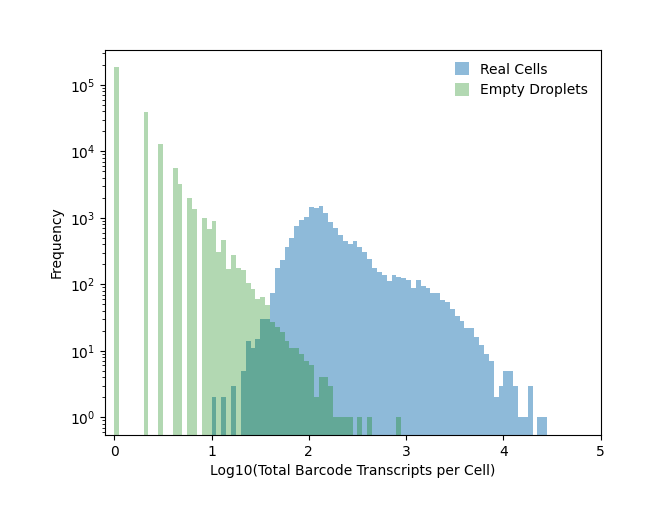

Wilcoxon Ranked Sum to compare distributions:
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-212.65985185210607, pvalue=0.0)
16036
253000


In [678]:
#Plot total transcripts distribution
print(np.log10(summed['UMI_Count'].min()))
print(np.log10(summed['UMI_Count'].max()))
print('Mean of total transcripts per cell/nuc')
print(summed['UMI_Count'].mean())
print('Median of total transcripts per cell/nuc')
print(summed['UMI_Count'].median())
print('SEM of total transcripts for cell/nuc')
print(summed['UMI_Count'].sem())

summed_empty=empty_barcodes.groupby('CBC')['UMI_Count'].sum()
summed_empty = pd.DataFrame(summed_empty)
summed_empty = summed_empty.reset_index()
print(np.log10(summed_empty['UMI_Count'].min()))
print(np.log10(summed_empty['UMI_Count'].max()))
print('Mean of total transcripts per empty droplet')
print(summed_empty['UMI_Count'].mean())
print('Median of total transcripts per empty droplet')
print(summed_empty['UMI_Count'].median())
print('SEM of total transcripts for cell/nuc')
print(summed_empty['UMI_Count'].sem())

summed.to_csv('/Users/maddieurbanek/Desktop/summed_cell.csv')
summed_empty.to_csv('/Users/maddieurbanek/Desktop/summed_empty_cell.csv')

plt.figure().set_figheight(5)
#Set bins to the max values printed above

plt.hist((np.log10(summed['UMI_Count'])),bins=np.arange(0, 4.88024177589548 + .01, .05),alpha=0.5,label='Real Cells')
plt.hist((np.log10(summed_empty['UMI_Count'])),bins=np.arange(0, 4.88024177589548 + .01, .05),alpha=0.3,color='green',label='Empty Droplets')

plt.xlim([-.1, 5])
plt.legend(loc='upper right')
plt.xlabel('Log10(Total Barcode Transcripts per Cell)')
plt.ylabel('Frequency')
plt.yscale('log')
#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/cell_total_transcripts.svg', bbox_inches='tight', format='svg')
plt.show()

print('Wilcoxon Ranked Sum to compare distributions:')

import numpy as np
from scipy.stats import ranksums

drop_dist = summed_empty['UMI_Count']
cell_dist = summed['UMI_Count']

print('Wilcoxon Ranked Sum Results:')
print(ranksums(drop_dist, cell_dist))
print(len(summed))
print(len(summed_empty))

1
24169
Mean of unique barcode transcripts per cell/nuc
3.0010741286713047
Median of unique barcode transcripts per cell/nuc
1.0
SEM of total transcripts for cell/nuc
0.0371996250584117
1
533
Mean of unique barcode transcripts per empty droplet
1.3645046758598827
Median of unique barcode transcripts per empty droplet
1.0
SEM of total transcripts for cell/nuc
0.00414490917038048


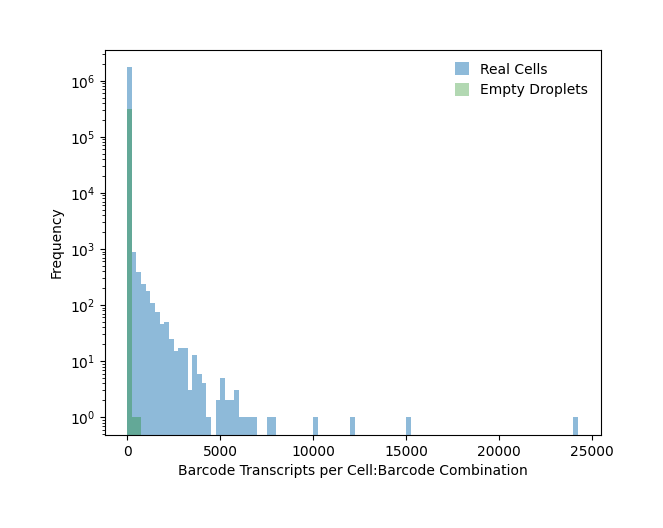

Wilcoxon Ranked Sum to compare distributions:
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-83.11174732193565, pvalue=0.0)
315450
1740015


In [679]:
#Plot combo
print((cell_barcodes['UMI_Count'].min()))
print((cell_barcodes['UMI_Count'].max()))
print('Mean of unique barcode transcripts per cell/nuc')
print(cell_barcodes['UMI_Count'].mean())
print('Median of unique barcode transcripts per cell/nuc')
print(cell_barcodes['UMI_Count'].median())
print('SEM of total transcripts for cell/nuc')
print(cell_barcodes['UMI_Count'].sem())


print((empty_barcodes['UMI_Count'].min()))
print((empty_barcodes['UMI_Count'].max()))
print('Mean of unique barcode transcripts per empty droplet')
print(empty_barcodes['UMI_Count'].mean())
print('Median of unique barcode transcripts per empty droplet')
print(empty_barcodes['UMI_Count'].median())
print('SEM of total transcripts for cell/nuc')
print(empty_barcodes['UMI_Count'].sem())

plt.figure().set_figheight(5)
#Set bins to the max values printed above

plt.hist(((cell_barcodes['UMI_Count'])),bins=np.arange(1, 24169 + 100, 250),alpha=0.5,label='Real Cells')
plt.hist(((empty_barcodes['UMI_Count'])),bins=np.arange(1, 24169 + 100, 250),alpha=0.3,color='green',label='Empty Droplets')


#plt.xlim([-.1, 5])
plt.legend(loc='upper right')
plt.xlabel('Barcode Transcripts per Cell:Barcode Combination')
plt.ylabel('Frequency')
plt.yscale('log')
#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/cell_combo_transcripts.svg', bbox_inches='tight', format='svg')
plt.show()

print('Wilcoxon Ranked Sum to compare distributions:')

import numpy as np
from scipy.stats import ranksums

drop_dist = empty_barcodes['UMI_Count']
cell_dist = cell_barcodes['UMI_Count']

print('Wilcoxon Ranked Sum Results:')
print(ranksums(drop_dist, cell_dist))
print(len(empty_barcodes))
print(len(cell_barcodes))

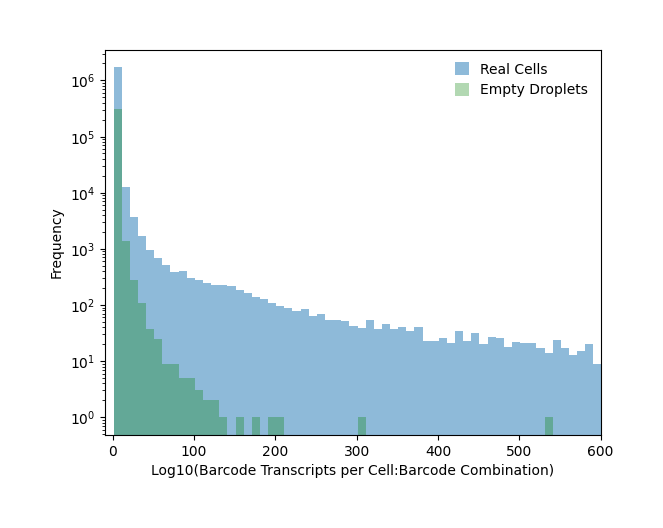

In [1295]:
#Zoomed
plt.figure().set_figheight(5)
#Set bins to the max values printed above

plt.hist(((cell_barcodes['UMI_Count'])),bins=np.arange(1, 24169 + 100, 10),alpha=0.5,label='Real Cells')
plt.hist(((empty_barcodes['UMI_Count'])),bins=np.arange(1, 24169 + 100, 10),alpha=0.3,color='green',label='Empty Droplets')

plt.xlim([-10, 600])
plt.legend(loc='upper right')
plt.xlabel('Log10(Barcode Transcripts per Cell:Barcode Combination)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/cell_zoomed_combo_transcripts.svg', bbox_inches='tight', format='svg')
plt.show()

In [680]:
#Calculate % of UMIs each barcode takes up per cell

new_empty = empty_barcodes.merge(summed_empty[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_empty['percent_umi']=new_empty['UMI_Count_x']/new_empty['UMI_Count_y']
print(new_empty)

new_actual = cell_barcodes.merge(summed[['CBC','UMI_Count']], on = 'CBC', how = 'left')
new_actual['percent_umi']=new_actual['UMI_Count_x']/new_actual['UMI_Count_y']
print(new_actual)

        Unnamed: 0                  CBC  \
0         11815034  c1_ATCTCAAACATCAGGA   
1         11815067  c1_ACCTAAGTCCTTCATA   
2         11815085  c1_CCATCCGGAGGGAACG   
3         11815098  c1_AACTATGCAGTAAATA   
4         11815106  c1_CCCGCATTCAGTACTC   
...            ...                  ...   
315445    37523553  s5_AAGGACTCAACGAGCA   
315446    37523567  s5_CCATAACTAAAAAGGA   
315447    37523925  s5_ATAACCTCAAACAGGC   
315448    37524097  s5_AGATATGCATCGCAAA   
315449    37524135  s5_ACAGCAGCATAGAGAC   

                                                  barcode  UMI_Count_x  \
0       c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...            1   
1       c1_AATTCAAACCCCTGGCGATGG-GATCAACGCTGTAACGCCTG-...            1   
2       c1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...            1   
3       c1_AATTCAAACCCCTGGCGATGG-GATCACACCCCATAGCGAAG-...            5   
4       c1_AATTCAAACCCCTGGCGATGG-GATCACCGAGTCAGGTTCAG-...            1   
...                                    

In [681]:
actual_unique=new_actual.groupby('CBC')['barcode'].nunique()
actual_unique=pd.DataFrame(actual_unique).reset_index()
print(actual_unique)
new_actual = new_actual.merge(actual_unique[['CBC','barcode']], on = 'CBC', how = 'left')
print(new_actual)

empty_unique=new_empty.groupby('CBC')['barcode'].nunique()
empty_unique=pd.DataFrame(empty_unique).reset_index()
print(empty_unique)
new_empty = new_empty.merge(empty_unique[['CBC','barcode']], on = 'CBC', how = 'left')
print(new_empty)

new_empty['logged_total']=np.log10(new_empty['UMI_Count_y'])
new_empty['logged_unique']=np.log10(new_empty['barcode_y'])

new_actual['logged_total']=np.log10(new_actual['UMI_Count_y'])
new_actual['logged_unique']=np.log10(new_actual['barcode_y'])

combo_actual=new_actual.copy(deep=True)
combo_empty=new_empty.copy(deep=True)

new_actual=new_actual.drop_duplicates('CBC').sort_index()
print(len(new_actual))
new_empty=new_empty.drop_duplicates('CBC').sort_index()
print(len(new_empty))

new_actual.to_csv('/Users/maddieurbanek/Desktop/actual_cell.csv')
new_empty.to_csv('/Users/maddieurbanek/Desktop/actual_empty_cell.csv')

                       CBC  barcode
0      c1_AAAAAAAAATCGCAGA       58
1      c1_AAAAAAACCACAAGTC       92
2      c1_AAAAAAACCCTCCCAA       56
3      c1_AAAAAACAAGCTAAGC       57
4      c1_AAAAAAGACCTTATAA       84
...                    ...      ...
16031  s5_CCTGAATGACAACATC      350
16032  s5_CCTGAATTCCCTACAT       70
16033  s5_CCTGAGGTATTGCCAT      101
16034  s5_CCTGATTGCCTGATCA      315
16035  s5_CCTGCAGTACTTACTG      201

[16036 rows x 2 columns]
         Unnamed: 0.1  Unnamed: 0                  CBC  \
0            11815097    11815097  c1_ATGTCAGAACGGATTG   
1            11815099    11815099  c1_CCTGCACTACTAAGTG   
2            11815122    11815122  c1_AACAAGAACATTCATT   
3            11815158    11815158  c1_AGGAATCACAACCAAC   
4            11815174    11815174  c1_AGGAAGTAATGAAGAT   
...               ...         ...                  ...   
1740010      37524137    37524137  s5_CCATATTGATATAAAT   
1740011      37524148    37524148  s5_CCGTCAAGCCTACCTC   
1740012      3752415

0.9542425094393249
3.074084689028244
Mean of unique barcodes for cell/nuc
108.50679720628585
Median of unique barcodes for cell/nuc
99.0
SEM of unique barcodes for cell/nuc
0.5468040368177322
0.0
2.45178643552429
Mean of unique barcodes for empty droplet
1.2468379446640316
Median of unique barcodes for empty droplet
1.0
SEM of unique barcodes for empty droplet
0.0021035248189214036


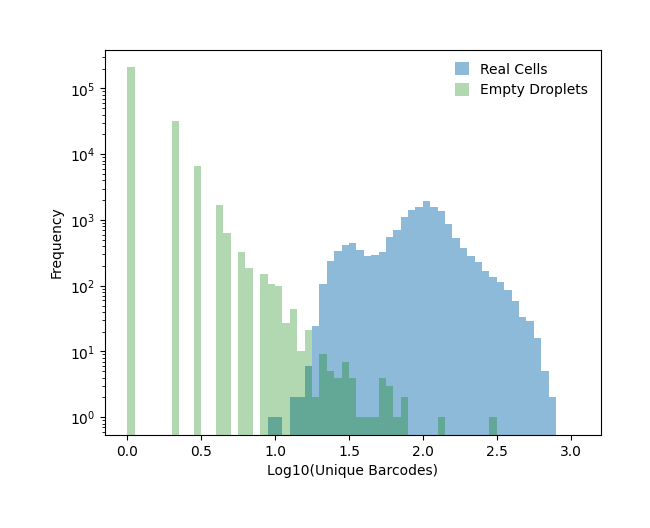

Wilcoxon Ranked Sum to compare distributions:
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-212.68898427287726, pvalue=0.0)
253000
16036


In [682]:
#Plot unique number of barcodes per cell/droplet
print(new_actual['logged_unique'].min())
print(new_actual['logged_unique'].max())
print('Mean of unique barcodes for cell/nuc')
print(new_actual['barcode_y'].mean())
print('Median of unique barcodes for cell/nuc')
print(new_actual['barcode_y'].median())
print('SEM of unique barcodes for cell/nuc')
print(new_actual['barcode_y'].sem())

print((new_empty['logged_unique'].min()))
print(new_empty['logged_unique'].max())
print('Mean of unique barcodes for empty droplet')
print(new_empty['barcode_y'].mean())
print('Median of unique barcodes for empty droplet')
print(new_empty['barcode_y'].median())
print('SEM of unique barcodes for empty droplet')
print(new_empty['barcode_y'].sem())

plt.figure().set_figheight(5)
#Set bins to the max values printed above

plt.hist(((new_actual['logged_unique'])),bins=np.arange(0, 3.074084689028244 + .01, .05),alpha=0.5,label='Real Cells')
plt.hist(((new_empty['logged_unique'])),bins=np.arange(0, 3.074084689028244 + .01, .05),alpha=0.3,color='green',label='Empty Droplets')

plt.legend(loc='upper right')
plt.xlabel('Log10(Unique Barcodes)')
plt.ylabel('Frequency')
plt.yscale('log')
#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/cell_unique_barcode.svg', bbox_inches='tight', format='svg')
plt.show()


print('Wilcoxon Ranked Sum to compare distributions:')

import numpy as np
from scipy.stats import ranksums

drop_dist = new_empty['logged_unique']
cell_dist = new_actual['logged_unique']

print('Wilcoxon Ranked Sum Results:')
print(ranksums(drop_dist, cell_dist))
print(len(drop_dist))
print(len(cell_dist))

In [683]:
#Prep datasets for bar plots
new_empty['logged_combo']=np.log10(new_empty['UMI_Count_x'])
new_actual['logged_combo']=np.log10(new_actual['UMI_Count_x'])
new_actual['datasetid']='actual'
new_empty['datasetid']='empty'
barplot=pd.concat([new_actual, new_empty], axis=0)

In [684]:
combos = barplot[['logged_combo', 'datasetid']].copy()
combos[['origin']]='combo'
print(combos)

subset_barplot=barplot.copy(deep=True)
subset_barplot=subset_barplot.drop_duplicates(subset=['CBC'])

totals = subset_barplot[['logged_total', 'datasetid']].copy()
totals.columns=['logged_combo','datasetid']
totals[['origin']]='totals'
print(totals)

uniques = subset_barplot[['logged_unique', 'datasetid']].copy()
uniques.columns=['logged_combo','datasetid']
uniques[['origin']]='unique'
print(uniques)

barplot_input=pd.concat([combos, totals, uniques], axis=0)
print(barplot_input)

        logged_combo datasetid origin
0                0.0    actual  combo
1                0.0    actual  combo
2                0.0    actual  combo
3                0.0    actual  combo
4                0.0    actual  combo
...              ...       ...    ...
315443           0.0     empty  combo
315444           0.0     empty  combo
315447           0.0     empty  combo
315448           0.0     empty  combo
315449           0.0     empty  combo

[269036 rows x 3 columns]
        logged_combo datasetid  origin
0           2.569374    actual  totals
1           2.460898    actual  totals
2           2.267172    actual  totals
3           2.181844    actual  totals
4           2.322219    actual  totals
...              ...       ...     ...
315443      0.000000     empty  totals
315444      0.000000     empty  totals
315447      0.000000     empty  totals
315448      0.000000     empty  totals
315449      0.000000     empty  totals

[269036 rows x 3 columns]
        logged_combo d

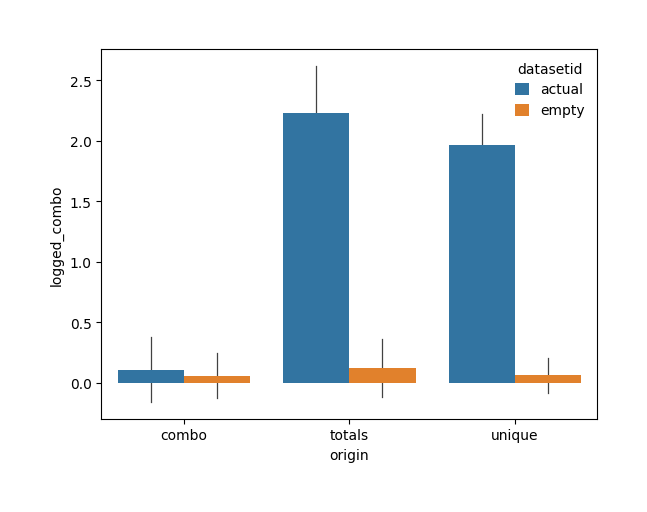

Welchs T-test to compare means for cell:barcode combos:
TtestResult(statistic=130.698018962573, pvalue=0.0, df=587050.7326226371)
Welchs T-test to compare means for total transcripts:
TtestResult(statistic=3170.8179849770277, pvalue=0.0, df=607909.359968724)
Welchs T-test to compare means for unique barcodes:
TtestResult(statistic=3956.3624030315996, pvalue=0.0, df=431990.556836039)


In [1309]:
#Summary stats bar plot
ax=sns.barplot(data=barplot_input, x="origin", y="logged_combo", hue="datasetid",errorbar="sd",zorder=10)
#ax=sns.swarmplot(x="origin", y="logged_combo", data=barplot_input, color="0", alpha=.1)
ax.figure.savefig("/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/cell_pre_stats.svg")
plt.show()

print('Welchs T-test to compare means for cell:barcode combos:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(new_actual['logged_combo'], new_empty['logged_combo'],equal_var=False))

print('Welchs T-test to compare means for total transcripts:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(new_actual['logged_total'], new_empty['logged_total'],equal_var=False))

print('Welchs T-test to compare means for unique barcodes:')
import numpy as np
from scipy import stats
print(stats.ttest_ind(new_actual['logged_unique'], new_empty['logged_unique'],equal_var=False))

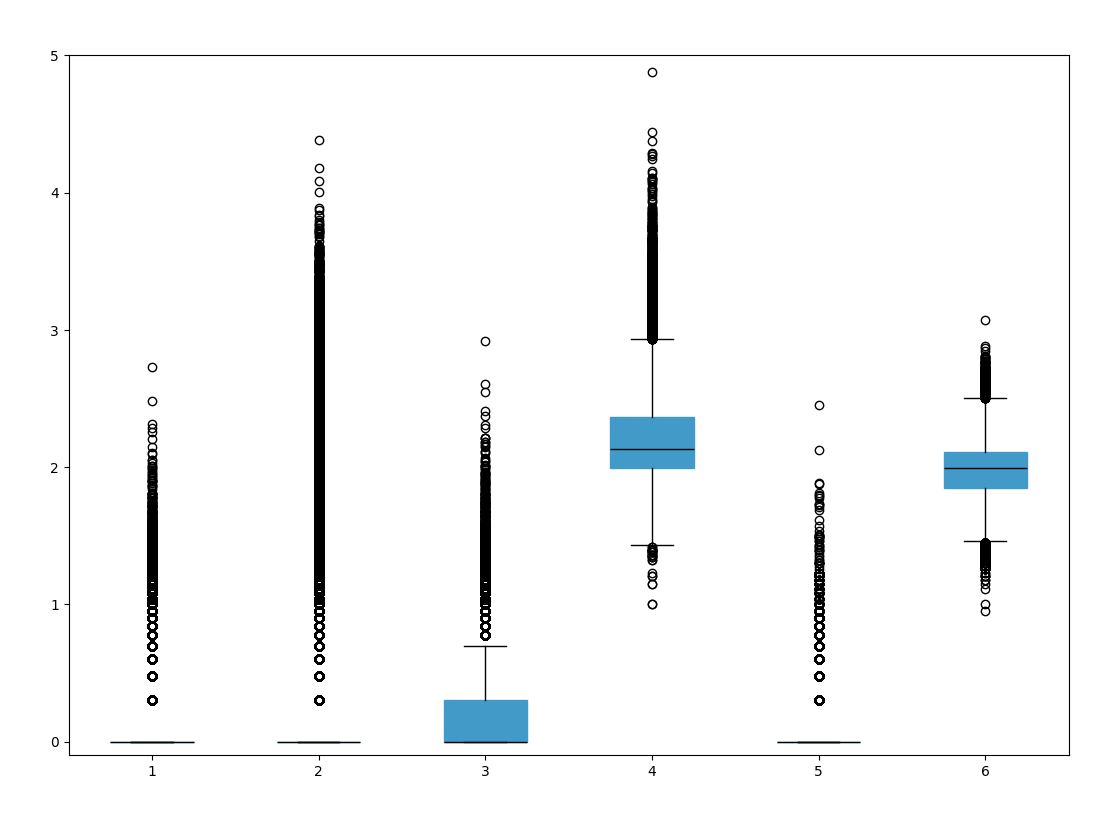

In [685]:
#Box plot since data is non-normal
total_droplets=barplot_input.loc[barplot_input['origin'] == 'totals']
total_nuc=total_droplets.loc[total_droplets['datasetid'] == 'actual']
total_droplets=total_droplets.loc[total_droplets['datasetid'] == 'empty']

unique_droplets=barplot_input.loc[barplot_input['origin'] == 'unique']
unique_nuc=unique_droplets.loc[unique_droplets['datasetid'] == 'actual']
unique_droplets=unique_droplets.loc[unique_droplets['datasetid'] == 'empty']

#altogether
c='#429ac8'
fig = plt.figure(figsize =(10, 7))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot([np.log10(empty_barcodes['UMI_Count']), np.log10(cell_barcodes['UMI_Count']),total_droplets['logged_combo'], total_nuc['logged_combo'],unique_droplets['logged_combo'], unique_nuc['logged_combo']],patch_artist=True,
            boxprops=dict(facecolor=c, color=c),medianprops=dict(color='black'))
bp=ax.set_ylim([-0.1, 5])
# show plot
ax.figure.savefig("/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/cell_box_whisker.svg")
#ax.figure.savefig("/Users/maddieurbanek/Desktop/neuron_submission/empty_droplet/cell_box_whisker.pdf")
plt.show()



In [689]:
#Mann-whitney test of medians for each metric
from scipy.stats import ranksums

print('Combos')
print(ranksums(np.log10(empty_barcodes['UMI_Count']), np.log10(cell_barcodes['UMI_Count'])))
print('Bonferroni Adjusted')
print(0.0*3)
print('Totals')
print(ranksums(total_droplets['logged_combo'], total_nuc['logged_combo']))
print('Bonferroni Adjusted')
print(0.0*3)
print('Unique')
print(ranksums(unique_droplets['logged_combo'], unique_nuc['logged_combo']))
print('Bonferroni Adjusted')
print(0.0*3)


Combos
RanksumsResult(statistic=-83.11174732193565, pvalue=0.0)
Bonferroni Adjusted
0.0
Totals
RanksumsResult(statistic=-212.65985185210607, pvalue=0.0)
Bonferroni Adjusted
0.0
Unique
RanksumsResult(statistic=-212.68898427287726, pvalue=0.0)
Bonferroni Adjusted
0.0


In [ ]:
CONNECTIVITY PART 3

In [534]:
#Stacked bar plots in connectivity fig
cell_type_counts=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/cell_types_per_network.csv',delimiter=',')
two_cells=(cell_type_counts[cell_type_counts['number of cells in single-starter network'] == 2])
print('two cell networks')
print(two_cells['celltype'].value_counts())
two_cells=(cell_type_counts[cell_type_counts['number of cells in single-starter network'] >2])
two_cells=(two_cells[two_cells['number of cells in single-starter network'] <11])
print('three-ten cell networks')
print(two_cells['celltype'].value_counts())
two_cells=(cell_type_counts[cell_type_counts['number of cells in single-starter network'] >10])
two_cells=(two_cells[two_cells['number of cells in single-starter network'] <21])
print('11-20 cell networks')
print(two_cells['celltype'].value_counts())
two_cells=(cell_type_counts[cell_type_counts['number of cells in single-starter network'] >20])
print('>20 cell networks')
print(two_cells['celltype'].value_counts())


two cell networks
celltype
L2/3            145
Interneurons     20
L4               20
L5/6/SP          15
Astrocytes        9
RG                8
OPCs              7
Progenitors       4
Name: count, dtype: int64
three-ten cell networks
celltype
L2/3            754
L4              130
Interneurons     79
L5/6/SP          78
Astrocytes       57
RG               43
OPCs             25
Progenitors      19
Name: count, dtype: int64
11-20 cell networks
celltype
L2/3            573
L4               72
Interneurons     54
L5/6/SP          43
Astrocytes       35
RG               27
OPCs             17
Progenitors      13
Name: count, dtype: int64
>20 cell networks
celltype
L2/3            1610
Interneurons     243
L4               221
RG               134
L5/6/SP          105
Astrocytes        96
Progenitors       81
OPCs              51
Name: count, dtype: int64


  network_size   rg  ol  ac  pr   ga    l2   l4   l5
0            2    8   7   9   4   20   145   20   15
1         3-10   43  25  57  19   79   754  130   78
2        11-20   27  17  35  13   54   573   72   43
3          >20  134  51  96  81  243  1610  221  105


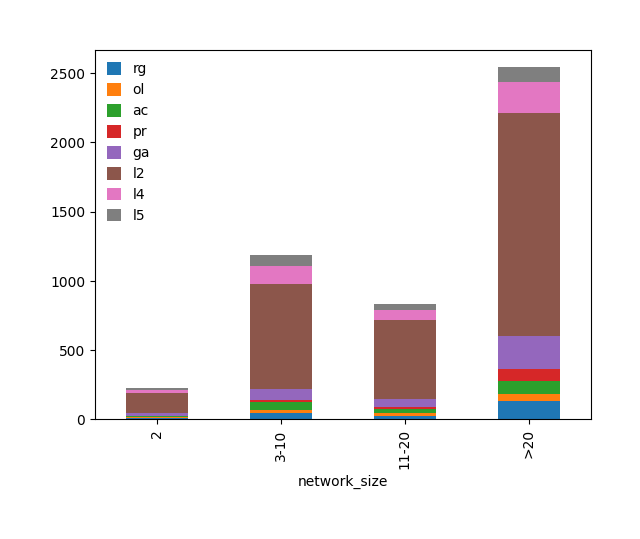

  network_size        rg        ol        ac        pr        ga        l2  \
0            2  0.035088  0.030702  0.039474  0.017544  0.087719  0.635965   
1         3-10  0.036287  0.021097  0.048101  0.016034  0.066667  0.636287   
2        11-20  0.032374  0.020384  0.041966  0.015588  0.064748  0.687050   
3          >20  0.052735  0.020071  0.037780  0.031877  0.095632  0.633609   

         l4        l5  
0  0.087719  0.065789  
1  0.109705  0.065823  
2  0.086331  0.051559  
3  0.086974  0.041322  


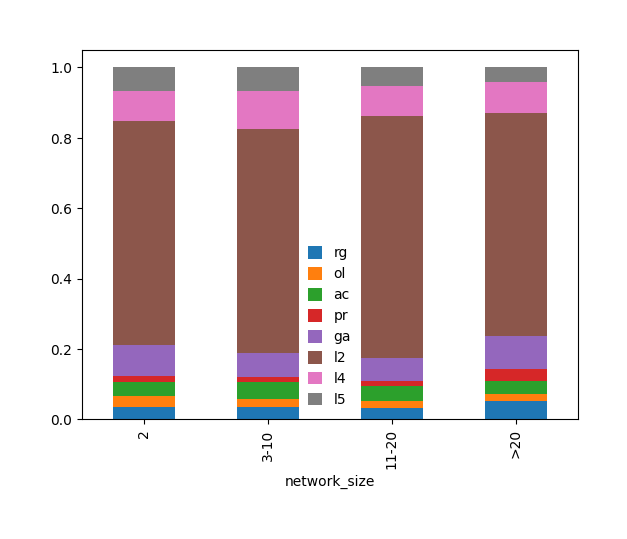

In [546]:
#plot cell type proportions per network
df = pd.DataFrame([['2', 8,7,9,4,20,145,20,15], ['3-10', 43,25,57,19,79,754,130,78], ['11-20', 27,17,35,13,54,573,72,43],
                   ['>20', 134,51,96,81,243,1610,221,105]],
                  columns=['network_size','rg', 'ol', 'ac', 'pr', 'ga','l2','l4','l5'])
# view data
print(df)
 
# plot data in stack manner of bar type
df.plot(x='network_size', kind='bar', stacked=True,
        title='')
plt.draw()
plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/cell_type_network_size.svg",bbox_inches='tight', format='svg')
plt.show()




#plot cell type proportions per network
df = pd.DataFrame([['2',0.035087719,0.030701754,0.039473684,0.01754386,0.087719298,0.635964912,0.087719298,0.065789474 ], ['3-10',0.03628692,0.021097046,0.048101266,0.016033755,0.066666667, 0.63628692,0.109704641,0.065822785], ['11-20',0.032374101,0.020383693,0.041966427,0.01558753,0.064748201,0.68705036,0.086330935,0.051558753 ],
                   ['>20',0.052735144,0.020070838,0.037780401,0.031877214,0.095631641,0.633608815,0.086973632,0.041322314 ]],
                  columns=['network_size','rg', 'ol', 'ac', 'pr', 'ga','l2','l4','l5'])
# view data
print(df)
 
# plot data in stack manner of bar type
df.plot(x='network_size', kind='bar', stacked=True,
        title='')
plt.draw()
plt.savefig("/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/cell_type_network_size_props.svg",bbox_inches='tight', format='svg')
plt.show()


In [780]:
metadata=pd.read_table('/Users/maddieurbanek/Downloads/metadata.csv',delimiter=',')
#barcodes=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/thresholded_barcodes.csv',delimiter=',')
#foundercells=pd.read_table('/Users/maddieurbanek/Desktop/neuron_submission/data/thresholded_helpers.csv',delimiter=',')
print(metadata)

            Unnamed: 0     orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
0     AAAAAAAGCAGTAGGT  SeuratProject       10603          4124    1.575026   
1     AAAAAACTCAAAAGTA  SeuratProject        8210          3590    3.434836   
2     AAAAAATTCACGAGAT  SeuratProject        9958          3832    3.113075   
3     AAAAACCGACGCCCTC  SeuratProject        6097          3516    2.099393   
4     AAAAACGAAACGATTG  SeuratProject        7001          3522    2.099700   
...                ...            ...         ...           ...         ...   
1839  CCTGCCATCATCCACC  SeuratProject       13273          4734    3.164319   
1840  CCTGCCCAAGTACCGA  SeuratProject       14647          4907    2.573906   
1841  CCTGCCGGAGTTAAAA  SeuratProject        6981          3176    3.738719   
1842  CCTGCCGTAAAAACGT  SeuratProject        9350          4029    2.331551   
1843  CCTGCCTAAAAGAAGC  SeuratProject        9070          4083    2.326351   

      nCount_SCT  nFeature_SCT  SCT_snn_res.0.8  se

In [822]:
barcodes=pd.read_table('/Users/maddieurbanek/Downloads/completecounts.tsv',delimiter='\t')
print(barcodes)
helpers=pd.read_table('/Users/maddieurbanek/Downloads/helperindex.tsv',delimiter='\t')
print(helpers)

                         CBC  \
0        b'CAACCAGCACGGCCAC'   
1        b'ATCGATATATTAAGGC'   
2        b'CCCGCCCTACGTAATC'   
3        b'CACCAATCATTCATTC'   
4        b'AAGACCATAATACAGG'   
...                      ...   
2217839  b'AAAGACTGAACCCAAT'   
2217840  b'ACAACCTCATGCAACC'   
2217841  b'ATACAATTAGGTAAGC'   
2217842  b'CAAGCACAATGTAATG'   
2217843  b'CACGAATAACTTCCCA'   

                                                   barcode  UMI_Count  
0        AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...          4  
1        AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...          8  
2        AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...          1  
3        AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...          1  
4        AATTCAAACCCCTGGCGATGG-GATCAACACCTGCCGTGTTG-CTA...          1  
...                                                    ...        ...  
2217839  AATTCTTTTGGTGCGAGCCTG-GATCTGTTGGCGCCAGAGAG-CTA...          1  
2217840  AATTCTTTTGGTGCGAGCCTG-GATCTGTT

In [823]:
barcodes['CBC'] = barcodes['CBC'].str.replace("'", "")
barcodes['CBC'] = barcodes['CBC'].str.replace('b', "")
helpers['CBC'] = helpers['CBC'].str.replace("'", "")
helpers['CBC'] = helpers['CBC'].str.replace('b', "")

In [824]:
barcodes = barcodes[barcodes['CBC'].isin(metadata['cellbarcode'])]
barcodes.drop(barcodes[barcodes['UMI_Count'] < 3].index, inplace=True)

In [816]:
helpers.drop(helpers[helpers['UMI_Count'] < 3].index, inplace=True)
print(helpers)

                   CBC  helper  UMI_Count
4     AACGAGCCAAAGATTT  helper         12
5     CCCGATTTCCGAACAA  helper          5
7     ATCACCGTATGACCCA  helper         41
8     CAACATCGAGGCAAGT  helper          5
9     CAGCACCTAAGGAGCT  helper         26
...                ...     ...        ...
5830  AGACCAAAAATAACAT  helper          3
6199  ATTAAATCCATGACAT  helper          4
6282  CAAGAACTCAACATAC  helper          3
6500  AAGCATGAATAAATTG  helper          3
7081  ACAGATATAGGGATAA  helper          3

[1090 rows x 3 columns]


In [817]:

helper_barcodes=barcodes[barcodes['CBC'].isin(helpers['CBC'])]
barcodes=barcodes[~barcodes['CBC'].isin(helpers['CBC'])]



In [825]:

print(barcodes['CBC'].nunique())
print(metadata['cellbarcode'].nunique())
print(helper_barcodes['CBC'].nunique())

1126
1844
561


In [826]:

unique_pre=barcodes.groupby('CBC')['barcode'].nunique()
unique_post=helper_barcodes.groupby('CBC')['barcode'].nunique()
print(unique_post.max())
print(unique_pre.max())

29
45


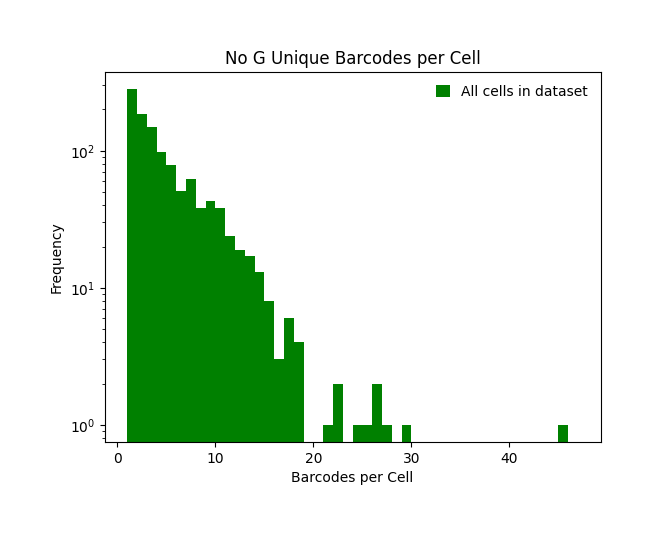

In [828]:
plt.hist((unique_pre),bins=range(1, 45 + 3, 1),label='All cells in dataset',color='green')
#plt.hist((unique_post),bins=range(1, 45 + 3, 1),label='Starter',color='green',alpha=0.5)
#plt.hist(np.log10(umisreads['count']), bins = 500)
#plt.axis([-.1, 1000, 0, 10000])
plt.xlabel('Barcodes per Cell')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.yscale('log')
plt.title('No G Unique Barcodes per Cell')


#plt.savefig('/Users/maddieurbanek/Desktop/neuron_submission/8_connectivity/network_size_dist.svg', bbox_inches='tight', format='svg')
plt.show()